In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import time
import os
from dataclasses import dataclass
from collections import namedtuple
import pyro
import optax
from pyro.infer import SVI, TraceGraph_ELBO
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.examples.multi_mnist as multi_mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.font_manager as font_manager
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import rcParams
from scipy.interpolate import griddata
import genjax
from genjax import grasp

# import sys
# sys.setrecursionlimit(10000)

key = jax.random.PRNGKey(314159)
sns.set_theme(style="white")
font_path = (
    "/home/femtomc/.local/share/fonts/Unknown Vendor/TrueType/Lato/Lato_Bold.ttf"
)
font_manager.fontManager.addfont(font_path)
custom_font_name = font_manager.FontProperties(fname=font_path).get_name()
rcParams["font.family"] = custom_font_name

key = jax.random.PRNGKey(314159)
label_fontsize = 70  # Set the desired font size here

smoke_test = "CI" in os.environ
assert pyro.__version__.startswith("1.8.6")

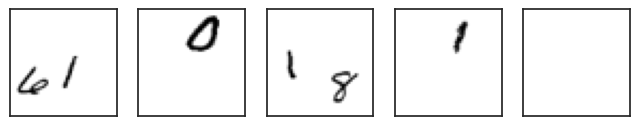

In [2]:
inpath = "./data/air/.data"
X_np, Y = multi_mnist.load(inpath)
X_np = X_np.astype(np.float32)
X_np /= 255.0
mnist = jnp.array(X_np)
true_counts = jnp.array([len(objs) for objs in Y])


def show_images(imgs):
    fig = plt.figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, len(imgs), i + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(img, cmap="gray_r")


show_images(mnist[9:14])

## Defining the variational ingredients

### Utilities / learnable pieces

In [3]:
from genjax import Pytree
import equinox as eqx
from genjax.typing import Any
from genjax.typing import Tuple
from genjax.typing import FloatArray
from genjax.typing import Int
from genjax.typing import IntArray
from genjax.typing import PRNGKey
from genjax.typing import typecheck

# Utilities for defining the model and the guide.


@dataclass
class Decoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(50, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 400, key=key2)
        return Decoder(dense_1, dense_2)

    def __call__(self, z_what):
        v = self.dense_1(z_what)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return jax.nn.sigmoid(v)


# Create our decoder.
key, sub_key1, sub_key2 = jax.random.split(key, 3)
decoder = Decoder.new(sub_key1, sub_key2)

# Create our RNN for the guide.
key, sub_key = jax.random.split(key)
rnn = eqx.nn.LSTMCell(2554, 256, key=sub_key)


@dataclass
class Encoder(Pytree):
    dense_1: Any
    dense_2: Any

    def flatten(self):
        return (self.dense_1, self.dense_2), ()

    @classmethod
    def new(cls, key1, key2):
        dense_1 = eqx.nn.Linear(400, 200, key=key1)
        dense_2 = eqx.nn.Linear(200, 100, key=key2)
        return Encoder(dense_1, dense_2)

    def __call__(self, data):
        v = self.dense_1(data)
        v = jax.nn.leaky_relu(v)
        v = self.dense_2(v)
        return v[0:50], jax.nn.softplus(v[50:])


key, sub_key1, sub_key2 = jax.random.split(key, 3)
encoder = Encoder.new(sub_key1, sub_key2)


@dataclass
class Predict(Pytree):
    dense: Any

    def flatten(self):
        return (self.dense,), ()

    @classmethod
    def new(cls, key):
        dense = eqx.nn.Linear(256, 7, key=key)
        return Predict(dense)

    def __call__(self, h):
        a = self.dense(h)
        z_pres_p = jax.nn.sigmoid(a[0:1])
        z_where_loc = a[1:4]
        z_where_scale = jax.nn.softplus(a[4:])
        return z_pres_p, z_where_loc, z_where_scale


key, sub_key = jax.random.split(key)
predict = Predict.new(key)

In [4]:
#######
# STN #
#######

# modified from https://github.com/kevinzakka/spatial-transformer-network/blob/master/stn/transformer.py


def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.

    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.

    - width: desired width of grid/output. Used
      to downsample or upsample.

    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.

    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.

    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = theta.shape[0]

    # create normalized 2D grid
    x = jnp.linspace(-1.0, 1.0, width)
    y = jnp.linspace(-1.0, 1.0, height)
    x_t, y_t = jnp.meshgrid(x, y)

    # flatten
    x_t_flat = jnp.reshape(x_t, [-1])
    y_t_flat = jnp.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = jnp.ones_like(x_t_flat)
    sampling_grid = jnp.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = jnp.expand_dims(sampling_grid, axis=0)
    sampling_grid = jnp.tile(sampling_grid, [num_batch, 1, 1])

    # transform the sampling grid - batch multiply
    batch_grids = jnp.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, 2, H, W)
    batch_grids = jnp.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids


def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.

    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.

    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.

    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = jnp.shape(img)[1]
    W = jnp.shape(img)[2]
    max_y = H - 1
    max_x = W - 1
    zero = jnp.zeros([], dtype=int)

    # rescale x and y to [0, W-1/H-1]
    x = 0.5 * ((x + 1.0) * max_x - 1)
    y = 0.5 * ((y + 1.0) * max_y - 1)

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = jnp.floor(x).astype(int)
    x1 = x0 + 1
    y0 = jnp.floor(y).astype(int)
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = jnp.clip(x0, zero, max_x)
    x1 = jnp.clip(x1, zero, max_x)
    y0 = jnp.clip(y0, zero, max_y)
    y1 = jnp.clip(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = x0.astype(float)
    x1 = x1.astype(float)
    y0 = y0.astype(float)
    y1 = y1.astype(float)

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = jnp.expand_dims(wa, axis=3)
    wb = jnp.expand_dims(wb, axis=3)
    wc = jnp.expand_dims(wc, axis=3)
    wd = jnp.expand_dims(wd, axis=3)

    # compute output
    out = wa * Ia + wb * Ib + wc * Ic + wd * Id
    return out


def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.

    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)

    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    batch_size, height, width = jnp.shape(x)

    batch_idx = jnp.arange(0, batch_size)
    batch_idx = jnp.reshape(batch_idx, (batch_size, 1, 1))
    b = jnp.tile(batch_idx, (1, height, width))

    indices = jnp.stack([b, y, x], 3)

    return gather_nd(img, indices)


# from: https://github.com/google/jax/discussions/6119
def gather_nd_unbatched(params, indices):
    return params[tuple(jnp.moveaxis(indices, -1, 0))]


def gather_nd(params, indices, batch=False):
    if not batch:
        return gather_nd_unbatched(params, indices)
    else:
        return vmap(gather_nd_unbatched, (0, 0), 0)(params, indices)


def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = 1
    expansion_indices = jnp.array([1, 0, 2, 0, 1, 3])
    z_where = jnp.expand_dims(z_where, axis=0)
    out = jnp.concatenate((jnp.broadcast_to(jnp.zeros([1, 1]), (n, 1)), z_where), 1)
    return jnp.reshape(out[:, expansion_indices], (n, 2, 3))


def object_to_image(z_where, obj):
    n = 1
    theta = expand_z_where(z_where)
    grid = affine_grid_generator(50, 50, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(obj, (n, 20, 20, 1)), x_s, y_s)
    return jnp.reshape(out, (50, 50))


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = 1
    out = jnp.array([1, *(-z_where[1:])])
    out = out / z_where[0]
    return out


def image_to_object(z_where, image):
    n = 1
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid_generator(20, 20, theta_inv)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    out = bilinear_sampler(jnp.reshape(image, (n, 50, 50, 1)), x_s, y_s)
    return jnp.reshape(out, (400,))

### Model

In [5]:
#########
# Model #
#########

# Fixed constants.
z_where_prior_loc = jnp.array([3.0, 0.0, 0.0])
z_where_prior_scale = jnp.array([0.2, 1.0, 1.0])
z_what_prior_loc = jnp.zeros(50, dtype=float)
z_what_prior_scale = jnp.ones(50, dtype=float)
z_pres_prior = 0.1
eps = 1e-4


@genjax.gen
@typecheck
def step(
    t: Int,
    decoder: Decoder,
    prev_x: FloatArray,
    prev_z_pres: IntArray,
):
    z_pres = grasp.flip_mvd(z_pres_prior ** (2 * t + 1)) @ f"z_pres_{t}"
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = (
        grasp.mv_normal_diag_reparam(z_where_prior_loc, z_where_prior_scale)
        @ f"z_where_{t}"
    )
    z_what = (
        grasp.mv_normal_diag_reparam(z_what_prior_loc, z_what_prior_scale)
        @ f"z_what_{t}"
    )
    y_att = decoder(z_what)
    y = object_to_image(z_where, y_att)
    x = prev_x + (y * z_pres)
    return x, z_pres


# TODO: Make sure that this works, where t is a static int.
@genjax.gen
@typecheck
def model(decoder: Decoder):
    x = jnp.zeros((50, 50), dtype=float)
    z_pres = jnp.ones(1, dtype=int)
    for t in range(3):
        x, z_pres = step.inline(t, decoder, x, z_pres)
    obs = grasp.mv_normal_diag_reparam(x, 0.3 * jnp.ones_like(x)) @ "obs"
    return x

#### Samples from the model

In [6]:
tr = jax.jit(model.simulate)(key, (decoder,))
tr.strip()

HierarchicalChoiceMap(trie=Trie(inner={'z_where_2': ValueChoiceMap(value=Array([3.3112705 , 0.38920578, 0.87010336], dtype=float32)), 'z_where_0': ValueChoiceMap(value=Array([2.9852889 , 0.37495273, 0.6592882 ], dtype=float32)), 'z_what_0': ValueChoiceMap(value=Array([ 0.7757531 , -0.8685526 , -0.05359564, -0.67465776, -0.95735234,
        0.5865343 , -0.10566778, -0.16378485,  1.0235561 ,  0.85741025,
        1.9725322 , -1.5243609 , -0.66933525,  1.6045389 , -0.94336843,
        1.2441416 , -1.1807892 , -0.4210534 , -0.12432883, -1.2137041 ,
        0.5650314 ,  0.8860479 ,  0.3095849 ,  0.86958766, -0.30055302,
        0.6282733 ,  0.4091684 ,  1.5020167 ,  0.27552533,  0.18055934,
        1.2542675 ,  0.11440992,  0.05915328,  0.33706275,  1.0752436 ,
       -1.3770775 , -0.65948266,  0.01564748, -1.0956122 , -0.32709584,
        0.6060096 ,  0.91976094,  0.06281727,  0.81378216,  1.0632383 ,
       -1.3442756 ,  0.3835195 , -0.65517896,  0.8194681 ,  0.6711313 ],      dtype=float3

### Guide

In [7]:
#########
# Guide #
#########


@genjax.gen
@typecheck
def guide_step(
    t: Int,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
    data,
    prev: Tuple,
):
    (prev_z_where, prev_z_what, prev_z_pres, prev_h, prev_c) = prev
    rnn_input = jnp.concatenate([data, prev_z_where, prev_z_what, prev_z_pres])
    h, c = rnn(rnn_input, (prev_h, prev_c))
    z_pres_p, z_where_loc, z_where_scale = predict(h)
    z_pres = (
        grasp.flip_mvd((eps + (z_pres_p[0] * prev_z_pres[0])) / (1 + 2 * eps))
        @ f"z_pres_{t}"
    )
    z_pres = jnp.array([z_pres.astype(int)])
    z_where = grasp.mv_normal_diag_reparam(z_where_loc, z_where_scale) @ f"z_where_{t}"
    x_att = image_to_object(z_where, data)
    z_what_loc, z_what_scale = encoder(x_att)
    z_what = grasp.mv_normal_diag_reparam(z_what_loc, z_what_scale) @ f"z_what_{t}"
    return z_where, z_what, z_pres, h, c


@genjax.gen
@typecheck
def guide(
    data: genjax.ChoiceMap,
    rnn: eqx.nn.LSTMCell,
    encoder: Encoder,
    predict: Predict,
):
    h = jnp.zeros(256)
    c = jnp.zeros(256)
    z_pres = jnp.ones(1)
    z_where = jnp.zeros(3)
    z_what = jnp.zeros(50)
    img = data["obs"]
    img_arr = img.flatten()

    for t in range(3):
        (z_where, z_what, z_pres, h, c) = guide_step.inline(
            t, rnn, encoder, predict, img_arr, (z_where, z_what, z_pres, h, c)
        )

#### Samples from the guide

In [8]:
data_chm = genjax.choice_map({"obs": jnp.ones((50, 50))})
tr = jax.jit(guide.simulate)(key, (data_chm, rnn, encoder, predict))
tr.strip()

HierarchicalChoiceMap(trie=Trie(inner={'z_where_2': ValueChoiceMap(value=Array([1.44559   , 0.09122826, 0.39324838], dtype=float32)), 'z_where_0': ValueChoiceMap(value=Array([0.09956367, 0.09166238, 0.32089818], dtype=float32)), 'z_what_0': ValueChoiceMap(value=Array([ 0.47881928, -0.6001495 , -0.07596396, -0.46712643, -0.6377853 ,
        0.4880015 , -0.0026071 , -0.0648842 ,  0.68812644,  0.55307406,
        1.4098706 , -1.0631292 , -0.40985143,  1.1942633 , -0.6337316 ,
        0.90972066, -0.7271465 , -0.3805505 , -0.08980705, -0.8501938 ,
        0.43871439,  0.5818898 ,  0.29893732,  0.57461274, -0.11380556,
        0.41587007,  0.20875463,  0.9551446 ,  0.2335587 ,  0.05214904,
        0.95153826,  0.15101334,  0.06873246,  0.2672779 ,  0.7856569 ,
       -1.0018222 , -0.40071332,  0.05744316, -0.86725295, -0.23935616,
        0.37568498,  0.7159259 , -0.02495935,  0.5464951 ,  0.6715891 ,
       -1.0317073 ,  0.23442937, -0.37587446,  0.4990818 ,  0.46639284],      dtype=float3

## Training

### Make sure grads are working

#### Define ELBO objective

In [9]:
data = genjax.choice_map({"obs": jnp.ones((50, 50))})
objective = grasp.elbo(model, guide, data)
objective

Expectation(prog=ADEVProgram(source=<function elbo.<locals>.elbo_loss at 0x7f6e54444700>))

#### Go go grads

In [10]:
jitted = jax.jit(objective.value_and_grad_estimate)
loss, ((decoder_grads,), (_, rnn_grads, encoder_grads, predict_grads)) = jitted(
    key, ((decoder,), (data, rnn, encoder, predict))
)

In [11]:
loss

Array(-13632.005, dtype=float32)

### Dataloader

In [12]:
def data_loader(
    data,
    batch_size,
    shuffle=True,
):
    N = len(data)
    data_idxs = np.arange(N)
    num_batch = int(np.ceil(N // batch_size))

    def init(key):
        return (
            num_batch,
            jax.random.permutation(key, data_idxs) if shuffle else data_idxs,
        )

    def get_batch(i=0, idxs=data_idxs):
        ret_idx = jax.lax.dynamic_slice_in_dim(idxs, i * batch_size, batch_size)
        return jax.lax.index_take(data, (ret_idx,), axes=(0,))

    return init, get_batch

In [13]:
##################
# Count Accuracy #
##################


def count_accuracy(data, true_counts, guide, batch_size=1000):
    global prng_key
    assert data.shape[0] == true_counts.shape[0], "Size mismatch."
    assert data.shape[0] % batch_size == 0, "Input size must be multiple of batch_size."

    def eval_guide(key, data, params):
        data_chmp = genjax.choice_map({"obs": data})
        return guide.simulate(key, (data_chmp, *params))

    batch_eval_guide = jax.jit(jax.vmap(eval_guide, in_axes=(0, 0, None)))

    @jax.jit
    def evaluate_count_accuracy(key, params):
        def evaluate_batch(counts, batch_id):
            data_batch = jax.lax.dynamic_slice_in_dim(
                data, batch_id * batch_size, batch_size
            )
            true_counts_batch = jax.lax.dynamic_slice_in_dim(
                true_counts, batch_id * batch_size, batch_size
            )
            data_chmp = genjax.choice_map({"obs": data_batch})
            # evaluate guide
            keys = jax.random.split(jax.random.fold_in(key, batch_id), batch_size)
            tr = batch_eval_guide(keys, data_batch, params)
            z_where = [tr[f"z_where_{i}"] for i in range(3)]
            z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
            # compute stats
            inferred_counts = sum(z for z in z_pres)
            true_counts_m = jax.nn.one_hot(true_counts_batch, 3)
            inferred_counts_m = jax.nn.one_hot(inferred_counts, 4)
            counts += (true_counts_m.T @ inferred_counts_m).astype(int)
            error_ind = 1 - (true_counts_batch == inferred_counts).astype(int)
            # error_ix = error_ind.nonzero()[0]
            # error_latent = jnp.take(latents_to_tensor((z_where, z_pres)), error_ix, 0)
            return counts, error_ind

        counts = jnp.zeros((3, 4), dtype=int)
        counts, error_indices = jax.lax.scan(
            evaluate_batch, counts, jnp.arange(data.shape[0] // batch_size)
        )

        acc = jnp.sum(jnp.diag(counts)).astype(float) / data.shape[0]
        error_indices = jnp.concatenate(
            error_indices
        )  # .nonzero()[0]  # <- not JIT compilable
        return acc, counts, error_indices

    return evaluate_count_accuracy


# Combine z_pres and z_where (as returned by the model and guide) into
# a single tensor, with size:
# [batch_size, num_steps, z_where_size + z_pres_size]
def latents_to_tensor(z):
    return jnp.stack(
        [
            jnp.concatenate((z_where, z_pres.reshape(-1, 1)), 1)
            for z_where, z_pres in zip(*z)
        ]
    ).transpose(1, 0, 2)

In [14]:
##################
# Visualization  #
##################


def bounding_box(z_where, x_size):
    """This doesn't take into account interpolation, but it's close
    enough to be usable."""
    w = x_size / z_where.s
    h = x_size / z_where.s
    xtrans = -z_where.x / z_where.s * x_size / 2.0
    ytrans = -z_where.y / z_where.s * x_size / 2.0
    x = (x_size - w) / 2 + xtrans  # origin is top left
    y = (x_size - h) / 2 + ytrans
    return (x, y), w, h


z_obj = namedtuple("z", ["s", "x", "y", "pres"])


# Map a tensor of latents (as produced by latents_to_tensor) to a list
# of z_obj named tuples.
def tensor_to_objs(latents):
    return [[z_obj._make(step) for step in z] for z in latents]


def visualize_model(model, guide):
    def reconstruct_digits(key, data, params):
        decoder, rnn, encoder, predict = params
        data_chmp = genjax.choice_map({"obs": data})
        key1, key2 = jax.random.split(key)
        tr = guide.simulate(key1, (data_chmp, rnn, encoder, predict))
        _, tr = model.importance(key2, tr, (decoder,))
        reconstruction = tr.get_retval()
        z_where = [tr[f"z_where_{i}"] for i in range(3)]
        z_pres = [tr[f"z_pres_{i}"] for i in range(3)]
        return reconstruction, (z_where, z_pres)

    batch_reconstruct_digits = jax.jit(
        jax.vmap(reconstruct_digits, in_axes=(0, 0, None))
    )

    def visualize(key, params, examples_to_viz):
        keys = jax.random.split(key, examples_to_viz.shape[0])
        recons, z = batch_reconstruct_digits(keys, examples_to_viz, params)
        z_wheres = tensor_to_objs(latents_to_tensor(z))
        draw_many(examples_to_viz.reshape(-1, 50, 50), z_wheres, title="Original")
        draw_many(recons, z_wheres, title="Reconstruction")

    return visualize


def colors(k):
    return ["r", "g", "b"][k % 3]


def draw_one(img, z):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap="gray_r")
    for k, z in enumerate(z):
        if z.pres > 0:
            (x, y), w, h = bounding_box(z, img.shape[0])
            plt.gca().add_patch(
                Rectangle(
                    (x, y), w, h, linewidth=1, edgecolor=colors(k), facecolor="none"
                )
            )


def draw_many(imgs, zs, title):
    plt.figure(figsize=(8, 1.9))
    plt.title(title)
    plt.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    plt.box(False)
    for i, (img, z) in enumerate(zip(imgs, zs)):
        plt.subplot(1, len(imgs), i + 1)
        draw_one(img, z)
    plt.show()

In [15]:
params = (decoder, rnn, encoder, predict)
evaluate_accuracy = count_accuracy(mnist, true_counts, guide, batch_size=1000)

visualize_examples = mnist[5:10]
visualize = visualize_model(model, guide)

In [16]:
def train(key, n=1, num_epochs=200, batch_size=64, learning_rate=1.0e-3):
    def svi_update(model, guide, optimiser):
        def batch_updater(key, params, opt_state, data_batch):
            def grads(key, params, data):
                (decoder, rnn, encoder, predict) = params
                data = genjax.choice_map({"obs": data})
                objective = grasp.iwae_elbo(model, guide, data, n)
                loss, (
                    (decoder_grads,),
                    (_, rnn_grads, encoder_grads, predict_grads),
                ) = objective.value_and_grad_estimate(
                    key, ((decoder,), (data, rnn, encoder, predict))
                )
                return loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads)

            sub_keys = jax.random.split(key, len(data_batch))
            loss, (decoder_grads, rnn_grads, encoder_grads, predict_grads) = jax.vmap(
                grads, in_axes=(0, None, 0)
            )(sub_keys, params, data_batch)

            grads = jtu.tree_map(
                lambda v: -1.0 * jnp.mean(v, axis=0),
                (decoder_grads, rnn_grads, encoder_grads, predict_grads),
            )
            updates, opt_state = optimiser.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss = jnp.mean(loss)
            return params, opt_state, loss

        return batch_updater

    adam = optax.adam(learning_rate)
    svi_updater = svi_update(model, guide, adam)

    @jax.jit
    def epoch_train(opt_state, params, key, train_idx):
        def body_fn(carry, xs):
            idx, params, opt_state, loss = carry
            updater_key = jax.random.fold_in(key, idx)
            batch = train_fetch(idx, train_idx)
            params, opt_state, loss = svi_updater(updater_key, params, opt_state, batch)
            idx += 1
            return (idx, params, opt_state, loss), loss

        idx = 0
        (_, params, opt_state, _), losses = jax.lax.scan(
            body_fn, (idx, params, opt_state, 0.0), None, length=num_batch
        )
        return params, opt_state, losses

    # Train.
    params = (decoder, rnn, encoder, predict)
    opt_state = adam.init(params)
    losses = []
    accuracy = []
    acc_time = 0.0
    wall_clock_times = []
    train_init, train_fetch = data_loader(jnp.array(mnist), batch_size)
    key, sub_key = jax.random.split(key)
    num_batch, train_idx = train_init(sub_key)

    # Warm up.
    _ = epoch_train(opt_state, params, key, train_idx)

    t0 = time.perf_counter()
    acc_time = 0.0
    for i in range(0, num_epochs + 1):
        key, sub_key = jax.random.split(key)
        num_batch, train_idx = train_init(sub_key)
        key, sub_key = jax.random.split(key)
        start = time.perf_counter() - t0
        params, opt_state, loss = epoch_train(opt_state, params, sub_key, train_idx)
        stop = time.perf_counter() - t0
        acc_time += stop - start
        losses.append(jnp.mean(loss))
        wall_clock_times.append(acc_time)
        acc, counts, error_ix = evaluate_accuracy(sub_key, params[1:])
        accuracy.append(acc)
        print(
            f"Epoch={i}, total_epoch_step_time={acc_time:.2f}, loss={jnp.mean(loss):.2f}"
        )
        print("accuracy={}, counts={}".format(acc, counts))
        visualize(sub_key, params, visualize_examples)

    return losses, accuracy, wall_clock_times, params

Epoch=0, total_epoch_step_time=4.08, loss=507.39
accuracy=0.8791500329971313, counts=[[18771  1171     6     0]
 [  107 15289  4601    23]
 [    7   622 18689   714]]


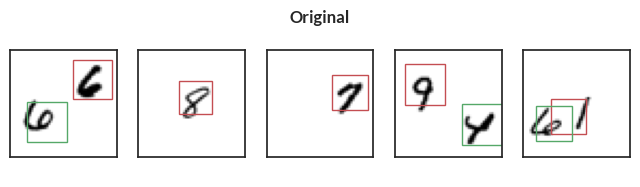

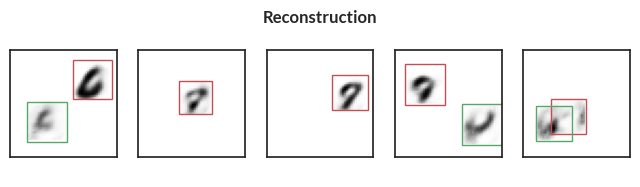

Epoch=1, total_epoch_step_time=8.15, loss=597.47
accuracy=0.9351833462715149, counts=[[19641   307     0     0]
 [   37 17461  2520     2]
 [    3   959 19009    61]]


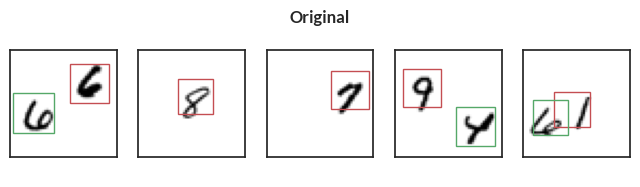

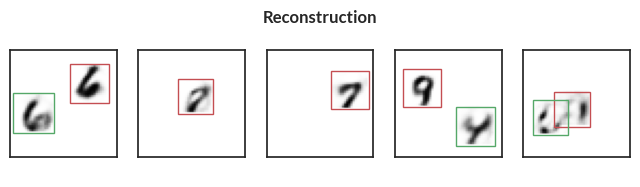

Epoch=2, total_epoch_step_time=12.22, loss=612.19
accuracy=0.9335333704948425, counts=[[19822   126     0     0]
 [   24 16862  3133     1]
 [    3   658 19328    43]]


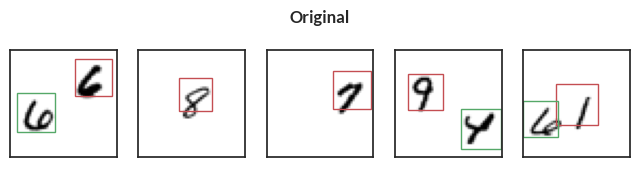

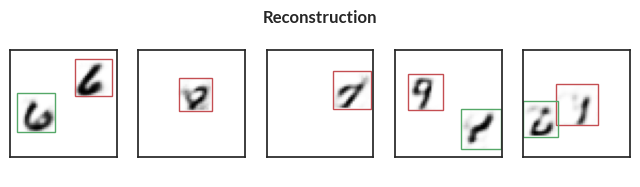

Epoch=3, total_epoch_step_time=16.29, loss=617.64
accuracy=0.8813333511352539, counts=[[19859    89     0     0]
 [    9 13339  6667     5]
 [    1   232 19682   117]]


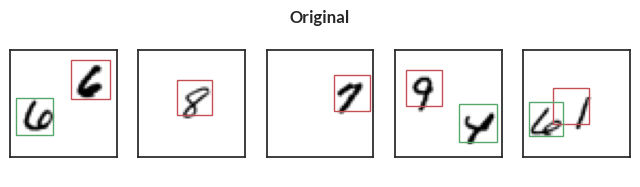

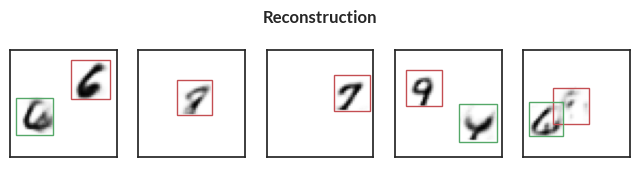

Epoch=4, total_epoch_step_time=20.36, loss=620.04
accuracy=0.873283326625824, counts=[[19902    46     0     0]
 [    7 12725  7286     2]
 [    0   236 19770    26]]


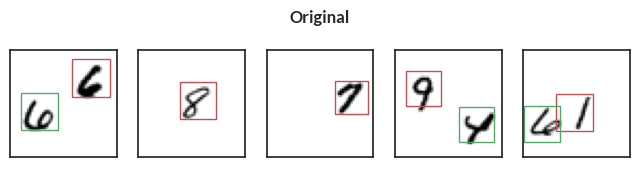

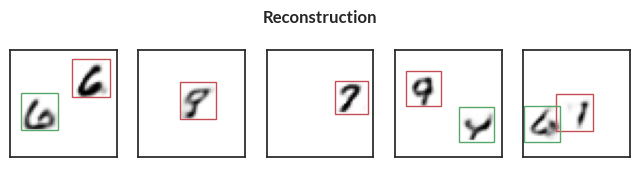

Epoch=5, total_epoch_step_time=24.44, loss=621.72
accuracy=0.8822667002677917, counts=[[19916    32     0     0]
 [    5 13315  6697     3]
 [    0   312 19705    15]]


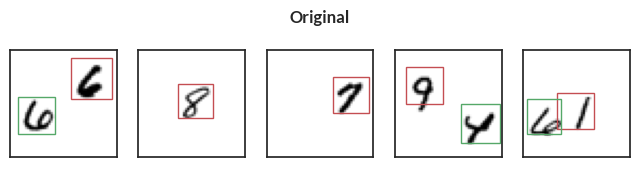

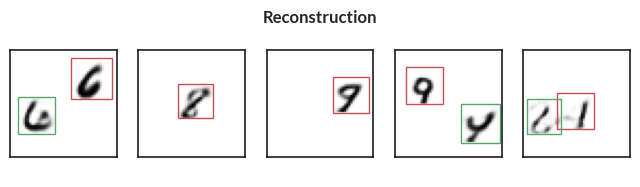

Epoch=6, total_epoch_step_time=28.51, loss=622.55
accuracy=0.848466694355011, counts=[[19926    22     0     0]
 [    3 11188  8827     2]
 [    4   200 19794    34]]


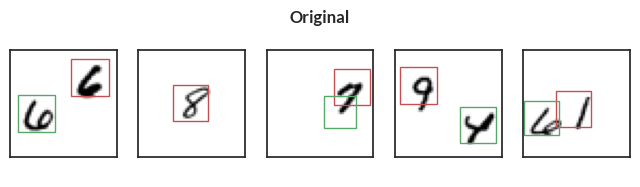

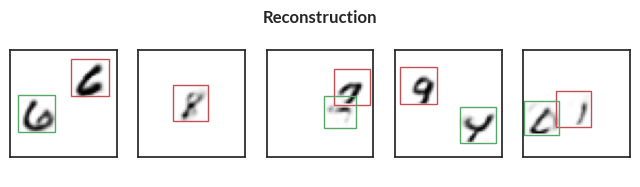

Epoch=7, total_epoch_step_time=32.59, loss=623.12
accuracy=0.8260833621025085, counts=[[19925    23     0     0]
 [    5  9834 10178     3]
 [    3   216 19806     7]]


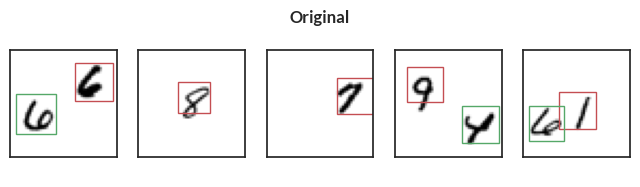

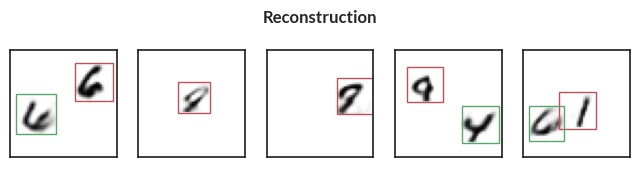

Epoch=8, total_epoch_step_time=36.68, loss=624.10
accuracy=0.8166333436965942, counts=[[19926    22     0     0]
 [    3  9273 10743     1]
 [    2   209 19799    22]]


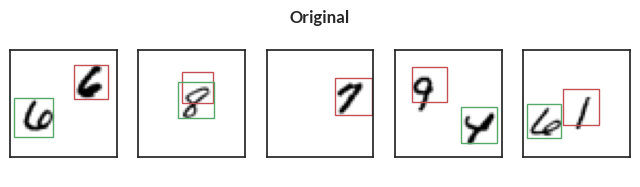

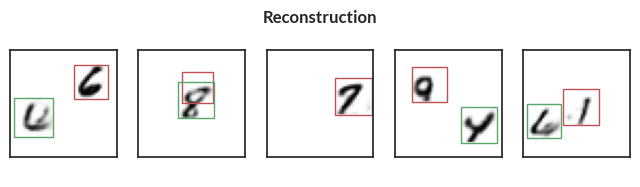

Epoch=9, total_epoch_step_time=40.76, loss=624.32
accuracy=0.8171499967575073, counts=[[19932    16     0     0]
 [    0  9315 10702     3]
 [    3   231 19782    16]]


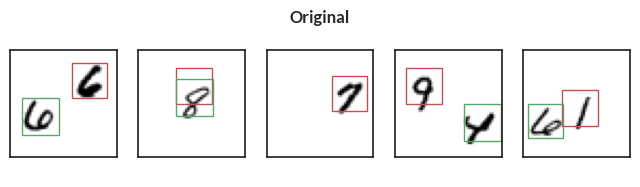

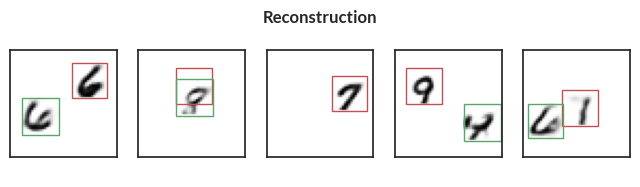

Epoch=10, total_epoch_step_time=44.84, loss=624.83
accuracy=0.7906166911125183, counts=[[19941     7     0     0]
 [    0  7596 12419     5]
 [    2    92 19900    38]]


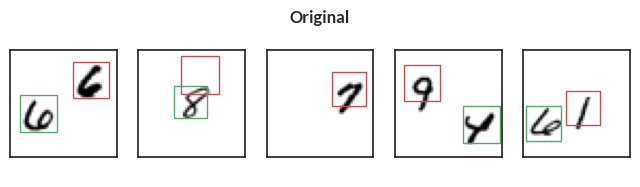

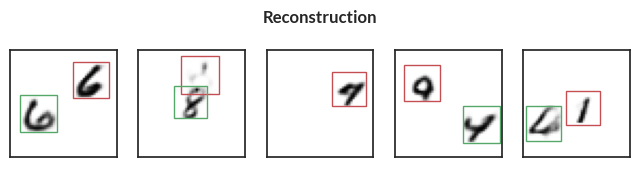

Epoch=11, total_epoch_step_time=48.92, loss=625.18
accuracy=0.791533350944519, counts=[[19935    13     0     0]
 [    4  7737 12276     3]
 [    4   187 19820    21]]


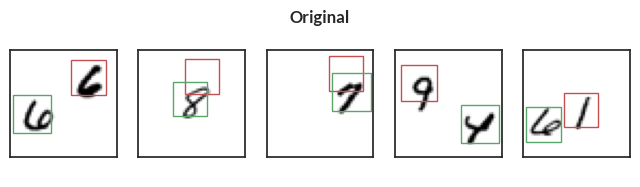

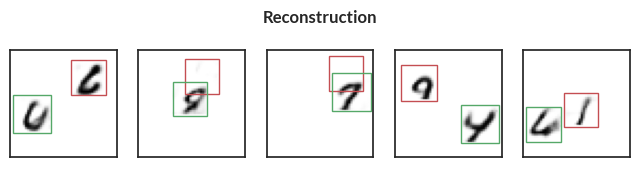

Epoch=12, total_epoch_step_time=53.01, loss=626.23
accuracy=0.7850666642189026, counts=[[19934    14     0     0]
 [    1  7352 12666     1]
 [    2   205 19818     7]]


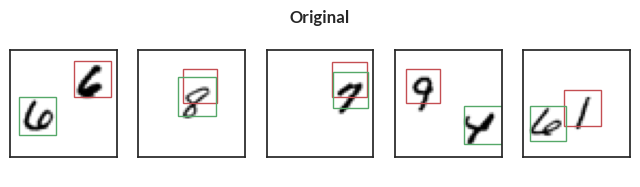

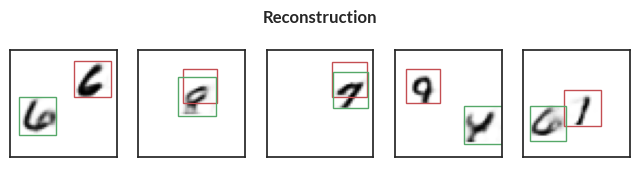

Epoch=13, total_epoch_step_time=57.09, loss=626.31
accuracy=0.7826499938964844, counts=[[19933    15     0     0]
 [    3  7205 12808     4]
 [    3   193 19821    15]]


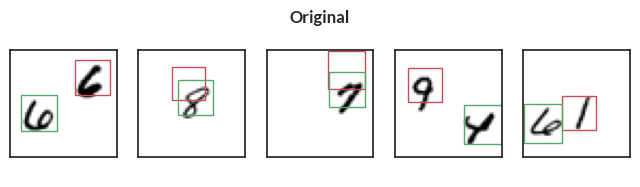

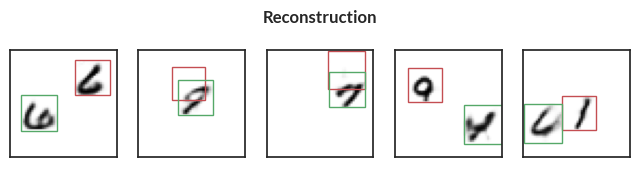

Epoch=14, total_epoch_step_time=61.16, loss=626.98
accuracy=0.7787833213806152, counts=[[19928    20     0     0]
 [    3  6963 13051     3]
 [    0   179 19836    17]]


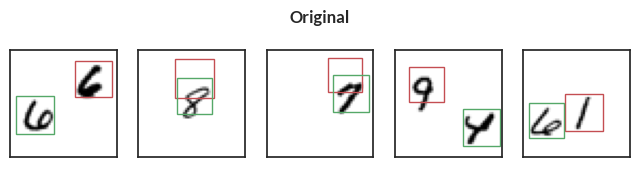

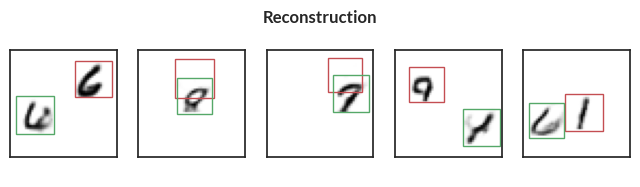

Epoch=15, total_epoch_step_time=65.24, loss=626.81
accuracy=0.781499981880188, counts=[[19925    23     0     0]
 [    1  7128 12891     0]
 [    1   185 19837     9]]


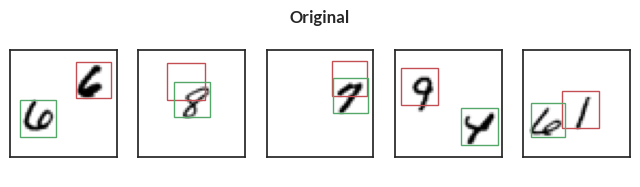

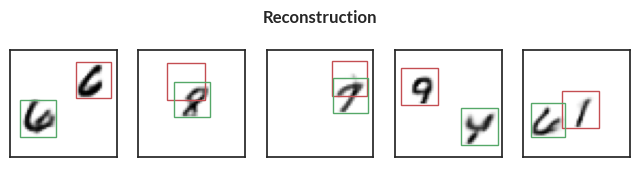

Epoch=16, total_epoch_step_time=69.31, loss=627.79
accuracy=0.7822999954223633, counts=[[19911    37     0     0]
 [    2  7232 12786     0]
 [    3   230 19795     4]]


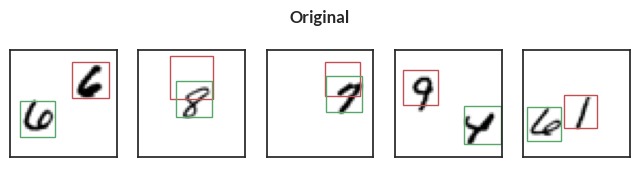

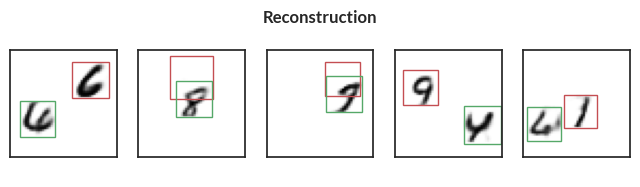

Epoch=17, total_epoch_step_time=73.38, loss=628.39
accuracy=0.7809333205223083, counts=[[19922    26     0     0]
 [    2  7140 12877     1]
 [    2   225 19794    11]]


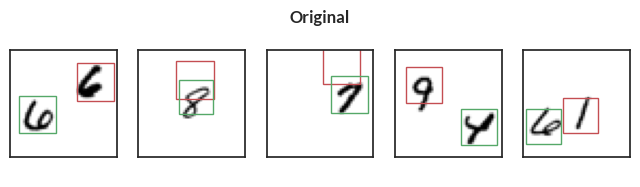

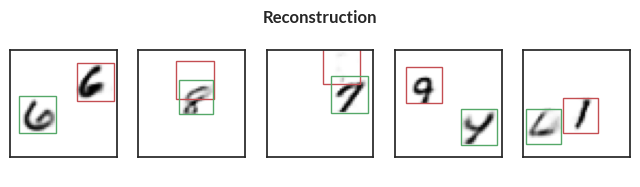

Epoch=18, total_epoch_step_time=77.45, loss=628.87
accuracy=0.770966649055481, counts=[[19910    38     0     0]
 [    2  6503 13513     2]
 [    2   180 19845     5]]


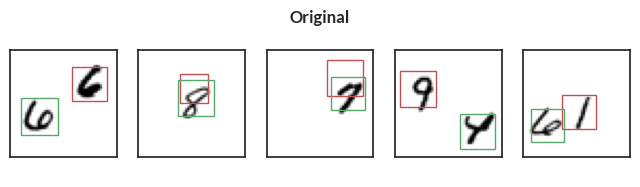

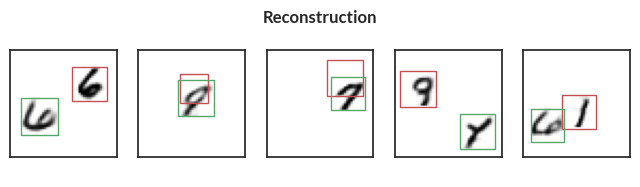

Epoch=19, total_epoch_step_time=81.52, loss=628.68
accuracy=0.7677666544914246, counts=[[19901    47     0     0]
 [    3  6327 13689     1]
 [    2   189 19838     3]]


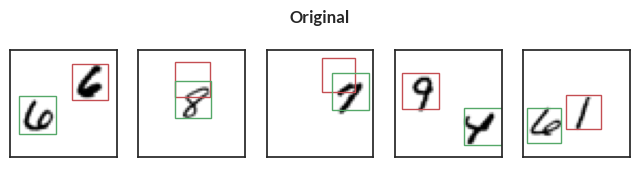

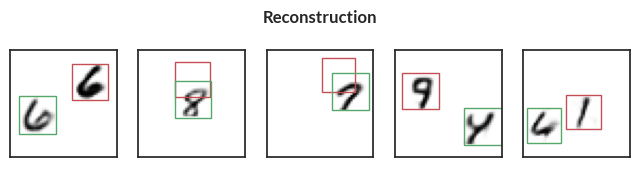

Epoch=20, total_epoch_step_time=85.59, loss=629.23
accuracy=0.768750011920929, counts=[[19923    25     0     0]
 [    0  6416 13604     0]
 [    2   236 19786     8]]


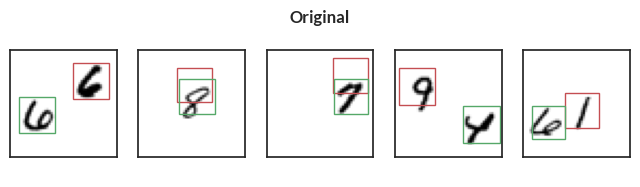

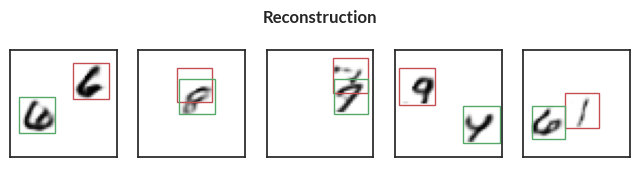

Epoch=21, total_epoch_step_time=89.67, loss=628.59
accuracy=0.7563833594322205, counts=[[19900    48     0     0]
 [    1  5589 14429     1]
 [    1   128 19894     9]]


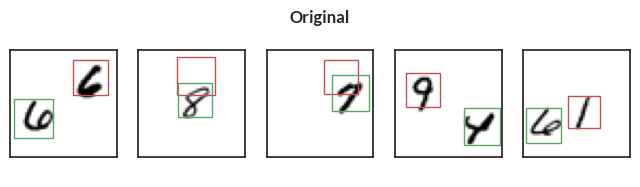

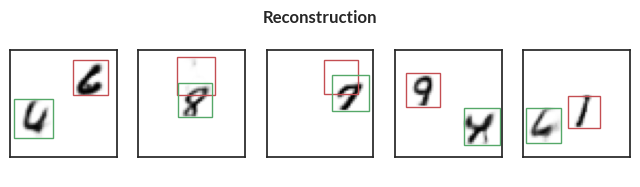

Epoch=22, total_epoch_step_time=93.74, loss=629.51
accuracy=0.755383312702179, counts=[[19891    57     0     0]
 [    1  5599 14419     1]
 [    0   192 19833     7]]


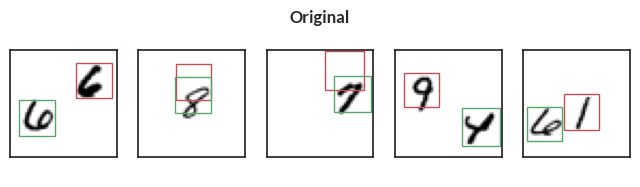

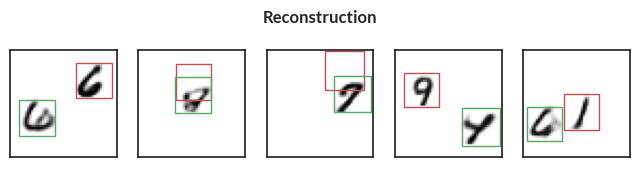

Epoch=23, total_epoch_step_time=97.81, loss=629.91
accuracy=0.7542999982833862, counts=[[19879    69     0     0]
 [    0  5513 14507     0]
 [    2   156 19866     8]]


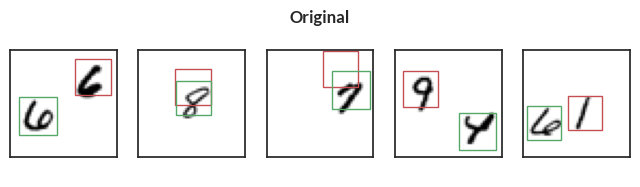

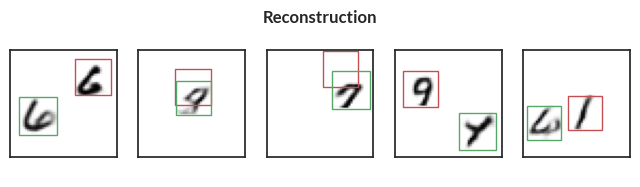

Epoch=24, total_epoch_step_time=101.89, loss=629.99
accuracy=0.7549499869346619, counts=[[19885    63     0     0]
 [    5  5646 14369     0]
 [    1   258 19766     7]]


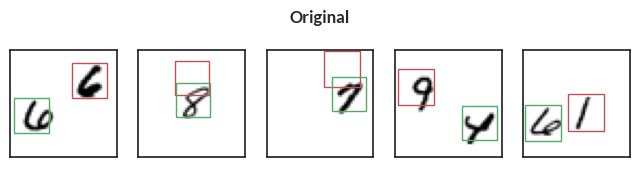

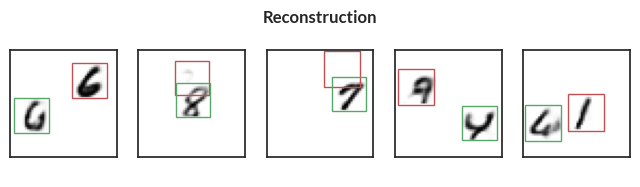

Epoch=25, total_epoch_step_time=105.97, loss=630.15
accuracy=0.7527666687965393, counts=[[19831   117     0     0]
 [    2  5468 14549     1]
 [    1   156 19867     8]]


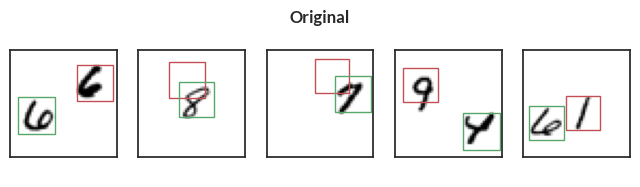

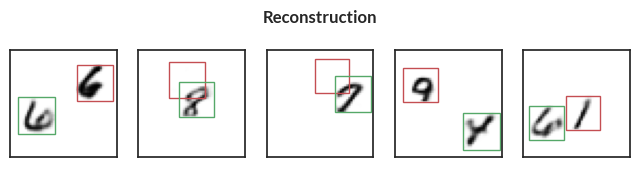

Epoch=26, total_epoch_step_time=110.05, loss=630.20
accuracy=0.7584166526794434, counts=[[19882    66     0     0]
 [    0  5856 14163     1]
 [    2   257 19767     6]]


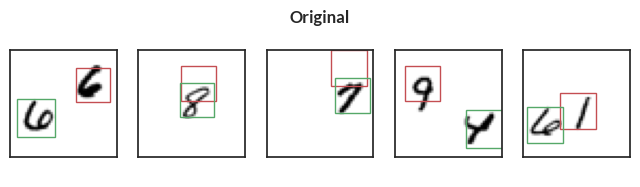

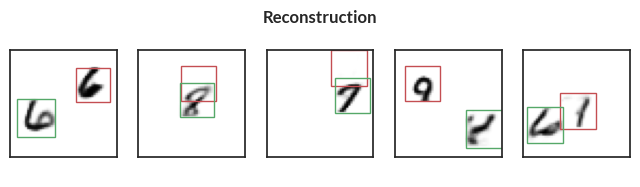

Epoch=27, total_epoch_step_time=114.12, loss=631.06
accuracy=0.7520333528518677, counts=[[19850    98     0     0]
 [    1  5406 14612     1]
 [    4   153 19866     9]]


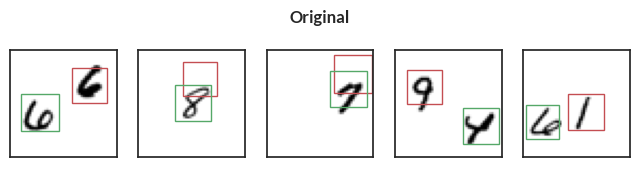

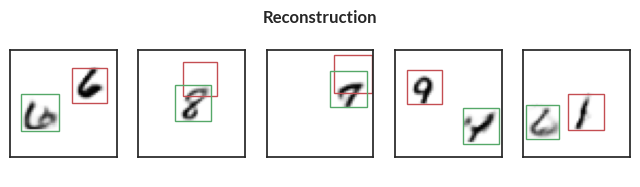

Epoch=28, total_epoch_step_time=118.19, loss=631.59
accuracy=0.7525166869163513, counts=[[19812   136     0     0]
 [    0  5502 14515     3]
 [    3   186 19837     6]]


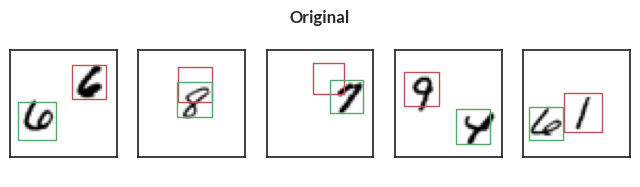

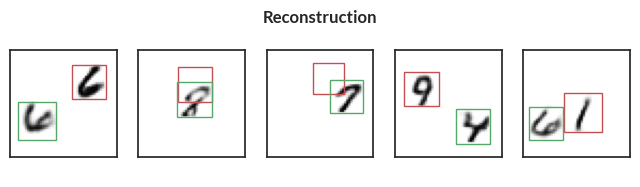

Epoch=29, total_epoch_step_time=122.27, loss=631.85
accuracy=0.7515666484832764, counts=[[19842   106     0     0]
 [    1  5431 14587     1]
 [    1   205 19821     5]]


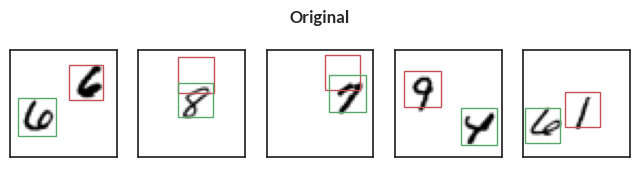

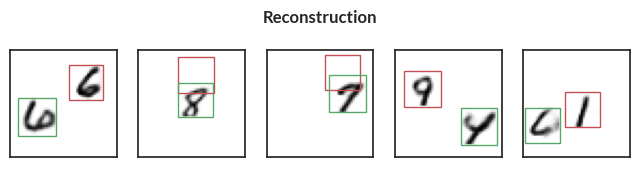

Epoch=30, total_epoch_step_time=126.35, loss=632.39
accuracy=0.7532666921615601, counts=[[19888    60     0     0]
 [    4  5431 14584     1]
 [    3   139 19877    13]]


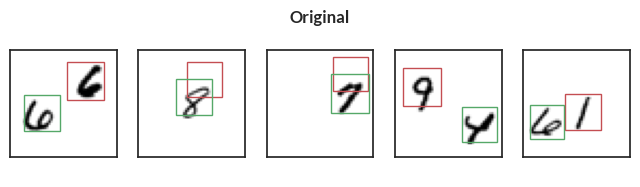

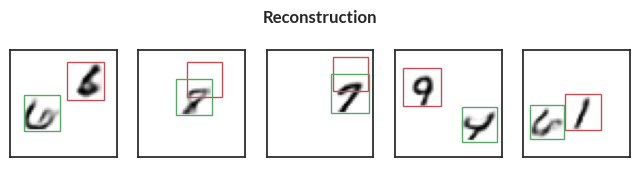

Epoch=31, total_epoch_step_time=130.42, loss=632.35
accuracy=0.7540166974067688, counts=[[19867    81     0     0]
 [    1  5544 14474     1]
 [    1   182 19830    19]]


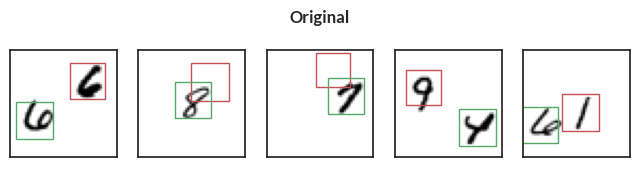

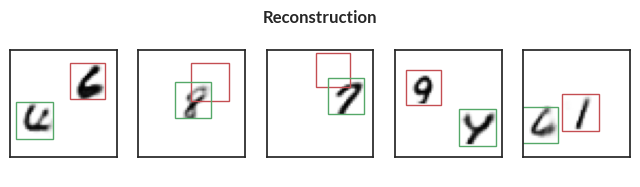

Epoch=32, total_epoch_step_time=134.50, loss=632.49
accuracy=0.7557666897773743, counts=[[19837   111     0     0]
 [    2  5664 14354     0]
 [    2   179 19845     6]]


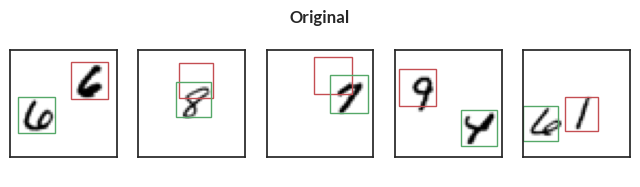

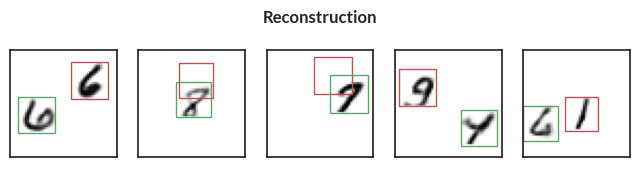

Epoch=33, total_epoch_step_time=138.57, loss=632.45
accuracy=0.749750018119812, counts=[[19777   171     0     0]
 [    3  5360 14657     0]
 [    2   176 19848     6]]


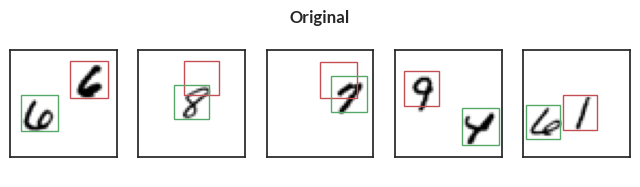

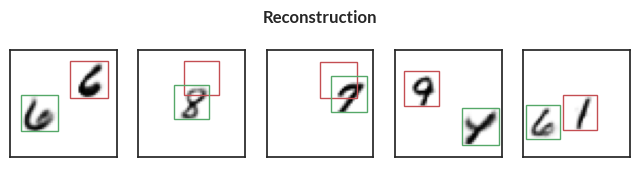

Epoch=34, total_epoch_step_time=142.64, loss=633.07
accuracy=0.7516166567802429, counts=[[19830   118     0     0]
 [    0  5419 14600     1]
 [    4   177 19848     3]]


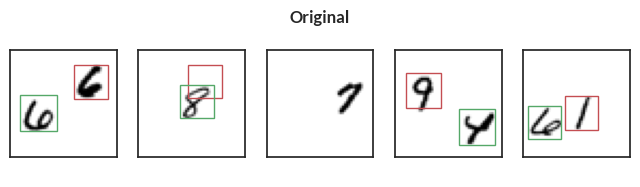

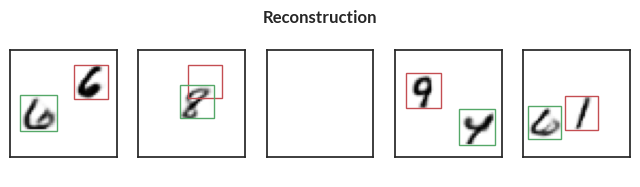

Epoch=35, total_epoch_step_time=146.71, loss=633.12
accuracy=0.7481833696365356, counts=[[19764   184     0     0]
 [    1  5274 14744     1]
 [    2   170 19853     7]]


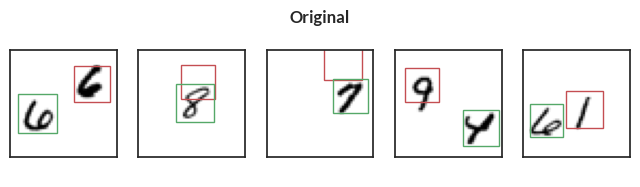

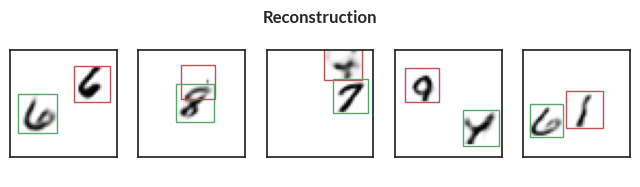

Epoch=36, total_epoch_step_time=150.79, loss=633.22
accuracy=0.7513333559036255, counts=[[19838   110     0     0]
 [    2  5405 14612     1]
 [    2   188 19837     5]]


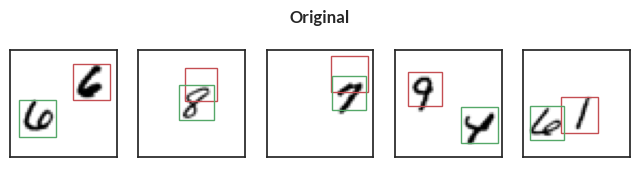

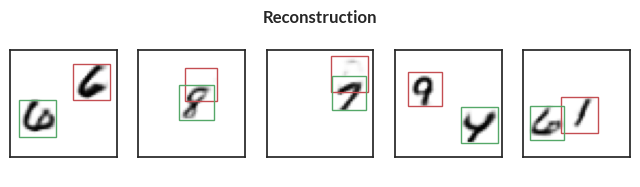

Epoch=37, total_epoch_step_time=154.86, loss=633.32
accuracy=0.7486833333969116, counts=[[19821   127     0     0]
 [    2  5281 14737     0]
 [    3   206 19819     4]]


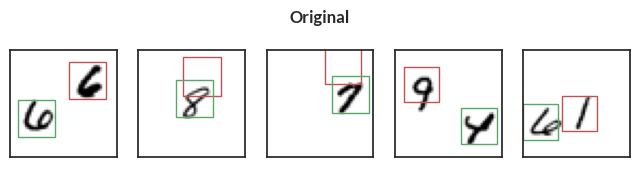

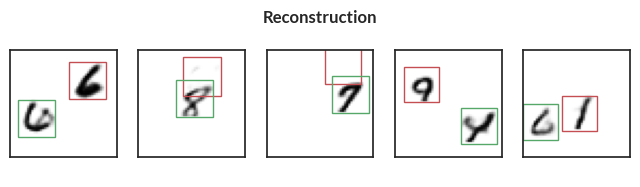

Epoch=38, total_epoch_step_time=158.93, loss=633.52
accuracy=0.7487833499908447, counts=[[19813   135     0     0]
 [    1  5305 14713     1]
 [    0   217 19809     6]]


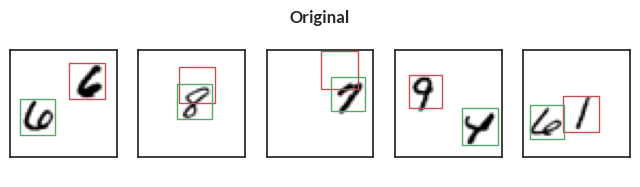

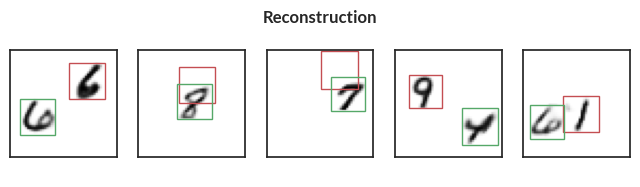

Epoch=39, total_epoch_step_time=163.00, loss=633.44
accuracy=0.7469333410263062, counts=[[19787   161     0     0]
 [    1  5182 14832     5]
 [    3   171 19847    11]]


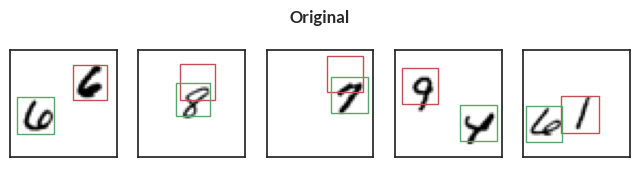

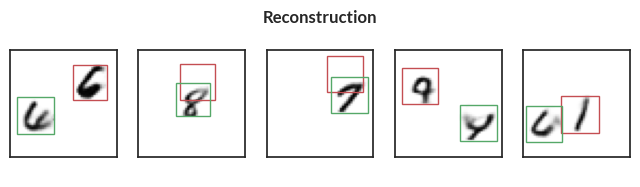

Epoch=40, total_epoch_step_time=167.08, loss=634.10
accuracy=0.7522833347320557, counts=[[19850    98     0     0]
 [    2  5456 14562     0]
 [    2   196 19831     3]]


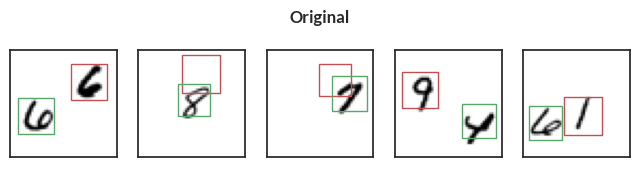

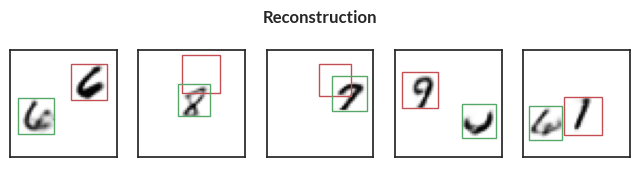

Epoch=41, total_epoch_step_time=171.15, loss=633.52
accuracy=0.7458333373069763, counts=[[19837   111     0     0]
 [    2  5065 14952     1]
 [    4   177 19848     3]]


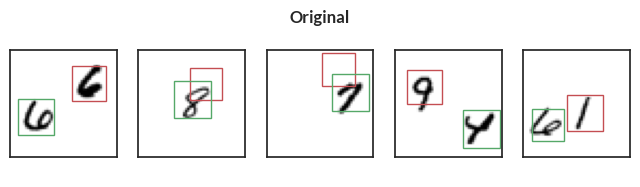

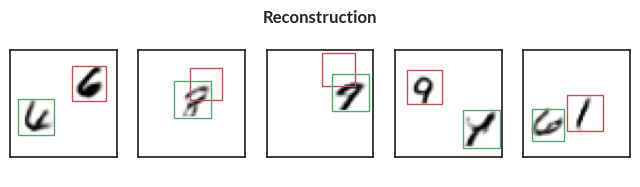

Epoch=42, total_epoch_step_time=175.23, loss=634.23
accuracy=0.7493166923522949, counts=[[19868    80     0     0]
 [    3  5283 14733     1]
 [    1   218 19808     5]]


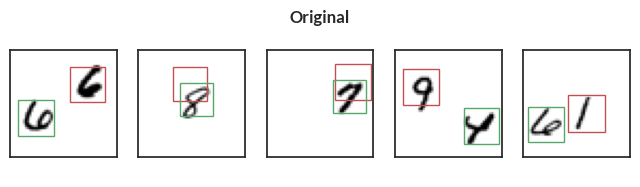

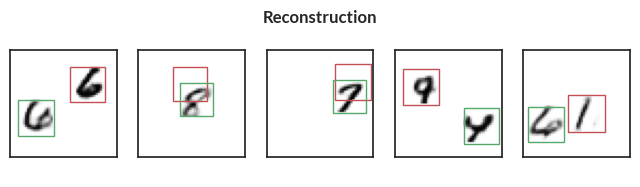

Epoch=43, total_epoch_step_time=179.29, loss=634.45
accuracy=0.7494166493415833, counts=[[19817   130     1     0]
 [    2  5303 14713     2]
 [    2   181 19845     4]]


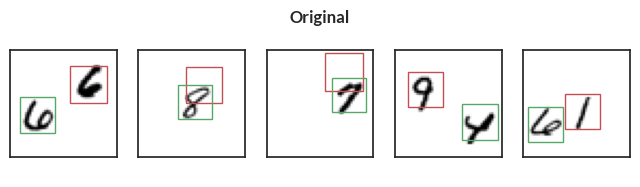

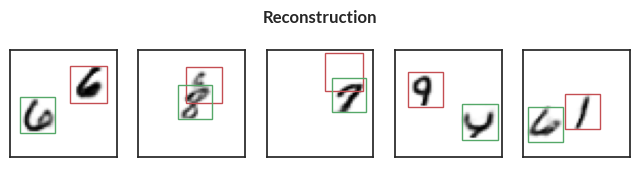

Epoch=44, total_epoch_step_time=183.37, loss=634.68
accuracy=0.7484833598136902, counts=[[19819   129     0     0]
 [    1  5235 14782     2]
 [    1   174 19855     2]]


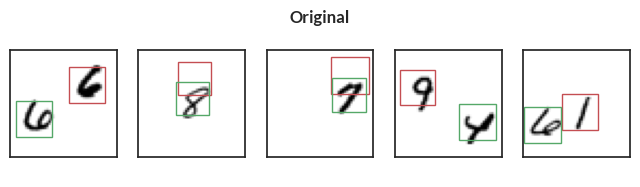

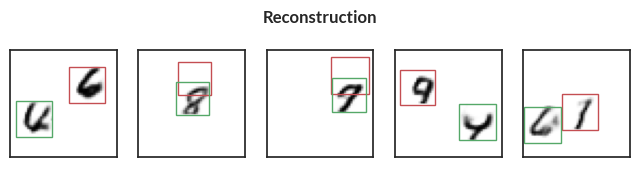

Epoch=45, total_epoch_step_time=187.45, loss=634.29
accuracy=0.7508666515350342, counts=[[19693   255     0     0]
 [    1  5485 14532     2]
 [    2   145 19874    11]]


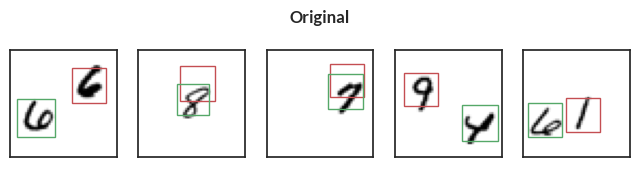

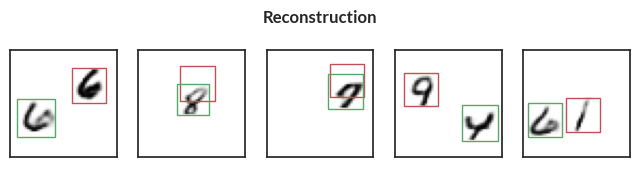

Epoch=46, total_epoch_step_time=191.54, loss=634.78
accuracy=0.7523500323295593, counts=[[19746   202     0     0]
 [    2  5553 14465     0]
 [    2   183 19842     5]]


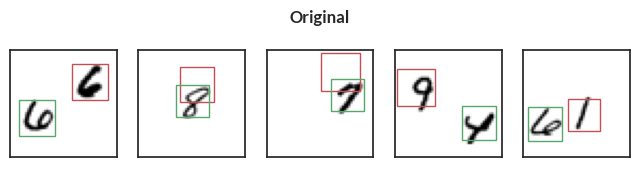

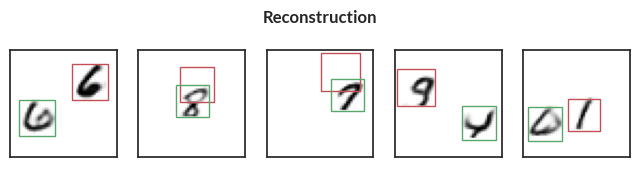

Epoch=47, total_epoch_step_time=195.62, loss=635.16
accuracy=0.7542333602905273, counts=[[19828   120     0     0]
 [    3  5610 14407     0]
 [    3   208 19816     5]]


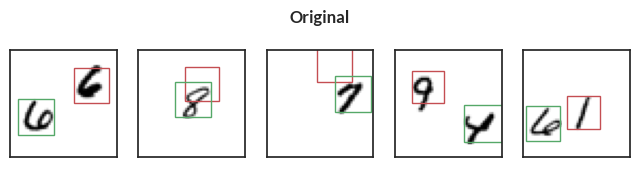

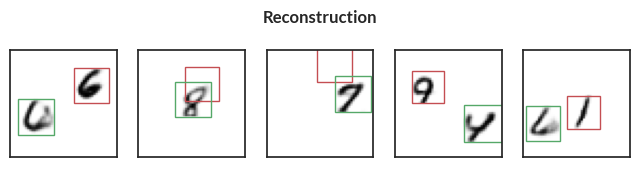

Epoch=48, total_epoch_step_time=199.70, loss=634.76
accuracy=0.7530333399772644, counts=[[19755   193     0     0]
 [    1  5589 14428     2]
 [    1   191 19838     2]]


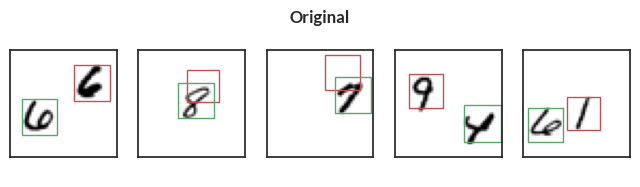

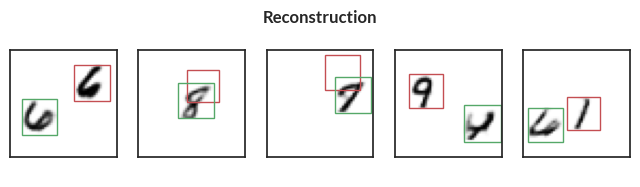

Epoch=49, total_epoch_step_time=203.78, loss=635.27
accuracy=0.7547500133514404, counts=[[19690   258     0     0]
 [    2  5757 14261     0]
 [    1   190 19838     3]]


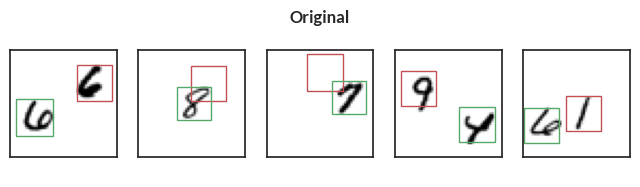

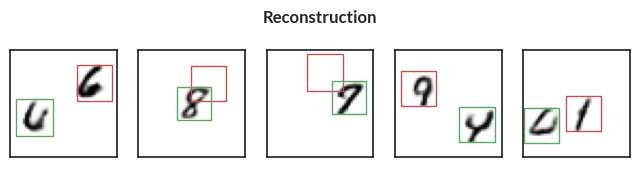

Epoch=50, total_epoch_step_time=207.85, loss=635.63
accuracy=0.7555666565895081, counts=[[19802   146     0     0]
 [    0  5672 14348     0]
 [    5   164 19860     3]]


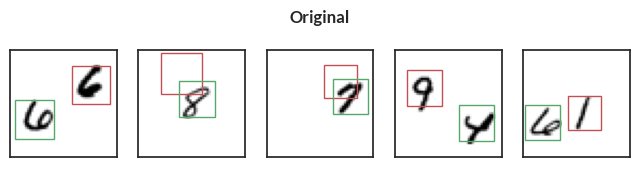

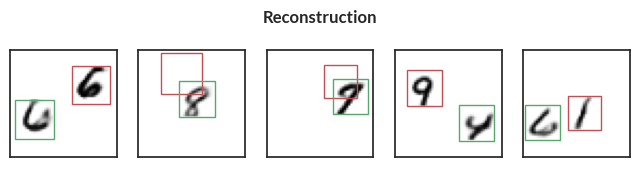

Epoch=51, total_epoch_step_time=211.92, loss=635.34
accuracy=0.756850004196167, counts=[[19770   178     0     0]
 [    1  5806 14212     1]
 [    2   192 19835     3]]


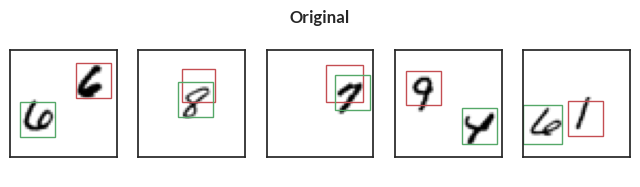

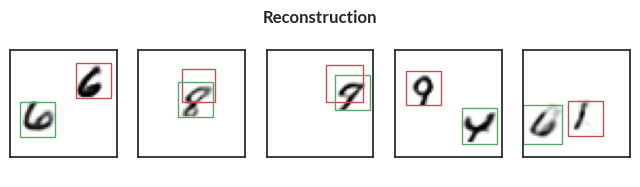

Epoch=52, total_epoch_step_time=216.00, loss=635.64
accuracy=0.7526833415031433, counts=[[19758   190     0     0]
 [    1  5561 14456     2]
 [    2   183 19842     5]]


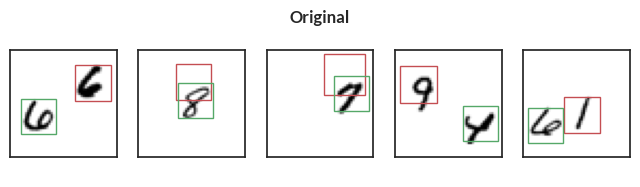

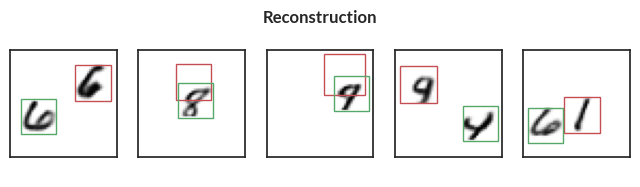

Epoch=53, total_epoch_step_time=220.07, loss=635.37
accuracy=0.7524999976158142, counts=[[19749   199     0     0]
 [    1  5593 14425     1]
 [    1   222 19808     1]]


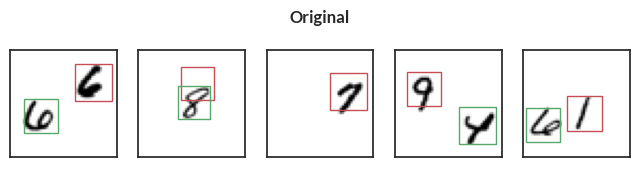

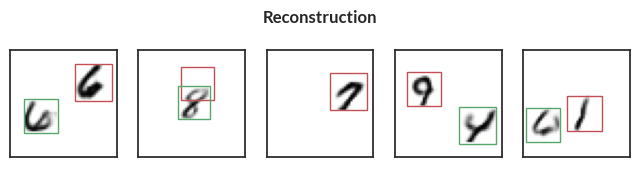

Epoch=54, total_epoch_step_time=224.15, loss=634.55
accuracy=0.75204998254776, counts=[[19758   190     0     0]
 [    2  5522 14495     1]
 [    2   181 19843     6]]


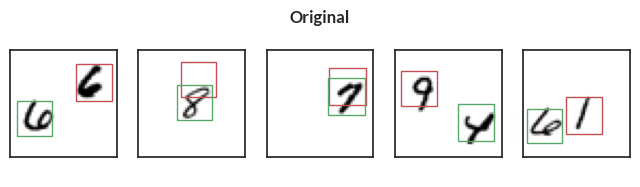

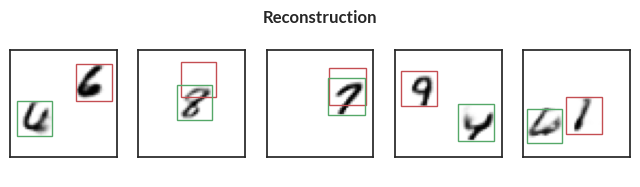

Epoch=55, total_epoch_step_time=228.22, loss=636.05
accuracy=0.7510833144187927, counts=[[19725   223     0     0]
 [    4  5489 14525     2]
 [    2   177 19851     2]]


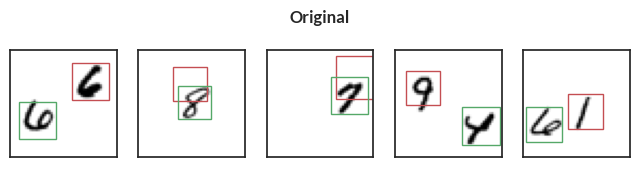

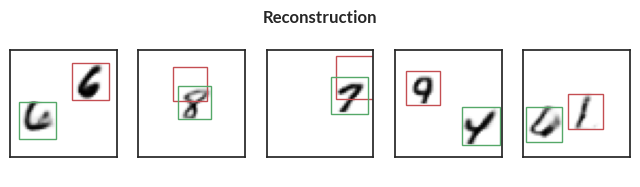

Epoch=56, total_epoch_step_time=232.30, loss=636.15
accuracy=0.7505500316619873, counts=[[19736   212     0     0]
 [    0  5456 14563     1]
 [    2   186 19841     3]]


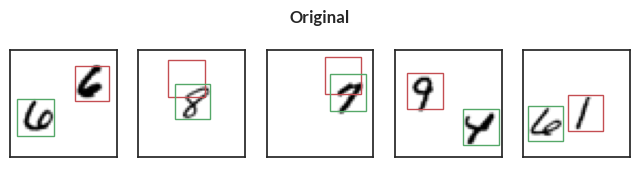

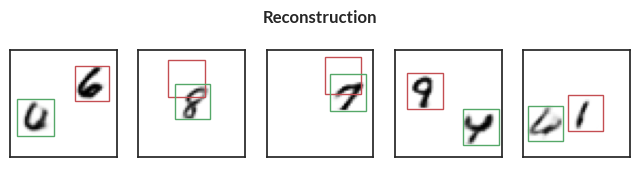

Epoch=57, total_epoch_step_time=236.37, loss=636.18
accuracy=0.7505500316619873, counts=[[19840   108     0     0]
 [    4  5363 14652     1]
 [    3   195 19830     4]]


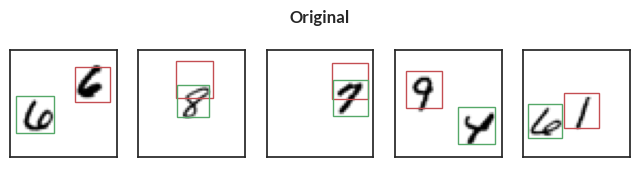

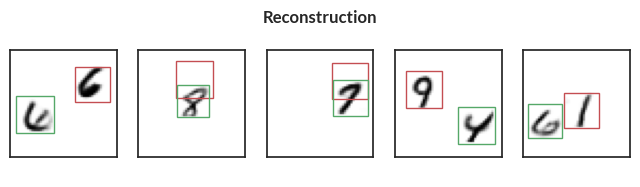

Epoch=58, total_epoch_step_time=240.44, loss=636.02
accuracy=0.7444833517074585, counts=[[19581   367     0     0]
 [    2  5240 14776     2]
 [    3   177 19848     4]]


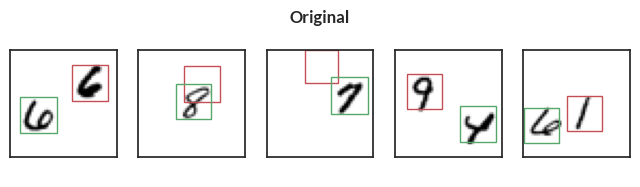

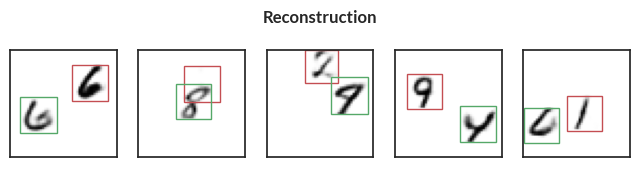

Epoch=59, total_epoch_step_time=244.52, loss=636.65
accuracy=0.7508167028427124, counts=[[19853    95     0     0]
 [    1  5348 14670     1]
 [    3   175 19848     6]]


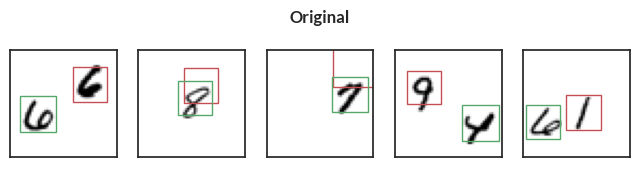

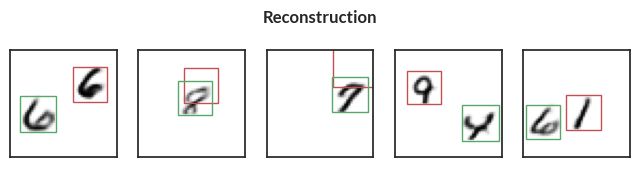

Epoch=60, total_epoch_step_time=248.60, loss=636.17
accuracy=0.7518333196640015, counts=[[19742   205     1     0]
 [    1  5536 14482     1]
 [    3   191 19832     6]]


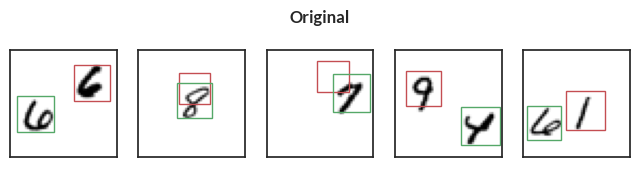

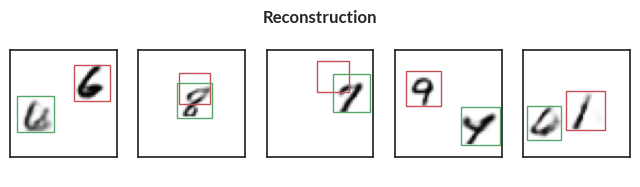

Epoch=61, total_epoch_step_time=252.67, loss=636.37
accuracy=0.7494000196456909, counts=[[19680   267     1     0]
 [    1  5446 14571     2]
 [    3   186 19838     5]]


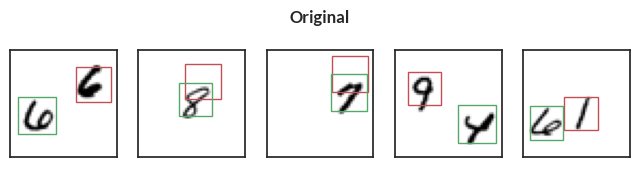

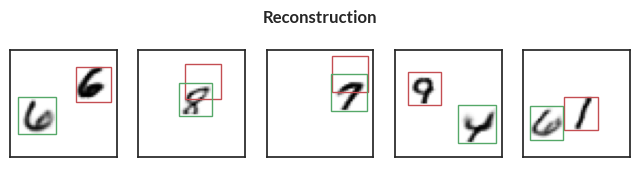

Epoch=62, total_epoch_step_time=256.74, loss=636.19
accuracy=0.7508167028427124, counts=[[19719   229     0     0]
 [    4  5484 14531     1]
 [    3   180 19846     3]]


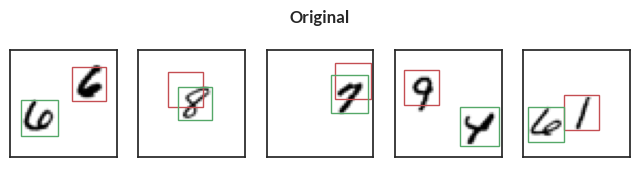

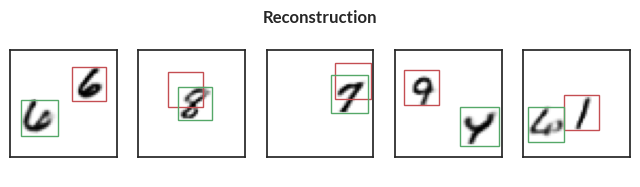

Epoch=63, total_epoch_step_time=260.83, loss=637.01
accuracy=0.7534833550453186, counts=[[19690   258     0     0]
 [    0  5713 14307     0]
 [    2   221 19806     3]]


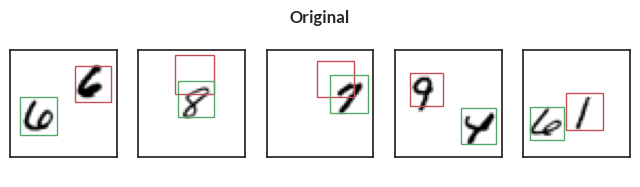

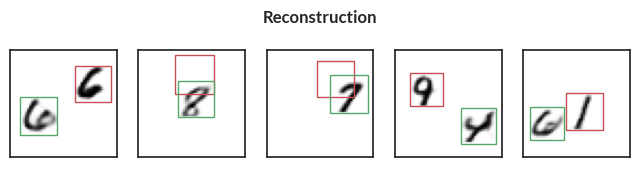

Epoch=64, total_epoch_step_time=264.91, loss=636.48
accuracy=0.7516833543777466, counts=[[19755   193     0     0]
 [    3  5498 14518     1]
 [    1   180 19848     3]]


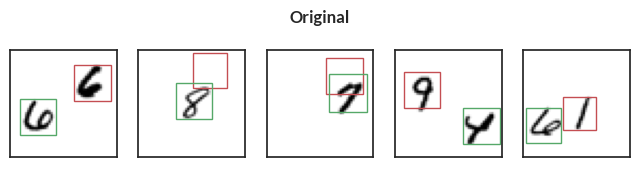

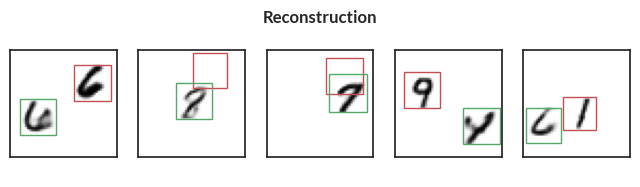

Epoch=65, total_epoch_step_time=268.99, loss=636.25
accuracy=0.7483500242233276, counts=[[19561   387     0     0]
 [    2  5499 14519     0]
 [    0   186 19841     5]]


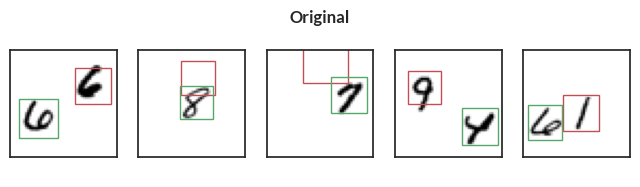

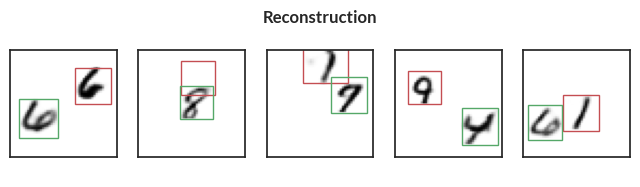

Epoch=66, total_epoch_step_time=273.07, loss=637.02
accuracy=0.7503833174705505, counts=[[19642   306     0     0]
 [    2  5542 14473     3]
 [    0   192 19839     1]]


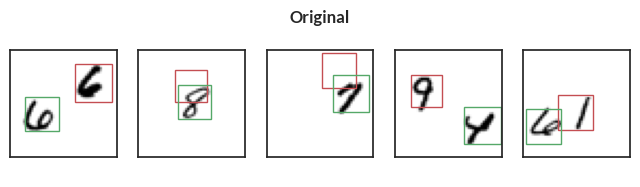

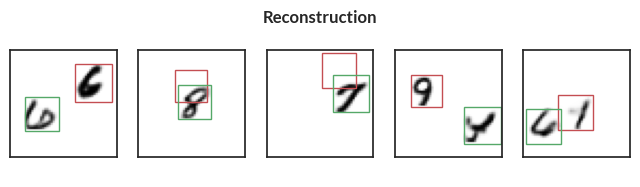

Epoch=67, total_epoch_step_time=277.15, loss=637.33
accuracy=0.7512500286102295, counts=[[19773   175     0     0]
 [    3  5450 14567     0]
 [    1   175 19852     4]]


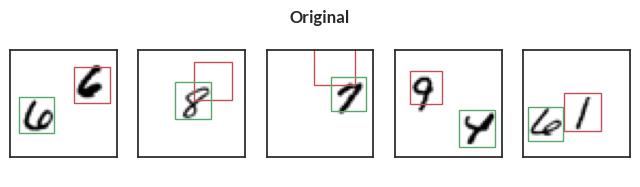

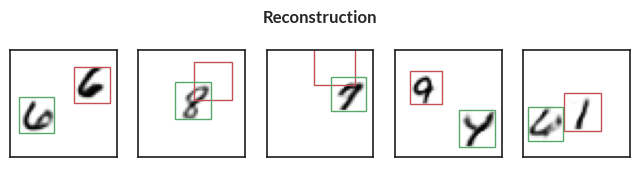

Epoch=68, total_epoch_step_time=281.22, loss=637.15
accuracy=0.7487333416938782, counts=[[19671   277     0     0]
 [    5  5384 14630     1]
 [    3   159 19869     1]]


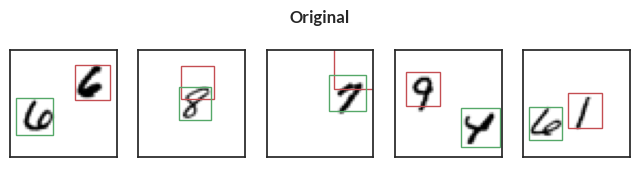

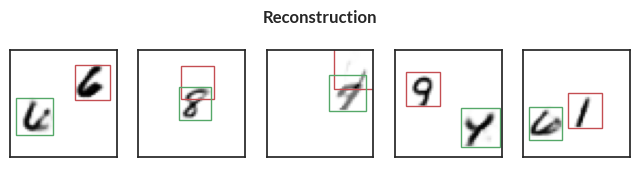

Epoch=69, total_epoch_step_time=285.31, loss=636.56
accuracy=0.7545666694641113, counts=[[19727   221     0     0]
 [    3  5700 14316     1]
 [    1   181 19847     3]]


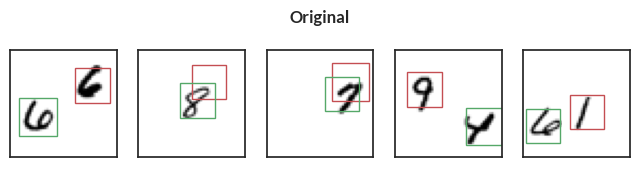

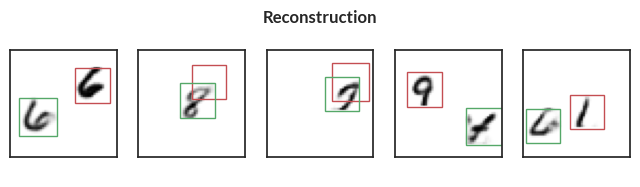

Epoch=70, total_epoch_step_time=289.40, loss=636.81
accuracy=0.7504667043685913, counts=[[19706   242     0     0]
 [    1  5483 14534     2]
 [    0   189 19839     4]]


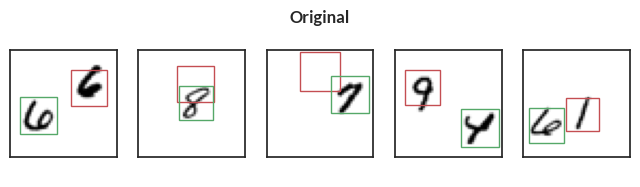

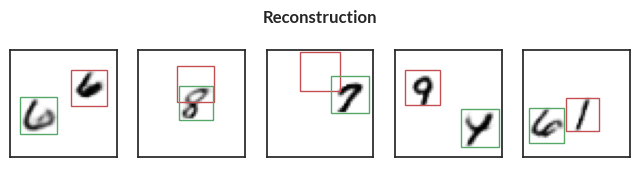

Epoch=71, total_epoch_step_time=293.49, loss=637.54
accuracy=0.748199999332428, counts=[[19599   349     0     0]
 [    3  5453 14561     3]
 [    1   184 19840     7]]


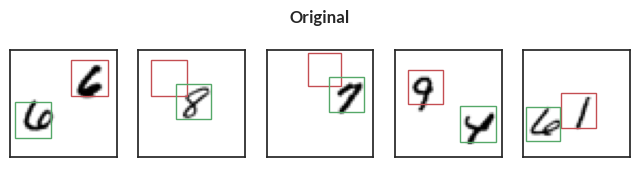

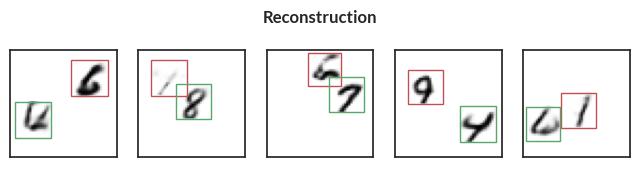

Epoch=72, total_epoch_step_time=297.57, loss=637.46
accuracy=0.7459999918937683, counts=[[19595   352     1     0]
 [    0  5328 14690     2]
 [    4   185 19837     6]]


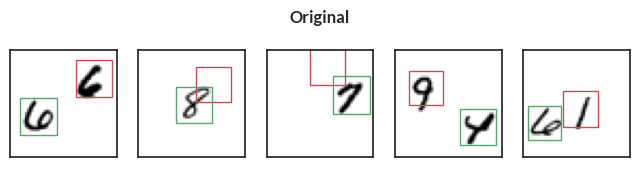

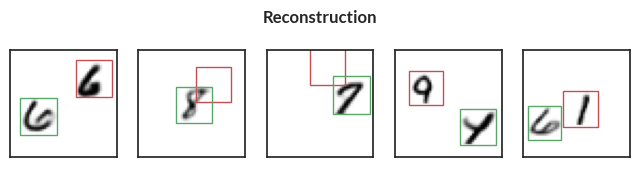

Epoch=73, total_epoch_step_time=301.65, loss=637.35
accuracy=0.7408166527748108, counts=[[19393   555     0     0]
 [    3  5196 14820     1]
 [    2   168 19860     2]]


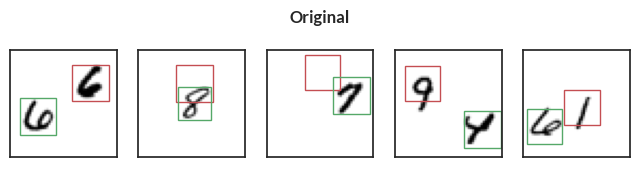

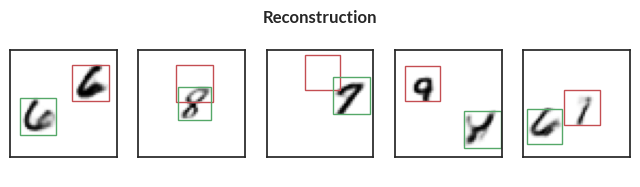

Epoch=74, total_epoch_step_time=305.73, loss=637.26
accuracy=0.7465500235557556, counts=[[19439   509     0     0]
 [    1  5494 14524     1]
 [    2   164 19860     6]]


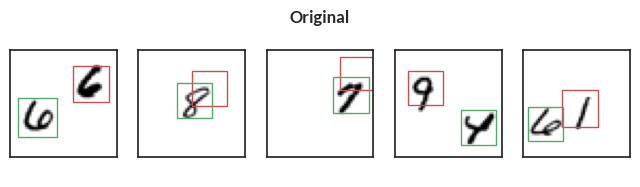

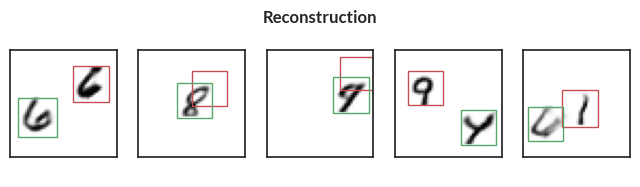

Epoch=75, total_epoch_step_time=309.81, loss=637.63
accuracy=0.7511833310127258, counts=[[19650   298     0     0]
 [    2  5585 14430     3]
 [    2   189 19836     5]]


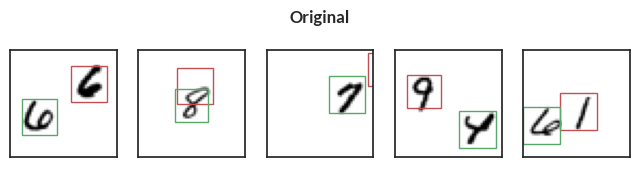

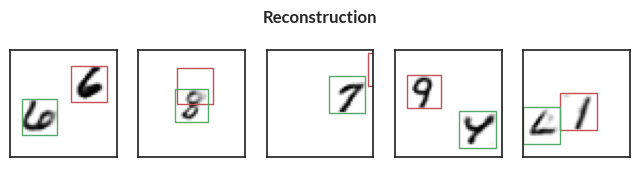

Epoch=76, total_epoch_step_time=313.90, loss=637.55
accuracy=0.7498666644096375, counts=[[19587   361     0     0]
 [    2  5557 14461     0]
 [    4   177 19848     3]]


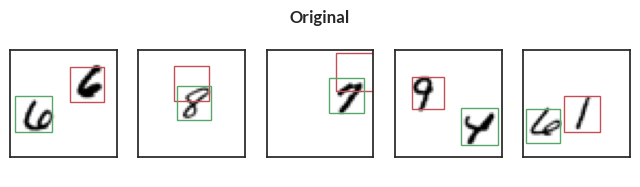

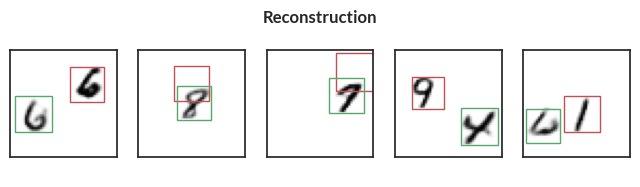

Epoch=77, total_epoch_step_time=317.98, loss=637.13
accuracy=0.7493833303451538, counts=[[19679   269     0     0]
 [    3  5443 14574     0]
 [    2   187 19841     2]]


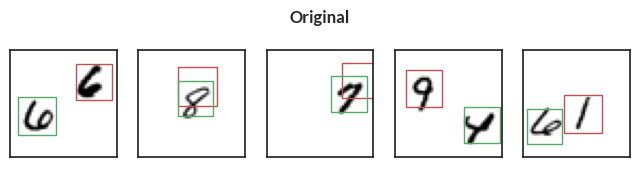

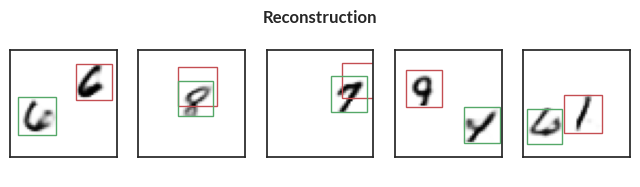

Epoch=78, total_epoch_step_time=322.06, loss=637.82
accuracy=0.7480166554450989, counts=[[19507   441     0     0]
 [    2  5528 14488     2]
 [    2   181 19846     3]]


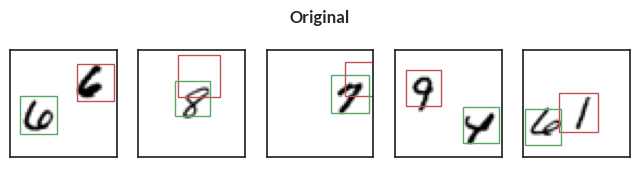

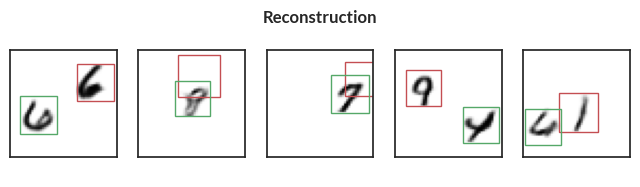

Epoch=79, total_epoch_step_time=326.14, loss=638.10
accuracy=0.751466691493988, counts=[[19669   279     0     0]
 [    2  5581 14435     2]
 [    4   185 19838     5]]


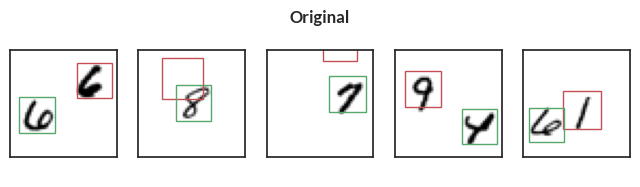

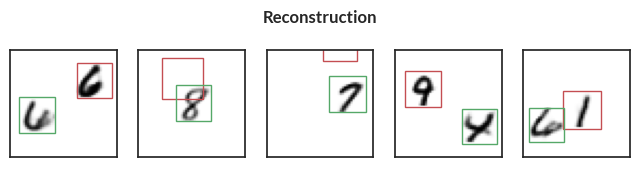

Epoch=80, total_epoch_step_time=330.22, loss=637.87
accuracy=0.7489500045776367, counts=[[19541   407     0     0]
 [    0  5550 14467     3]
 [    0   182 19846     4]]


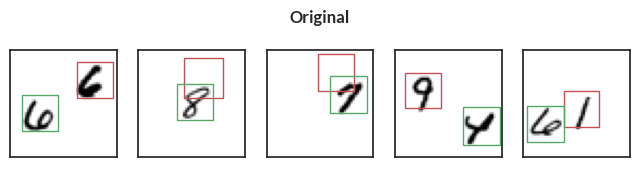

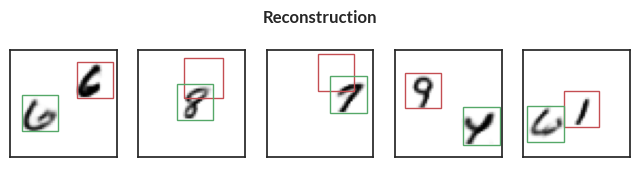

Epoch=81, total_epoch_step_time=334.30, loss=637.88
accuracy=0.75163334608078, counts=[[19710   238     0     0]
 [    1  5543 14476     0]
 [    2   181 19845     4]]


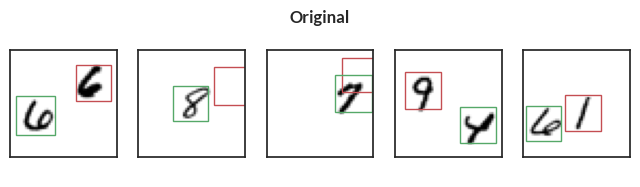

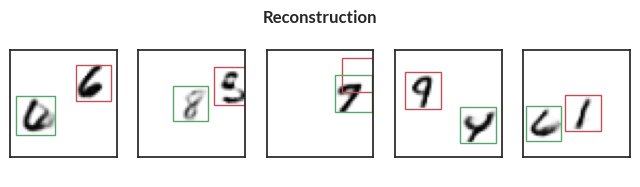

Epoch=82, total_epoch_step_time=338.39, loss=638.14
accuracy=0.751800000667572, counts=[[19649   299     0     0]
 [    0  5613 14407     0]
 [    0   183 19846     3]]


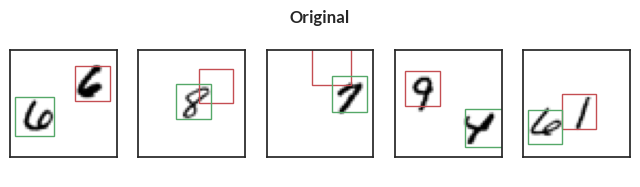

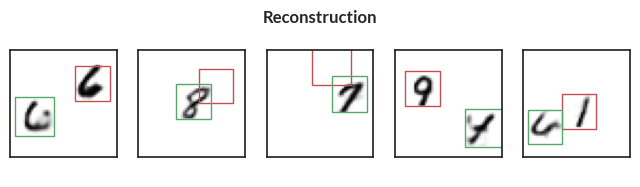

Epoch=83, total_epoch_step_time=342.46, loss=638.45
accuracy=0.7496500015258789, counts=[[19566   381     1     0]
 [    1  5582 14436     1]
 [    0   200 19831     1]]


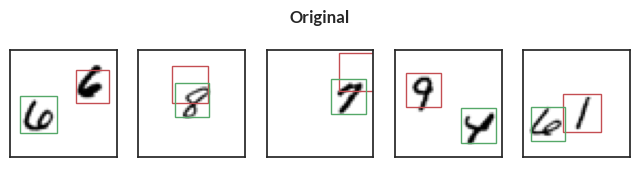

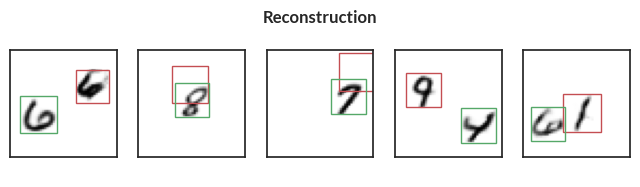

Epoch=84, total_epoch_step_time=346.55, loss=638.43
accuracy=0.7513666749000549, counts=[[19624   324     0     0]
 [    1  5625 14394     0]
 [    2   195 19833     2]]


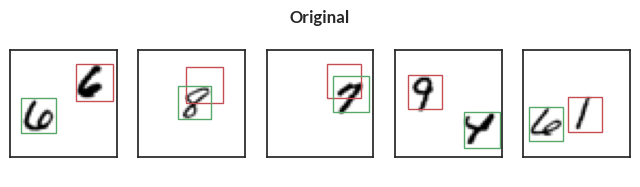

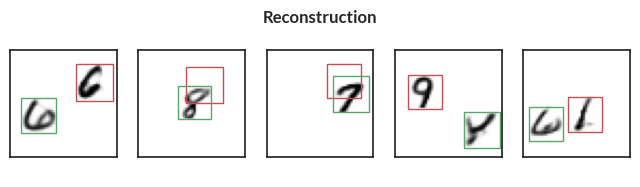

Epoch=85, total_epoch_step_time=350.62, loss=638.77
accuracy=0.7520333528518677, counts=[[19512   436     0     0]
 [    2  5782 14233     3]
 [    2   199 19828     3]]


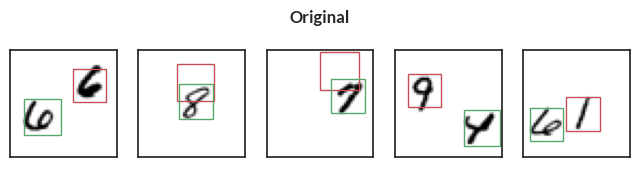

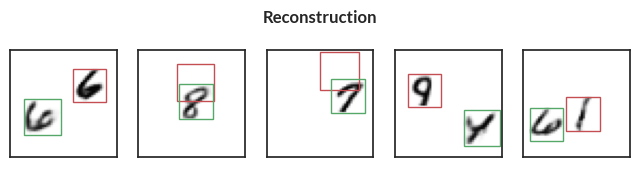

Epoch=86, total_epoch_step_time=354.70, loss=638.52
accuracy=0.7518333196640015, counts=[[19574   373     1     0]
 [    1  5684 14335     0]
 [    3   175 19852     2]]


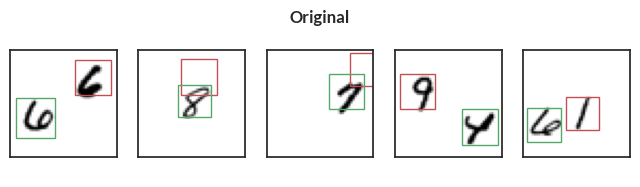

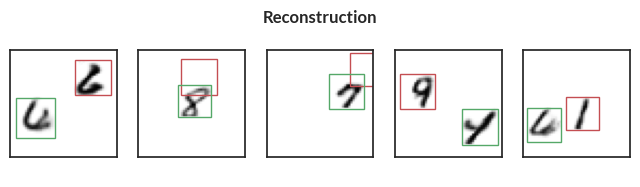

Epoch=87, total_epoch_step_time=358.79, loss=638.44
accuracy=0.7561833262443542, counts=[[19681   267     0     0]
 [    1  5879 14139     1]
 [    4   213 19811     4]]


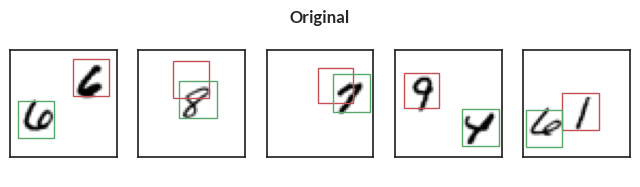

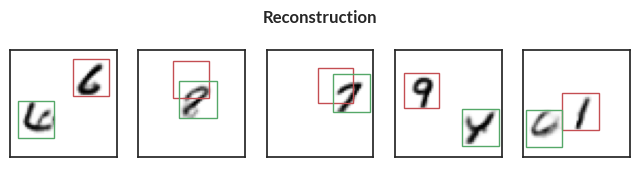

Epoch=88, total_epoch_step_time=362.87, loss=638.38
accuracy=0.7507666945457458, counts=[[19487   461     0     0]
 [    0  5714 14305     1]
 [    1   184 19845     2]]


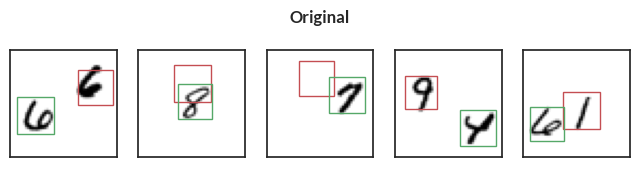

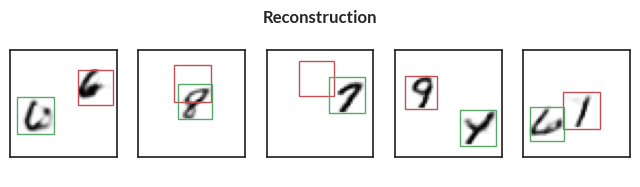

Epoch=89, total_epoch_step_time=366.95, loss=638.53
accuracy=0.7504667043685913, counts=[[19462   486     0     0]
 [    0  5743 14277     0]
 [    0   207 19823     2]]


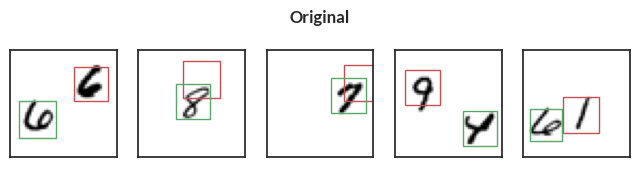

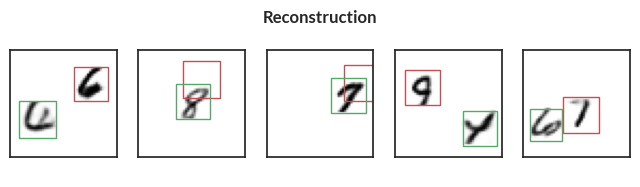

Epoch=90, total_epoch_step_time=371.03, loss=638.36
accuracy=0.7528166770935059, counts=[[19405   543     0     0]
 [    1  5928 14087     4]
 [    3   189 19836     4]]


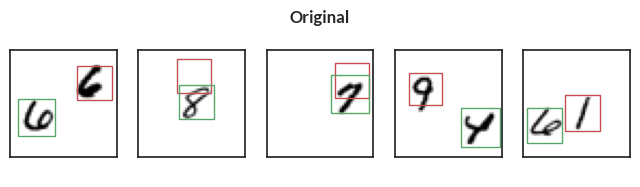

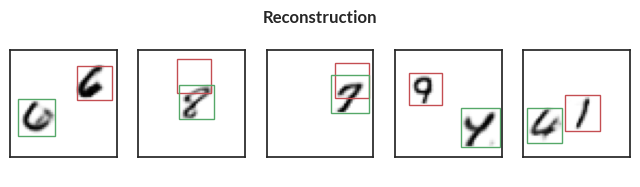

Epoch=91, total_epoch_step_time=375.10, loss=638.85
accuracy=0.7531333565711975, counts=[[19401   547     0     0]
 [    2  5960 14057     1]
 [    1   200 19827     4]]


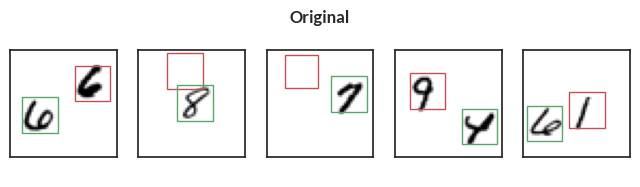

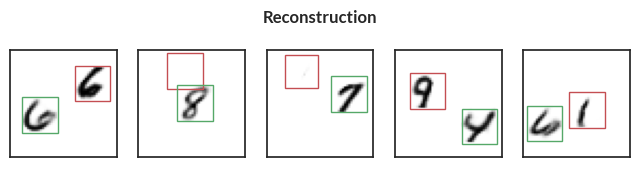

Epoch=92, total_epoch_step_time=379.18, loss=638.51
accuracy=0.7573666572570801, counts=[[19552   396     0     0]
 [    4  6055 13960     1]
 [    4   188 19835     5]]


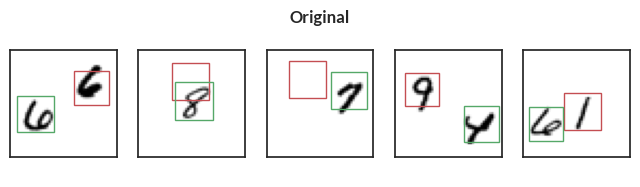

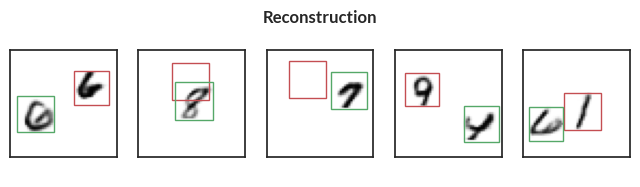

Epoch=93, total_epoch_step_time=383.26, loss=637.99
accuracy=0.7573500275611877, counts=[[19634   314     0     0]
 [    0  5991 14026     3]
 [    2   209 19816     5]]


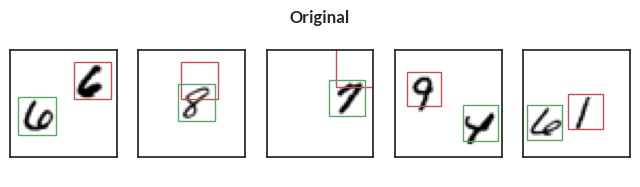

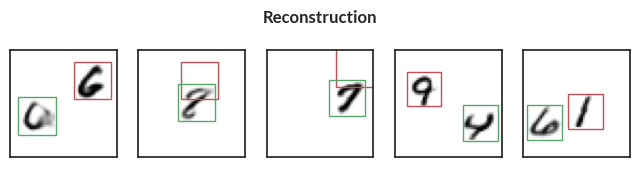

Epoch=94, total_epoch_step_time=387.34, loss=638.71
accuracy=0.7540500164031982, counts=[[19535   413     0     0]
 [    4  5878 14137     1]
 [    2   197 19830     3]]


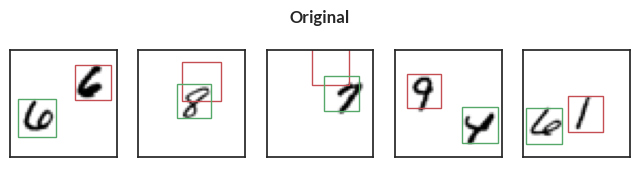

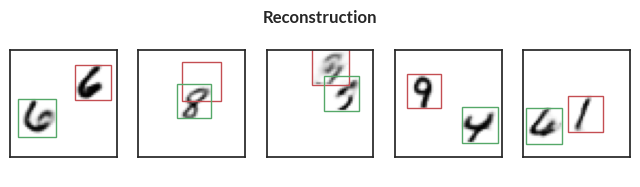

Epoch=95, total_epoch_step_time=391.43, loss=639.16
accuracy=0.7540500164031982, counts=[[19492   456     0     0]
 [    1  5918 14100     1]
 [    2   194 19833     3]]


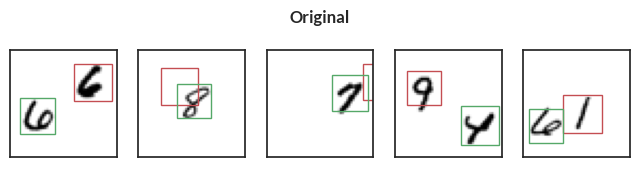

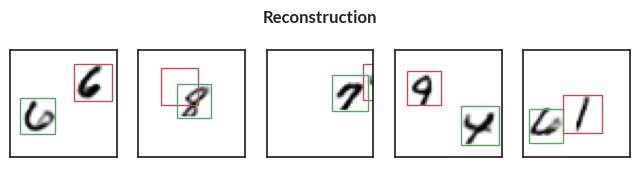

Epoch=96, total_epoch_step_time=395.51, loss=639.47
accuracy=0.7570000290870667, counts=[[19499   449     0     0]
 [    3  6099 13918     0]
 [    1   207 19822     2]]


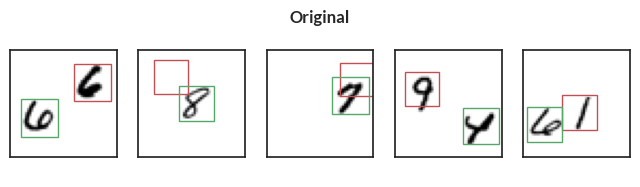

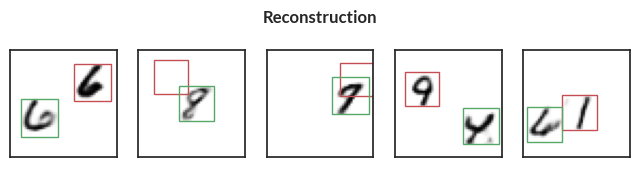

Epoch=97, total_epoch_step_time=399.58, loss=638.78
accuracy=0.7517833709716797, counts=[[19410   538     0     0]
 [    3  5853 14161     3]
 [    3   181 19844     4]]


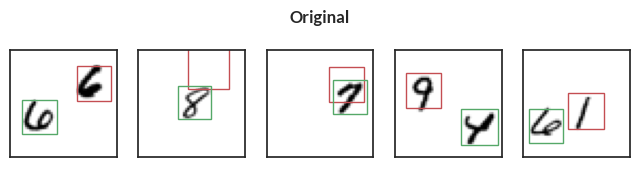

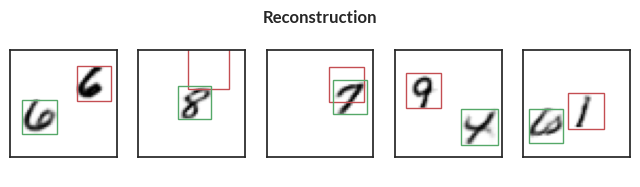

Epoch=98, total_epoch_step_time=403.67, loss=638.85
accuracy=0.7522500157356262, counts=[[19321   627     0     0]
 [    2  5994 14022     2]
 [    4   205 19820     3]]


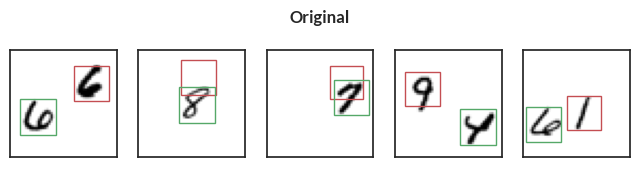

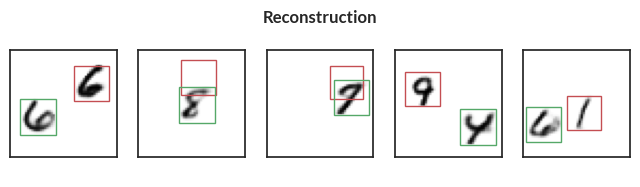

Epoch=99, total_epoch_step_time=407.75, loss=638.09
accuracy=0.752833366394043, counts=[[19406   542     0     0]
 [    3  5926 14090     1]
 [    1   190 19838     3]]


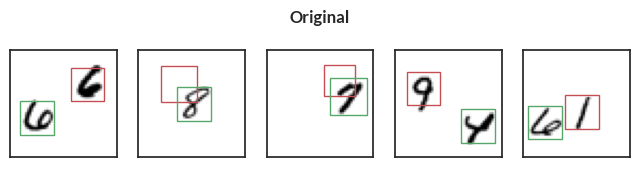

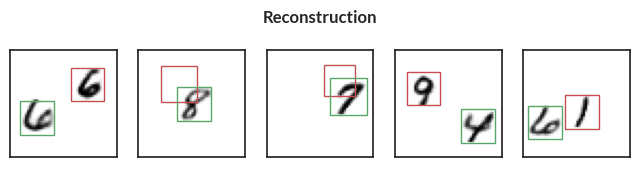

Epoch=100, total_epoch_step_time=411.82, loss=639.18
accuracy=0.7554500102996826, counts=[[19585   363     0     0]
 [    0  5910 14107     3]
 [    0   196 19832     4]]


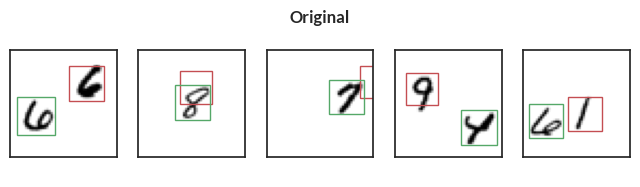

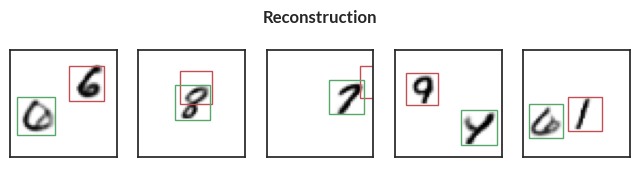

Epoch=101, total_epoch_step_time=415.90, loss=638.88
accuracy=0.7556333541870117, counts=[[19565   382     1     0]
 [    1  5956 14062     1]
 [    0   211 19817     4]]


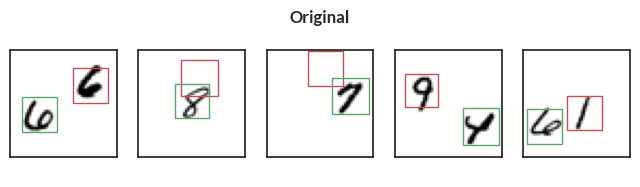

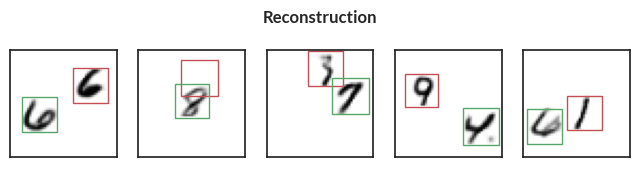

Epoch=102, total_epoch_step_time=419.97, loss=637.82
accuracy=0.751800000667572, counts=[[19373   575     0     0]
 [    3  5922 14095     0]
 [    1   214 19813     4]]


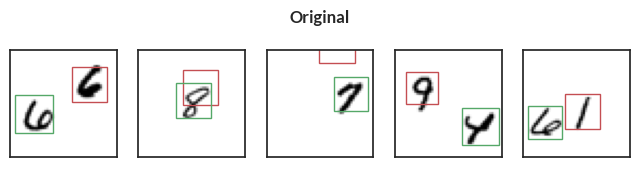

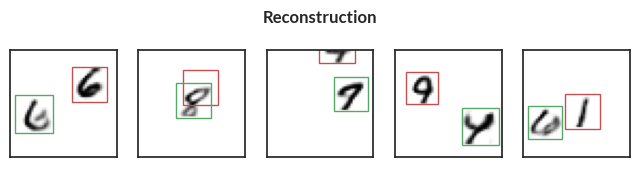

Epoch=103, total_epoch_step_time=424.04, loss=638.95
accuracy=0.7503499984741211, counts=[[19431   517     0     0]
 [    1  5754 14263     2]
 [    3   189 19836     4]]


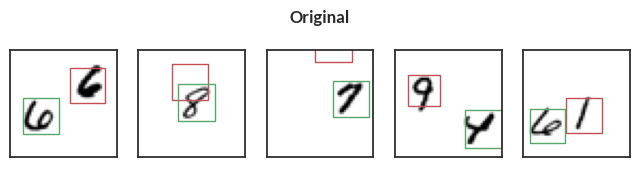

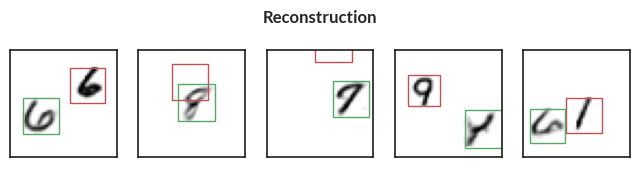

Epoch=104, total_epoch_step_time=428.12, loss=639.20
accuracy=0.7538000345230103, counts=[[19570   378     0     0]
 [    2  5838 14180     0]
 [    1   208 19820     3]]


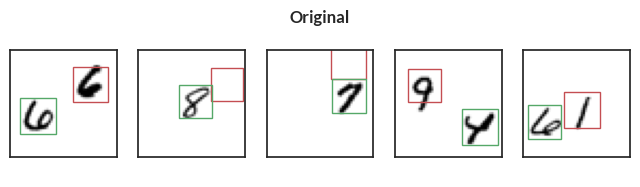

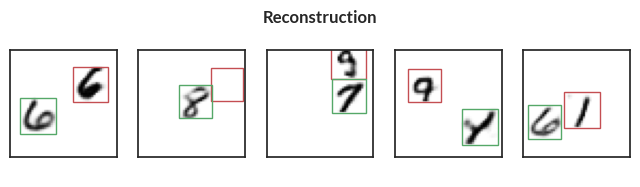

Epoch=105, total_epoch_step_time=432.20, loss=639.41
accuracy=0.7498000264167786, counts=[[19302   646     0     0]
 [    2  5837 14180     1]
 [    0   179 19849     4]]


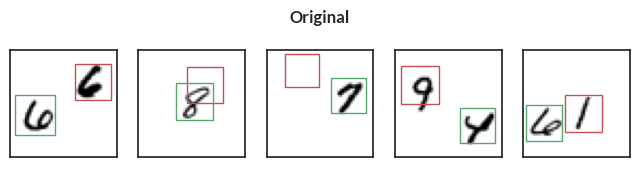

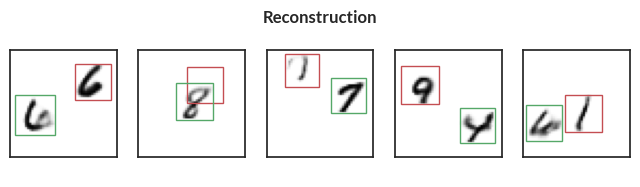

Epoch=106, total_epoch_step_time=436.28, loss=639.35
accuracy=0.7557833194732666, counts=[[19574   374     0     0]
 [    2  5941 14076     1]
 [    0   198 19832     2]]


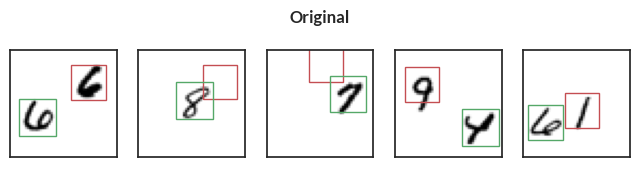

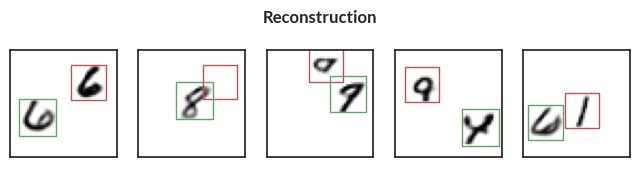

Epoch=107, total_epoch_step_time=440.37, loss=639.73
accuracy=0.7502000331878662, counts=[[19373   575     0     0]
 [    2  5800 14216     2]
 [    1   186 19839     6]]


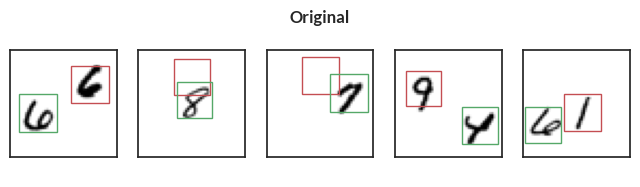

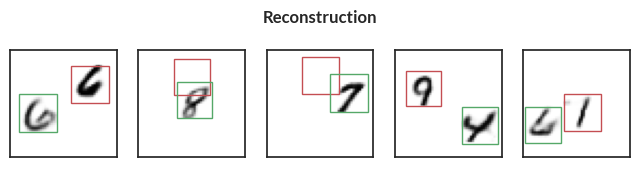

Epoch=108, total_epoch_step_time=444.45, loss=639.14
accuracy=0.7476833462715149, counts=[[19215   733     0     0]
 [    2  5809 14203     6]
 [    4   190 19837     1]]


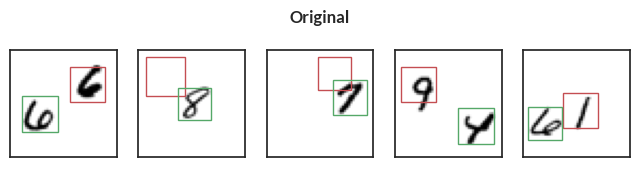

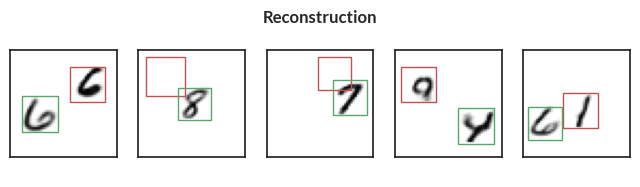

Epoch=109, total_epoch_step_time=448.54, loss=639.85
accuracy=0.75204998254776, counts=[[19527   421     0     0]
 [    2  5772 14245     1]
 [    2   204 19824     2]]


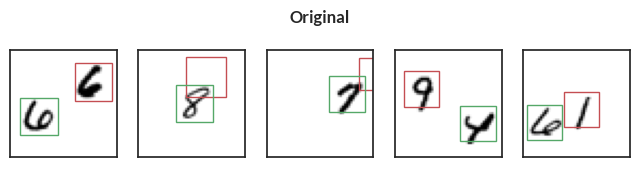

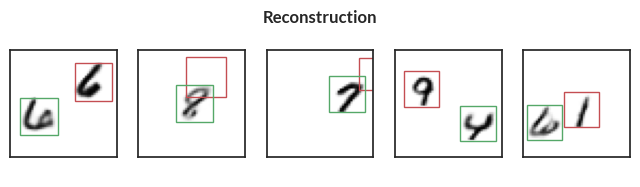

Epoch=110, total_epoch_step_time=452.61, loss=639.38
accuracy=0.7505666613578796, counts=[[19385   563     0     0]
 [    3  5834 14183     0]
 [    3   209 19815     5]]


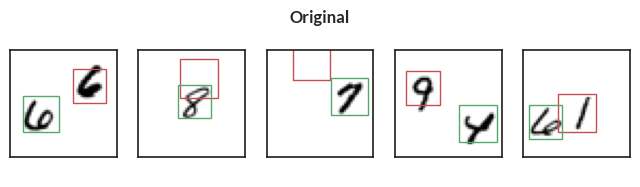

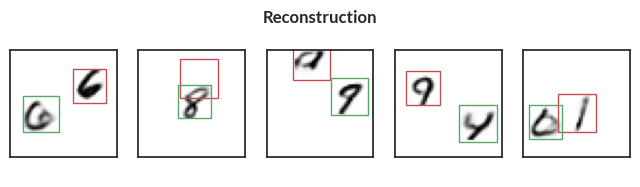

Epoch=111, total_epoch_step_time=456.69, loss=639.57
accuracy=0.7494666576385498, counts=[[19323   625     0     0]
 [    1  5823 14194     2]
 [    2   204 19822     4]]


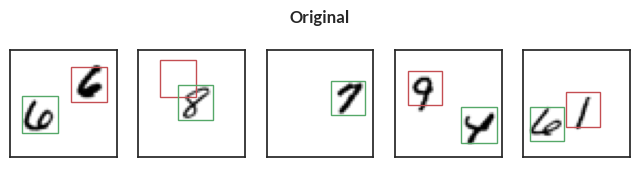

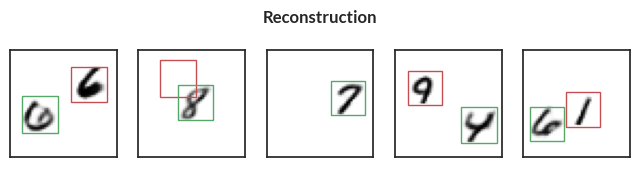

Epoch=112, total_epoch_step_time=460.77, loss=639.76
accuracy=0.7524166703224182, counts=[[19379   569     0     0]
 [    3  5950 14064     3]
 [    1   212 19816     3]]


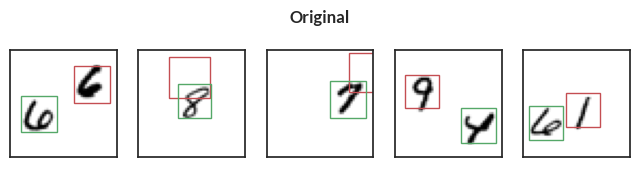

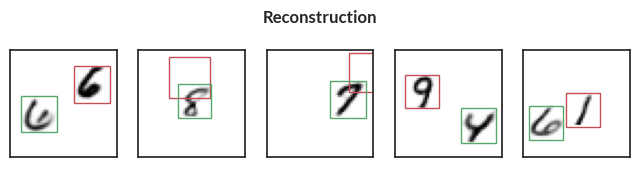

Epoch=113, total_epoch_step_time=464.85, loss=640.03
accuracy=0.7546833157539368, counts=[[19435   513     0     0]
 [    2  6021 13997     0]
 [    1   203 19825     3]]


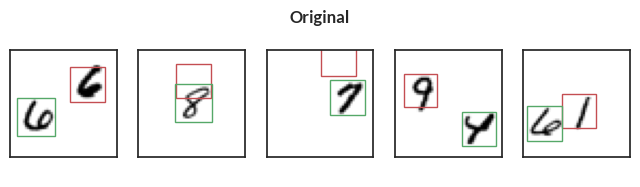

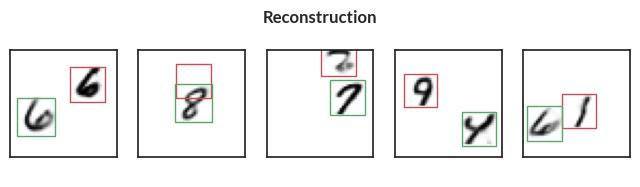

Epoch=114, total_epoch_step_time=468.92, loss=639.41
accuracy=0.7552333474159241, counts=[[19386   562     0     0]
 [    2  6105 13911     2]
 [    3   203 19823     3]]


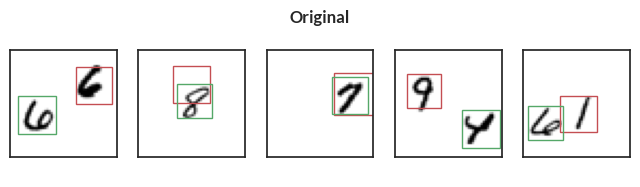

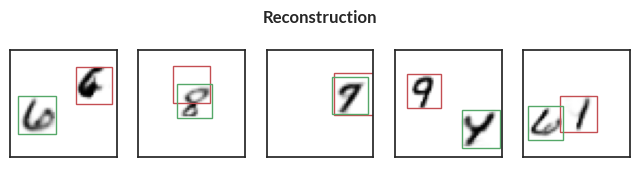

Epoch=115, total_epoch_step_time=472.99, loss=640.11
accuracy=0.7577999830245972, counts=[[19426   522     0     0]
 [    1  6239 13779     1]
 [    5   223 19803     1]]


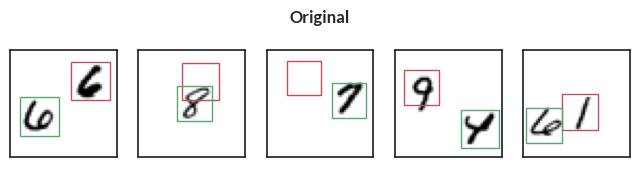

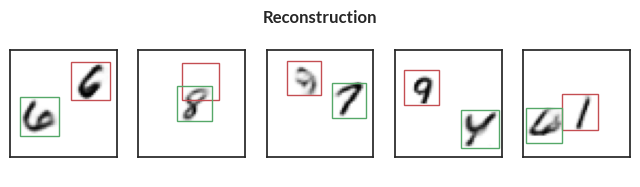

Epoch=116, total_epoch_step_time=477.06, loss=640.01
accuracy=0.7595500349998474, counts=[[19622   326     0     0]
 [    2  6138 13879     1]
 [    2   214 19813     3]]


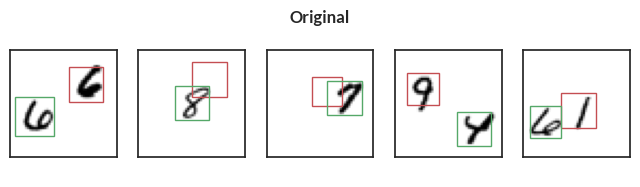

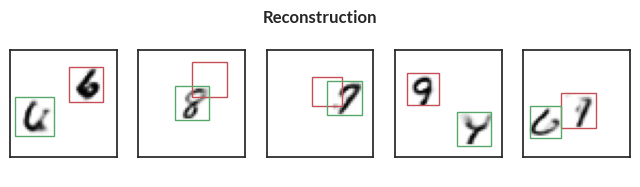

Epoch=117, total_epoch_step_time=481.13, loss=639.75
accuracy=0.7506999969482422, counts=[[19159   789     0     0]
 [    0  6056 13963     1]
 [    0   200 19827     5]]


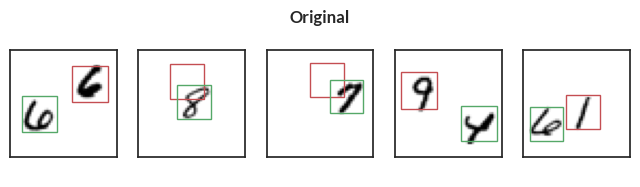

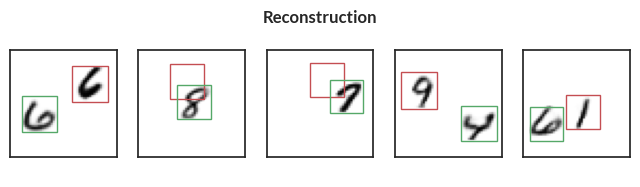

Epoch=118, total_epoch_step_time=485.21, loss=639.24
accuracy=0.7554333209991455, counts=[[19245   703     0     0]
 [    6  6263 13750     1]
 [    0   213 19818     1]]


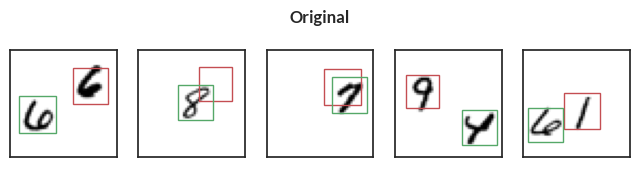

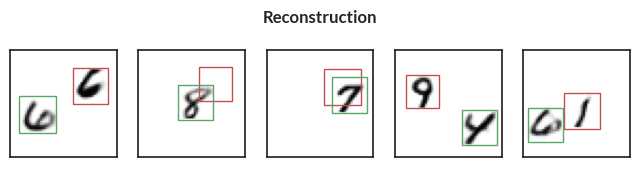

Epoch=119, total_epoch_step_time=489.29, loss=640.27
accuracy=0.7572500109672546, counts=[[19361   587     0     0]
 [    1  6259 13758     2]
 [    1   214 19815     2]]


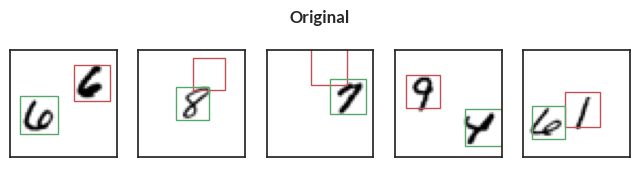

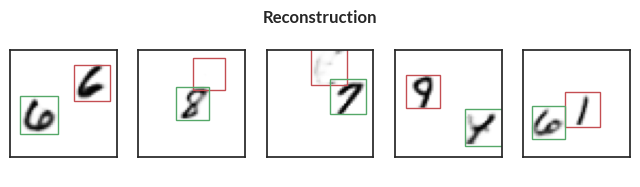

Epoch=120, total_epoch_step_time=493.36, loss=640.05
accuracy=0.758816659450531, counts=[[19412   535     1     0]
 [    2  6312 13703     3]
 [    2   223 19805     2]]


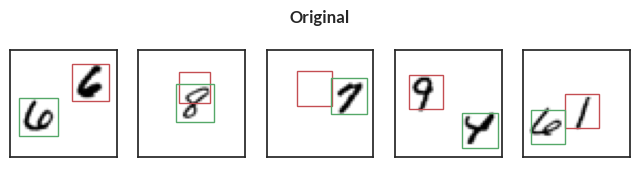

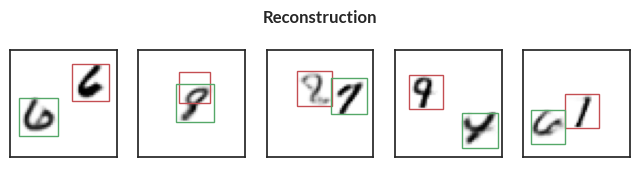

Epoch=121, total_epoch_step_time=497.43, loss=639.85
accuracy=0.7560666799545288, counts=[[19284   664     0     0]
 [    1  6245 13772     2]
 [    1   193 19835     3]]


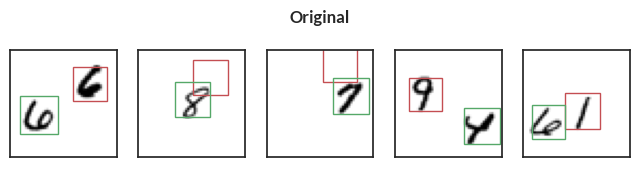

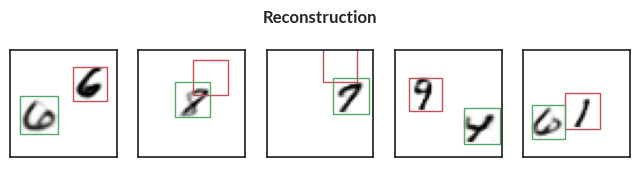

Epoch=122, total_epoch_step_time=501.51, loss=640.16
accuracy=0.7545333504676819, counts=[[19261   687     0     0]
 [    0  6185 13835     0]
 [    1   200 19826     5]]


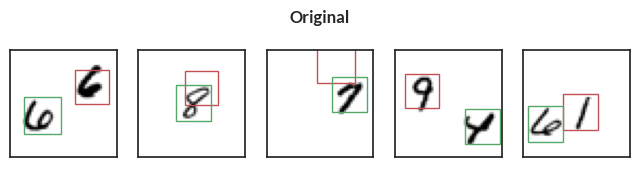

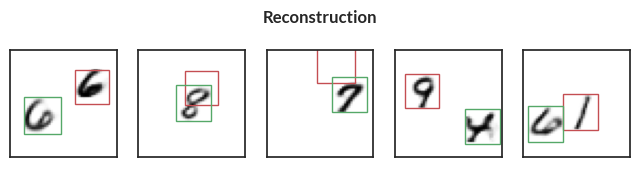

Epoch=123, total_epoch_step_time=505.59, loss=640.56
accuracy=0.760033369064331, counts=[[19421   527     0     0]
 [    0  6364 13655     1]
 [    1   208 19817     6]]


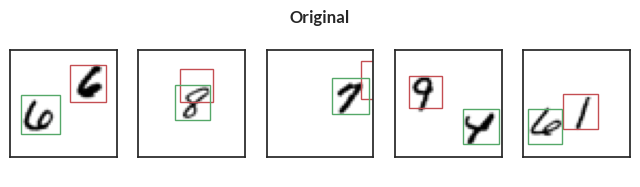

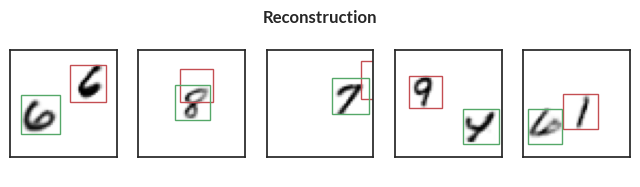

Epoch=124, total_epoch_step_time=509.67, loss=640.16
accuracy=0.7581499814987183, counts=[[19411   537     0     0]
 [    2  6266 13752     0]
 [    1   218 19812     1]]


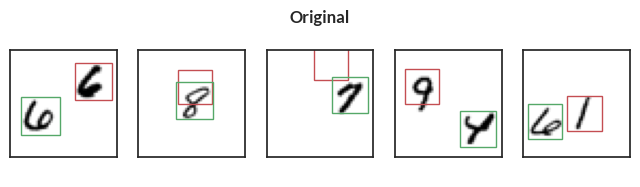

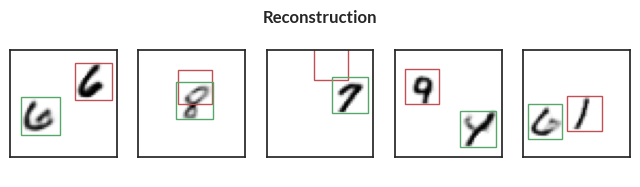

Epoch=125, total_epoch_step_time=513.75, loss=640.34
accuracy=0.7548999786376953, counts=[[19152   796     0     0]
 [    2  6322 13695     1]
 [    1   210 19820     1]]


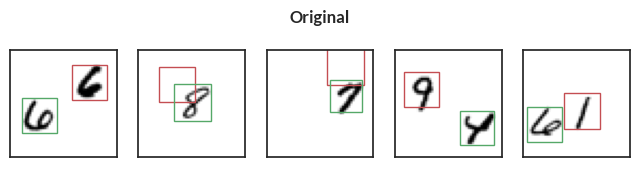

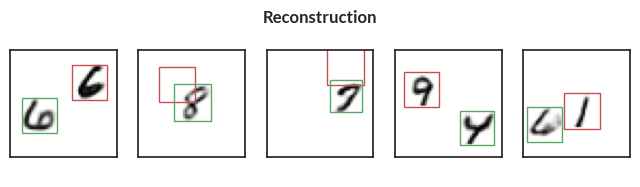

Epoch=126, total_epoch_step_time=517.81, loss=639.75
accuracy=0.7510666847229004, counts=[[18963   985     0     0]
 [    2  6284 13734     0]
 [    1   211 19817     3]]


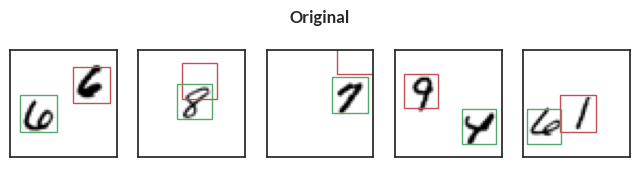

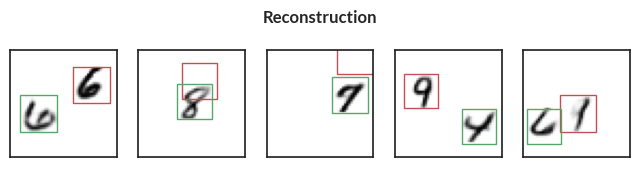

Epoch=127, total_epoch_step_time=521.90, loss=640.29
accuracy=0.757099986076355, counts=[[19392   555     1     0]
 [    1  6214 13803     2]
 [    1   207 19820     4]]


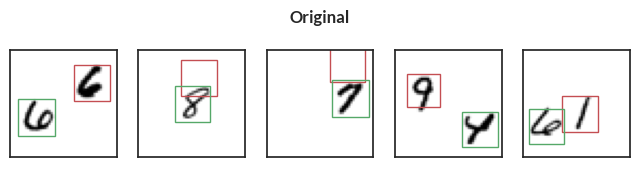

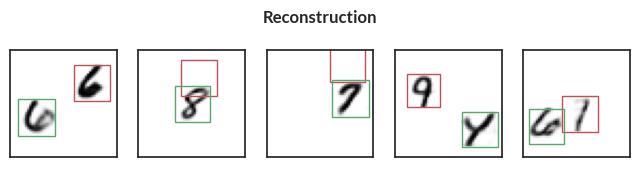

Epoch=128, total_epoch_step_time=525.98, loss=640.61
accuracy=0.7572667002677917, counts=[[19334   614     0     0]
 [    3  6291 13725     1]
 [    1   216 19811     4]]


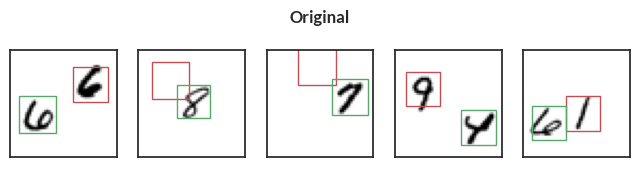

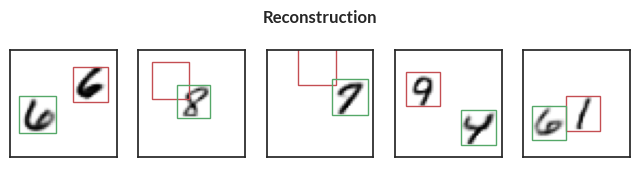

Epoch=129, total_epoch_step_time=530.06, loss=640.10
accuracy=0.7569167017936707, counts=[[19252   696     0     0]
 [    3  6336 13680     1]
 [    2   198 19827     5]]


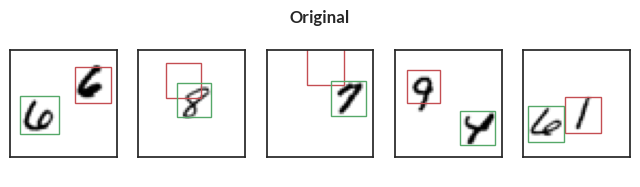

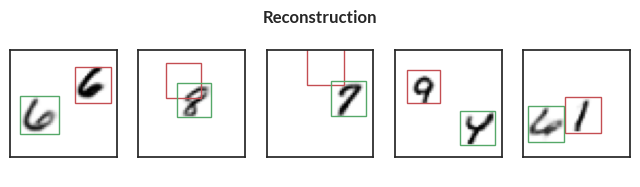

Epoch=130, total_epoch_step_time=534.13, loss=640.64
accuracy=0.7563333511352539, counts=[[19233   715     0     0]
 [    0  6327 13692     1]
 [    1   210 19820     1]]


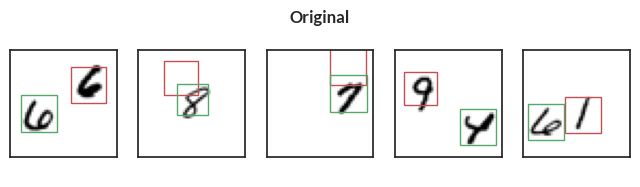

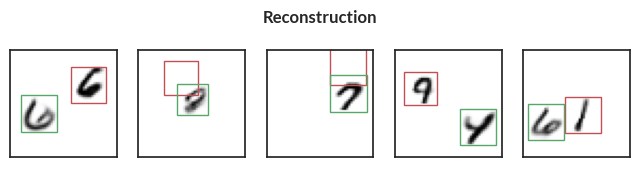

Epoch=131, total_epoch_step_time=538.22, loss=640.63
accuracy=0.7568833231925964, counts=[[19283   665     0     0]
 [    3  6314 13701     2]
 [    0   214 19816     2]]


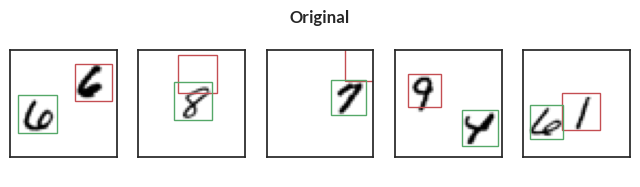

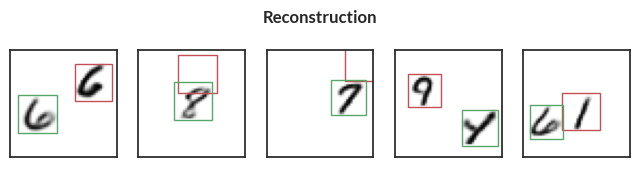

Epoch=132, total_epoch_step_time=542.30, loss=639.95
accuracy=0.7586166858673096, counts=[[19407   541     0     0]
 [    1  6296 13721     2]
 [    3   211 19814     4]]


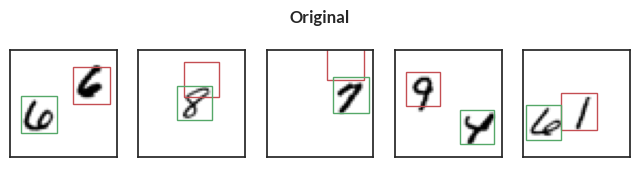

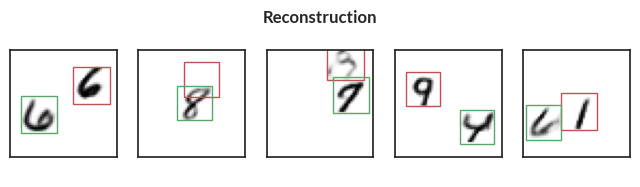

Epoch=133, total_epoch_step_time=546.38, loss=640.93
accuracy=0.751033365726471, counts=[[18988   960     0     0]
 [    1  6248 13768     3]
 [    0   203 19826     3]]


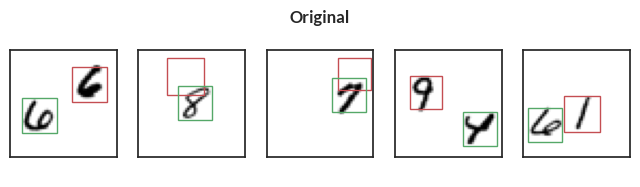

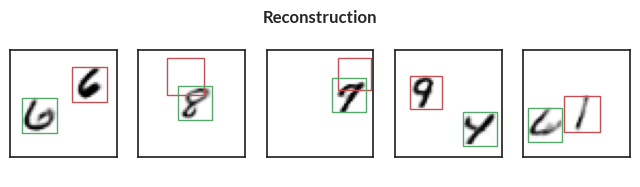

Epoch=134, total_epoch_step_time=550.45, loss=640.85
accuracy=0.760200023651123, counts=[[19470   478     0     0]
 [    1  6315 13703     1]
 [    2   199 19827     4]]


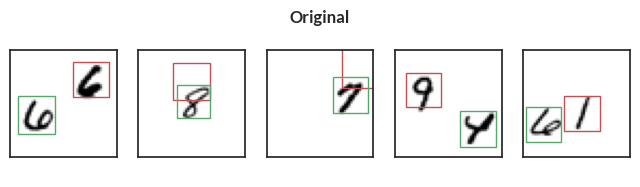

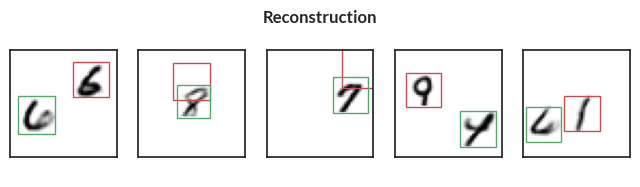

Epoch=135, total_epoch_step_time=554.52, loss=640.75
accuracy=0.7582499980926514, counts=[[19355   593     0     0]
 [    5  6326 13688     1]
 [    2   213 19814     3]]


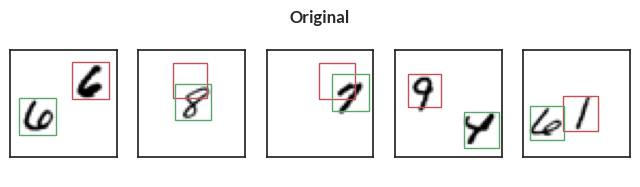

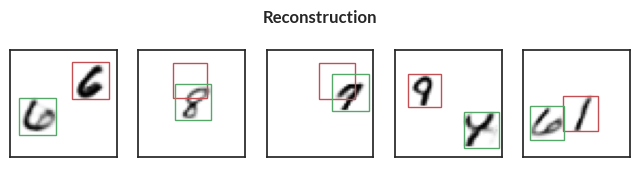

Epoch=136, total_epoch_step_time=558.59, loss=641.04
accuracy=0.7635999917984009, counts=[[19588   360     0     0]
 [    3  6415 13602     0]
 [    0   216 19813     3]]


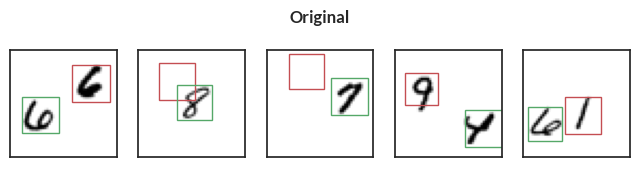

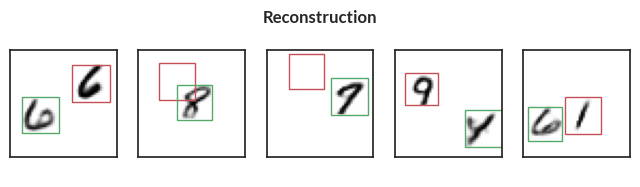

Epoch=137, total_epoch_step_time=562.67, loss=641.04
accuracy=0.7581000328063965, counts=[[19396   552     0     0]
 [    3  6277 13740     0]
 [    4   213 19813     2]]


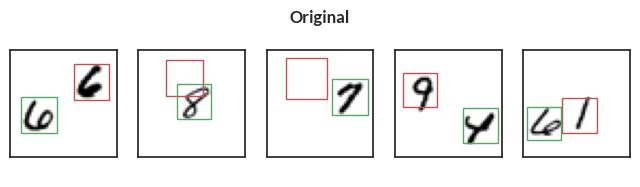

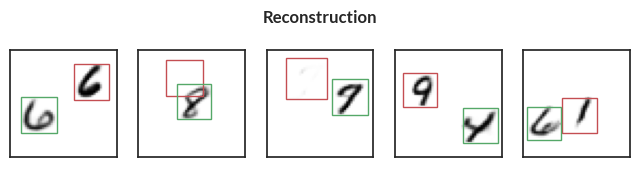

Epoch=138, total_epoch_step_time=566.74, loss=640.83
accuracy=0.758650004863739, counts=[[19318   630     0     0]
 [    2  6379 13639     0]
 [    2   204 19822     4]]


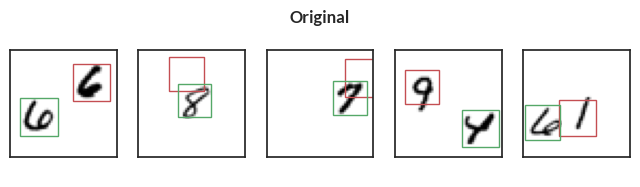

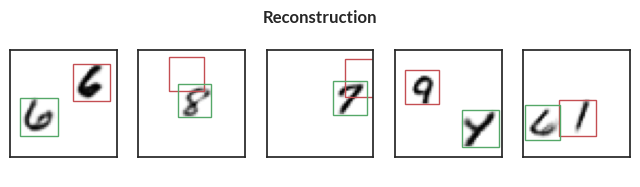

Epoch=139, total_epoch_step_time=570.82, loss=641.11
accuracy=0.7617999911308289, counts=[[19332   616     0     0]
 [    4  6561 13453     2]
 [    1   214 19815     2]]


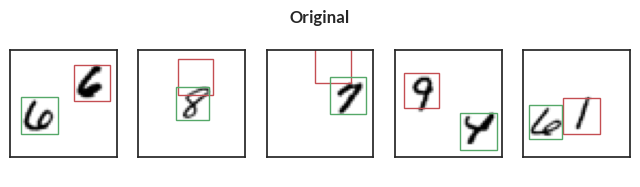

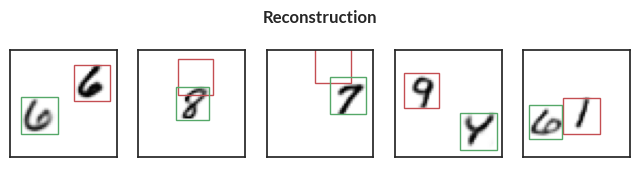

Epoch=140, total_epoch_step_time=574.89, loss=640.99
accuracy=0.7627333402633667, counts=[[19503   445     0     0]
 [    2  6434 13581     3]
 [    0   203 19827     2]]


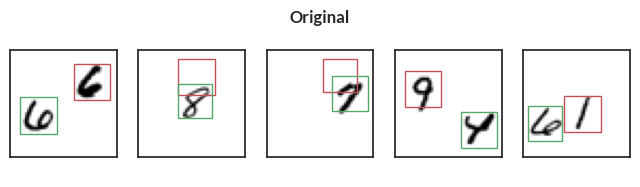

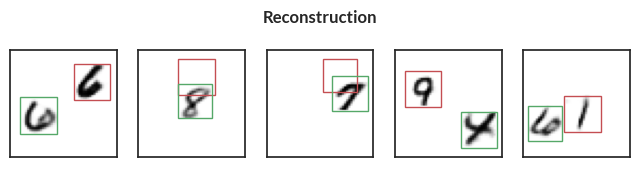

Epoch=141, total_epoch_step_time=578.97, loss=640.94
accuracy=0.7611333131790161, counts=[[19382   566     0     0]
 [    1  6490 13529     0]
 [    1   232 19796     3]]


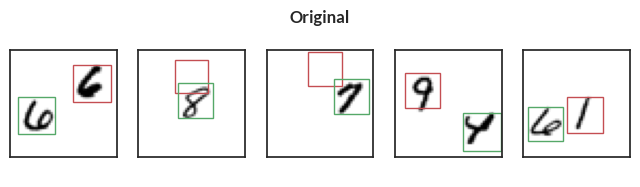

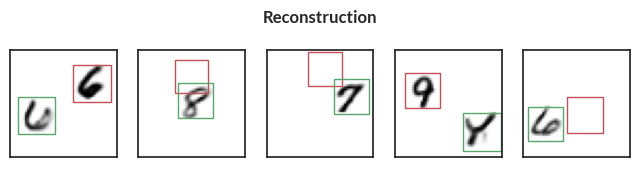

Epoch=142, total_epoch_step_time=583.04, loss=640.97
accuracy=0.7616000175476074, counts=[[19397   551     0     0]
 [    3  6494 13522     1]
 [    5   220 19805     2]]


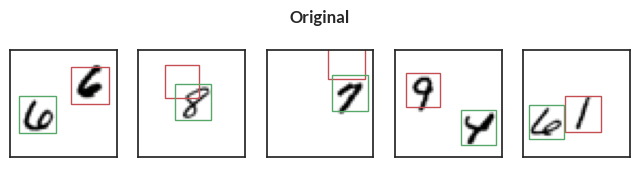

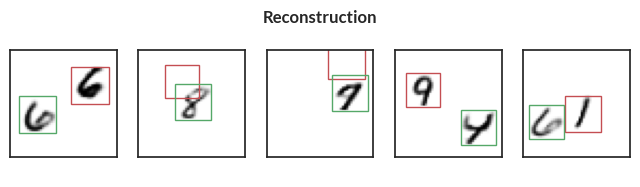

Epoch=143, total_epoch_step_time=587.12, loss=640.83
accuracy=0.7613833546638489, counts=[[19176   772     0     0]
 [    2  6697 13319     2]
 [    2   218 19810     2]]


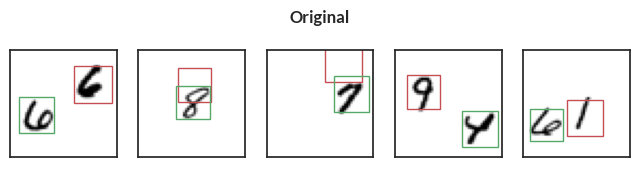

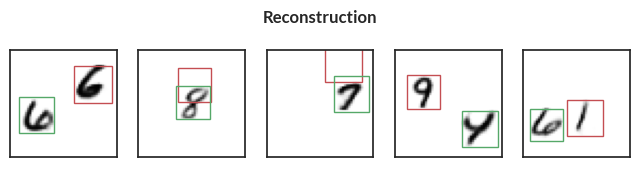

Epoch=144, total_epoch_step_time=591.20, loss=641.31
accuracy=0.7649333477020264, counts=[[19350   598     0     0]
 [    2  6751 13267     0]
 [    1   233 19795     3]]


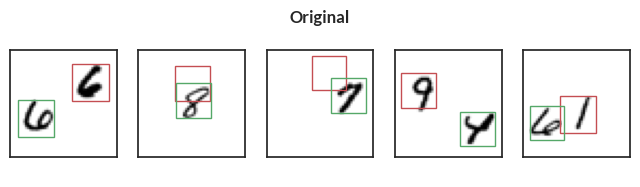

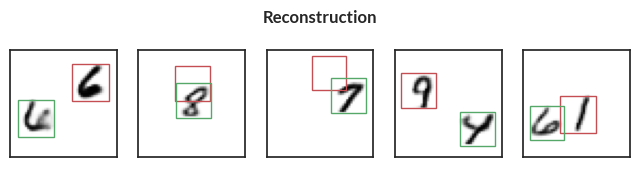

Epoch=145, total_epoch_step_time=595.29, loss=641.29
accuracy=0.7663666605949402, counts=[[19381   567     0     0]
 [    0  6809 13208     3]
 [    4   232 19792     4]]


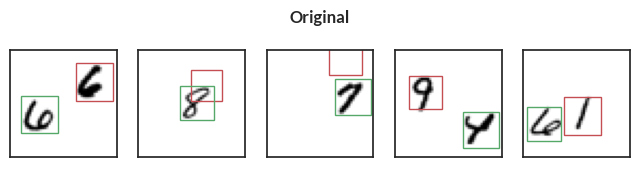

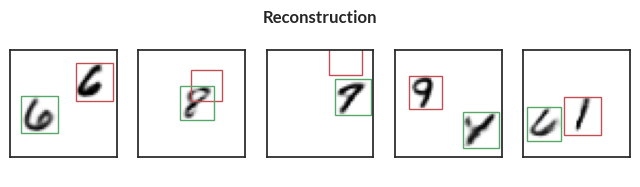

Epoch=146, total_epoch_step_time=599.38, loss=641.36
accuracy=0.7657333612442017, counts=[[19415   533     0     0]
 [    1  6722 13295     2]
 [    2   220 19807     3]]


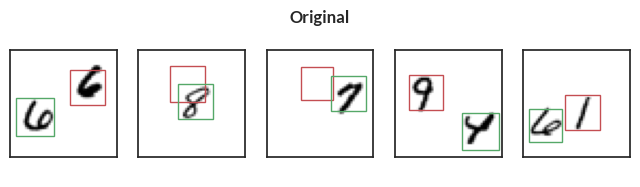

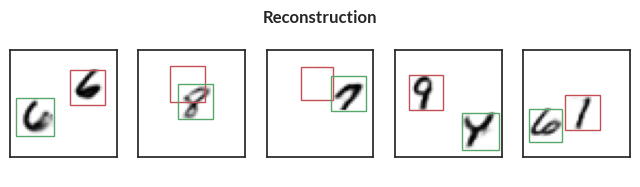

Epoch=147, total_epoch_step_time=603.47, loss=640.90
accuracy=0.7608500123023987, counts=[[19086   862     0     0]
 [    2  6760 13254     4]
 [    1   222 19805     4]]


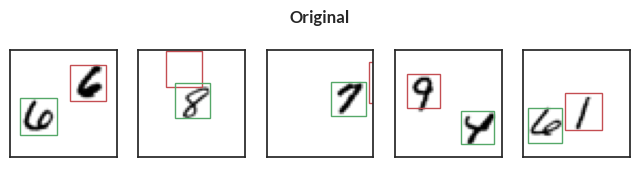

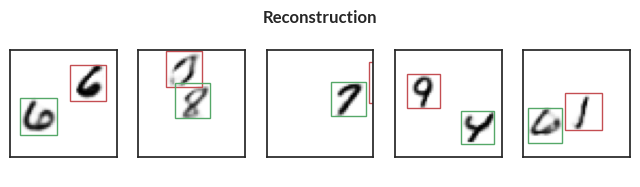

Epoch=148, total_epoch_step_time=607.56, loss=641.24
accuracy=0.7578499913215637, counts=[[18928  1020     0     0]
 [    2  6742 13275     1]
 [    3   225 19801     3]]


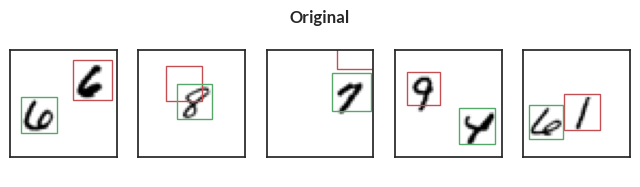

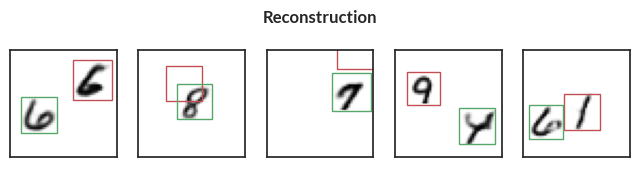

Epoch=149, total_epoch_step_time=611.65, loss=641.38
accuracy=0.7672333121299744, counts=[[19530   417     1     0]
 [    3  6682 13333     2]
 [    0   207 19822     3]]


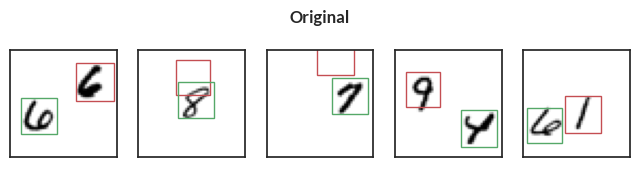

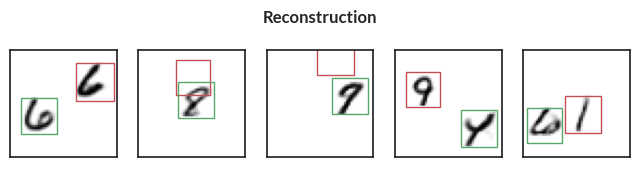

Epoch=150, total_epoch_step_time=615.72, loss=641.45
accuracy=0.7609166502952576, counts=[[19155   793     0     0]
 [    2  6683 13335     0]
 [    4   208 19817     3]]


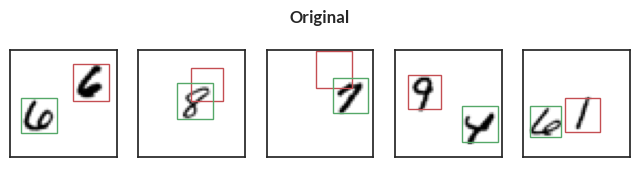

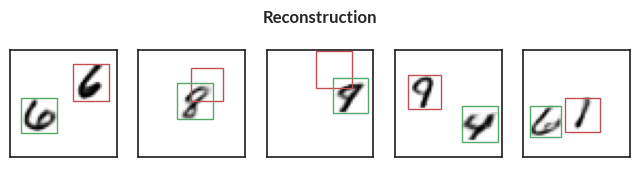

Epoch=151, total_epoch_step_time=619.80, loss=641.45
accuracy=0.7606666684150696, counts=[[19132   816     0     0]
 [    7  6698 13315     0]
 [    2   216 19810     4]]


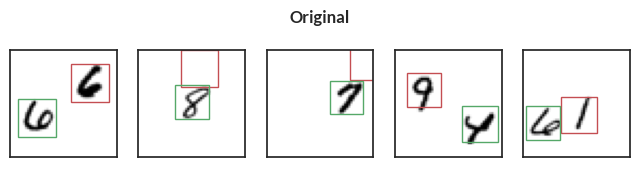

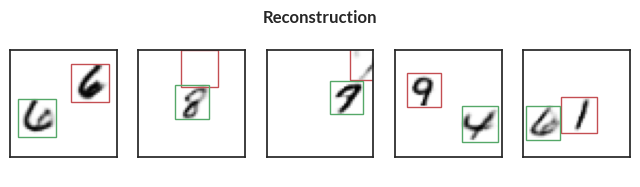

Epoch=152, total_epoch_step_time=623.89, loss=641.19
accuracy=0.7659500241279602, counts=[[19357   591     0     0]
 [    3  6786 13230     1]
 [    2   213 19814     3]]


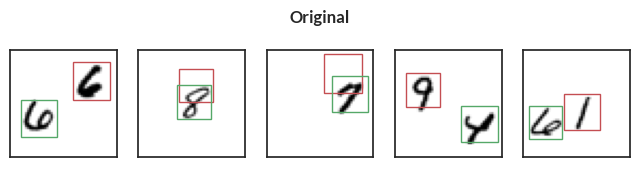

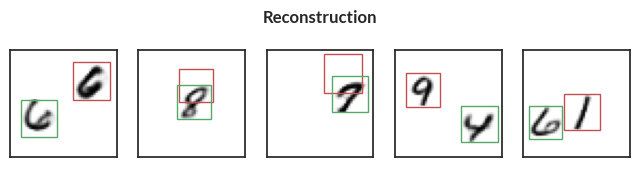

Epoch=153, total_epoch_step_time=627.98, loss=641.76
accuracy=0.7678000330924988, counts=[[19418   530     0     0]
 [    4  6839 13177     0]
 [    2   217 19811     2]]


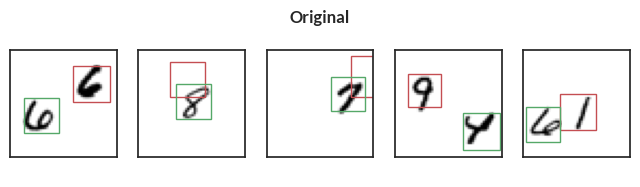

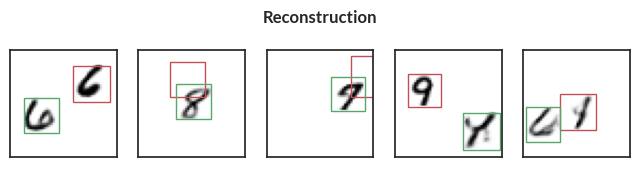

Epoch=154, total_epoch_step_time=632.06, loss=641.70
accuracy=0.7683833241462708, counts=[[19403   545     0     0]
 [    3  6916 13099     2]
 [    0   244 19784     4]]


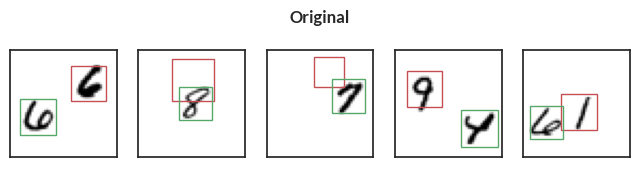

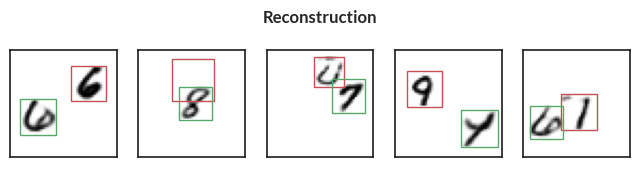

Epoch=155, total_epoch_step_time=636.15, loss=641.35
accuracy=0.7613666653633118, counts=[[19066   882     0     0]
 [    0  6810 13209     1]
 [    1   223 19806     2]]


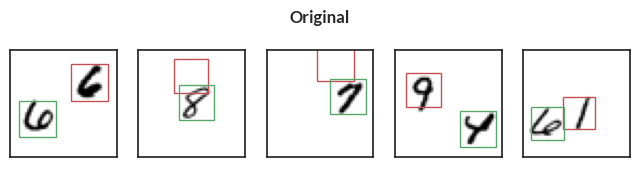

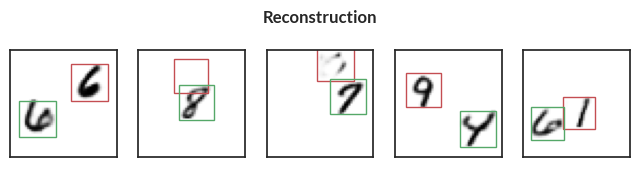

Epoch=156, total_epoch_step_time=640.24, loss=641.19
accuracy=0.76705002784729, counts=[[19373   575     0     0]
 [    3  6846 13170     1]
 [    1   225 19804     2]]


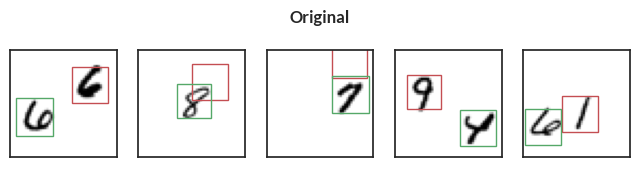

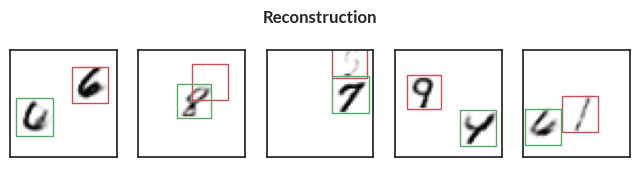

Epoch=157, total_epoch_step_time=644.31, loss=641.74
accuracy=0.7698500156402588, counts=[[19409   539     0     0]
 [    1  7006 13011     2]
 [    1   250 19776     5]]


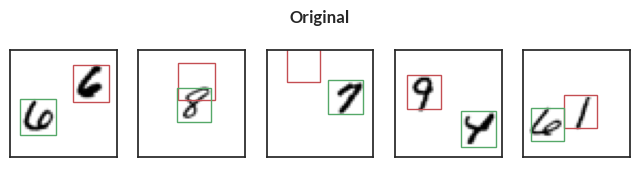

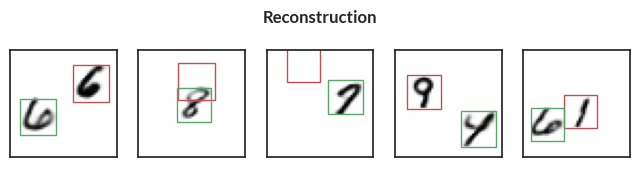

Epoch=158, total_epoch_step_time=648.39, loss=641.48
accuracy=0.7675166726112366, counts=[[19353   595     0     0]
 [    2  6892 13124     2]
 [    0   225 19806     1]]


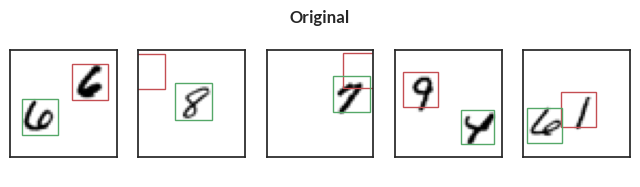

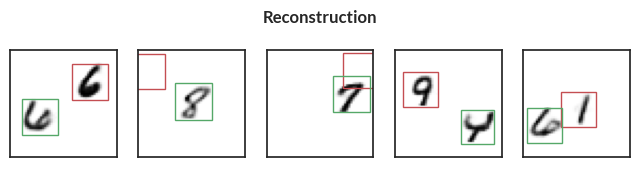

Epoch=159, total_epoch_step_time=652.47, loss=640.84
accuracy=0.7678999900817871, counts=[[19406   542     0     0]
 [    3  6861 13151     5]
 [    2   221 19807     2]]


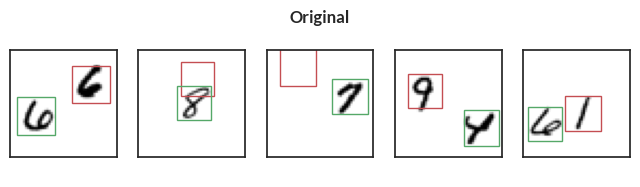

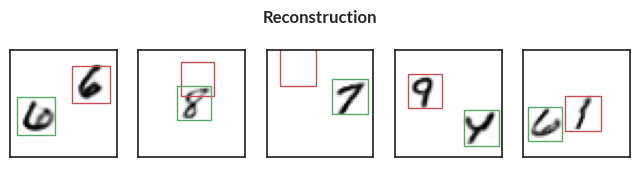

Epoch=160, total_epoch_step_time=656.54, loss=641.50
accuracy=0.7669833302497864, counts=[[19347   601     0     0]
 [    4  6886 13130     0]
 [    2   240 19786     4]]


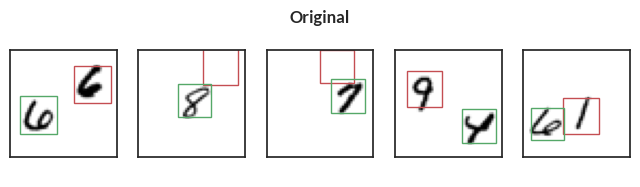

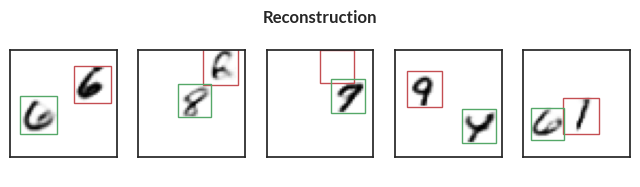

Epoch=161, total_epoch_step_time=660.62, loss=641.63
accuracy=0.7656000256538391, counts=[[19319   629     0     0]
 [    1  6803 13214     2]
 [    2   214 19814     2]]


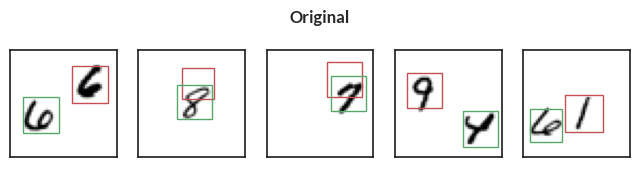

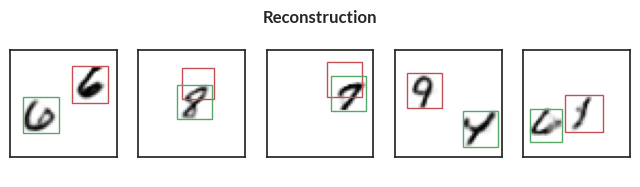

Epoch=162, total_epoch_step_time=664.70, loss=641.83
accuracy=0.7661333680152893, counts=[[19346   601     1     0]
 [    2  6822 13195     1]
 [    1   230 19800     1]]


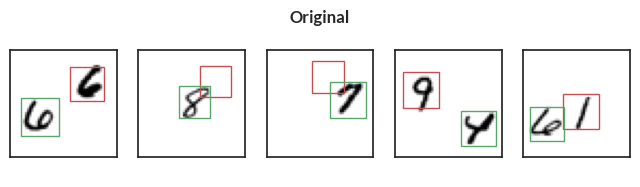

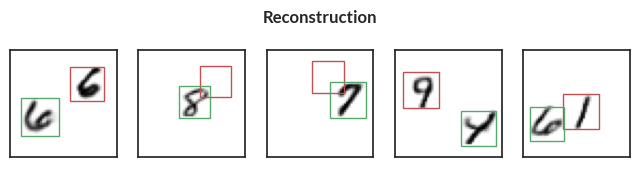

Epoch=163, total_epoch_step_time=668.78, loss=641.74
accuracy=0.7669000029563904, counts=[[19354   593     1     0]
 [    0  6869 13148     3]
 [    1   237 19791     3]]


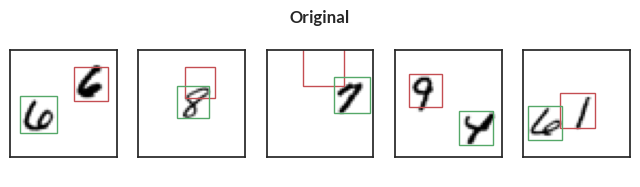

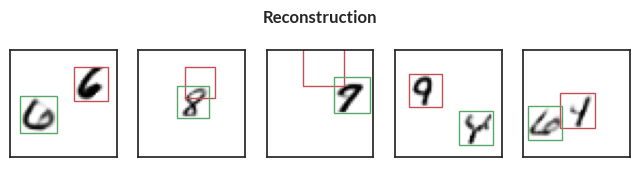

Epoch=164, total_epoch_step_time=672.86, loss=641.85
accuracy=0.7594500184059143, counts=[[18907  1041     0     0]
 [    1  6848 13169     2]
 [    1   217 19812     2]]


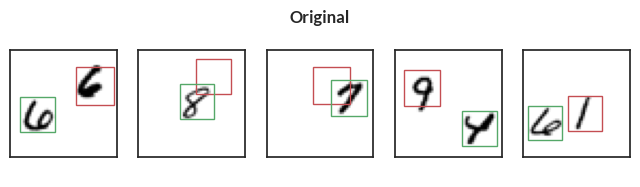

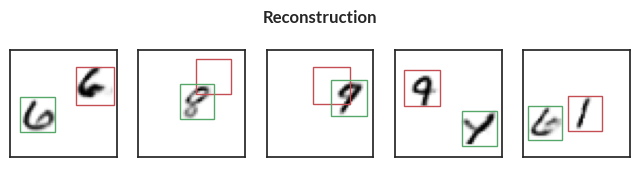

Epoch=165, total_epoch_step_time=676.94, loss=641.76
accuracy=0.76746666431427, counts=[[19369   579     0     0]
 [    2  6866 13148     4]
 [    1   213 19813     5]]


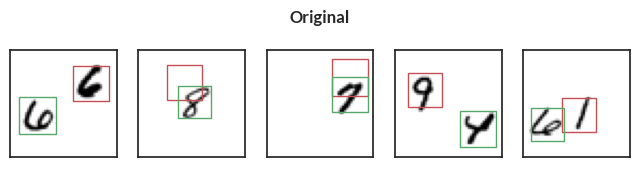

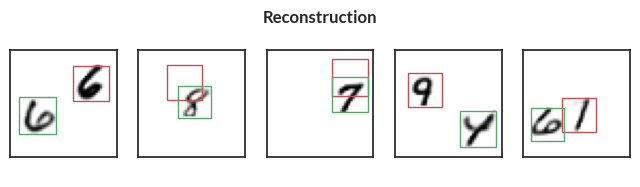

Epoch=166, total_epoch_step_time=681.02, loss=641.89
accuracy=0.7603333592414856, counts=[[18932  1016     0     0]
 [    2  6867 13149     2]
 [    1   207 19821     3]]


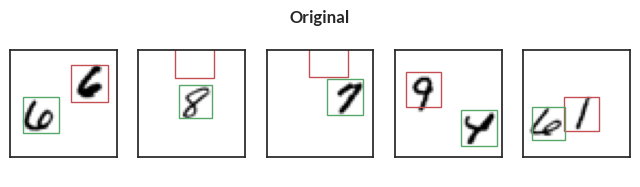

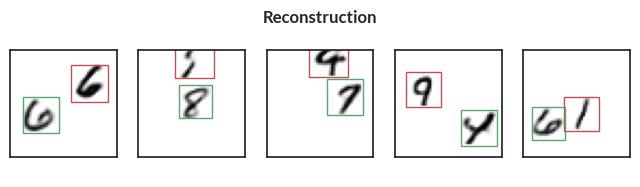

Epoch=167, total_epoch_step_time=685.10, loss=642.18
accuracy=0.7590000033378601, counts=[[18872  1076     0     0]
 [    1  6871 13146     2]
 [    1   232 19797     2]]


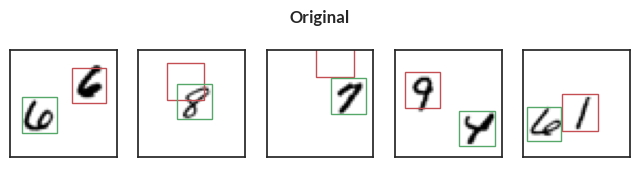

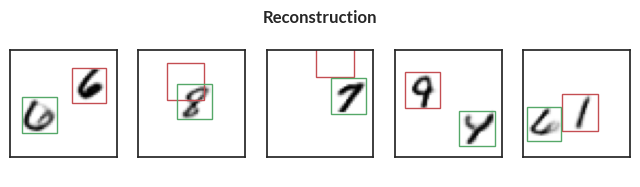

Epoch=168, total_epoch_step_time=689.18, loss=642.04
accuracy=0.7679166793823242, counts=[[19300   648     0     0]
 [    2  6975 13043     0]
 [    2   229 19800     1]]


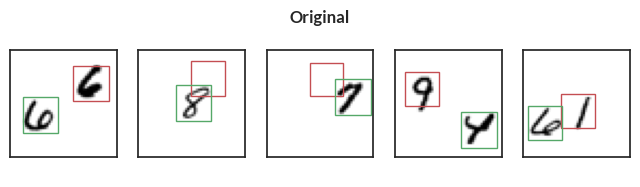

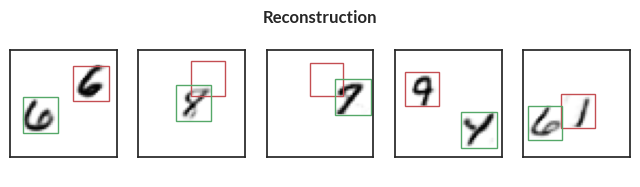

Epoch=169, total_epoch_step_time=693.26, loss=641.89
accuracy=0.7681833505630493, counts=[[19265   682     1     0]
 [    2  7050 12966     2]
 [    2   249 19776     5]]


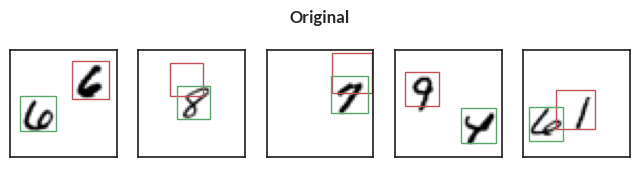

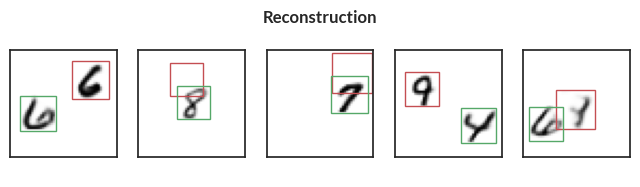

Epoch=170, total_epoch_step_time=697.34, loss=641.97
accuracy=0.7674000263214111, counts=[[19106   842     0     0]
 [    1  7148 12870     1]
 [    4   236 19790     2]]


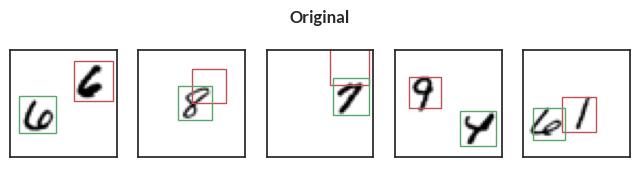

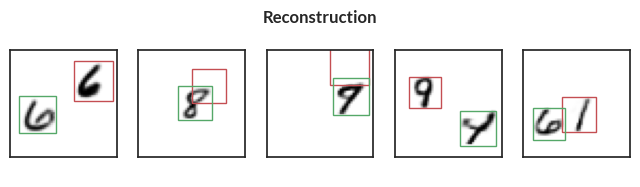

Epoch=171, total_epoch_step_time=701.43, loss=641.68
accuracy=0.7605666518211365, counts=[[18769  1179     0     0]
 [    2  7066 12950     2]
 [    2   229 19799     2]]


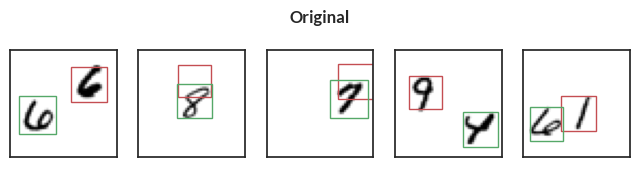

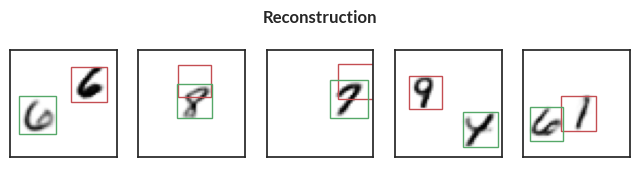

Epoch=172, total_epoch_step_time=705.51, loss=640.87
accuracy=0.766616702079773, counts=[[19078   870     0     0]
 [    2  7137 12881     0]
 [    1   247 19782     2]]


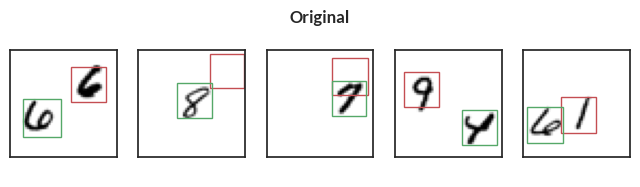

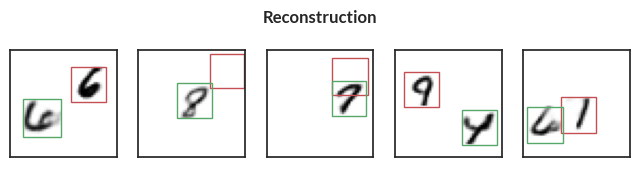

Epoch=173, total_epoch_step_time=709.59, loss=642.06
accuracy=0.7612000107765198, counts=[[18843  1105     0     0]
 [    2  7028 12990     0]
 [    0   228 19801     3]]


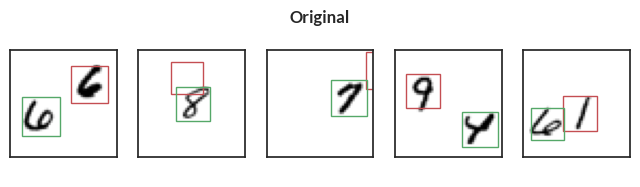

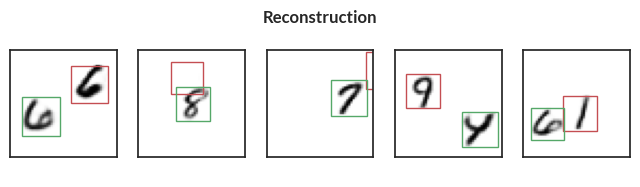

Epoch=174, total_epoch_step_time=713.68, loss=642.50
accuracy=0.7631166577339172, counts=[[18943  1005     0     0]
 [    3  7052 12964     1]
 [    0   239 19792     1]]


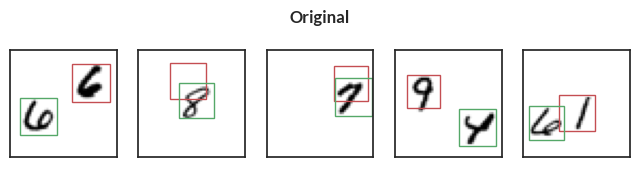

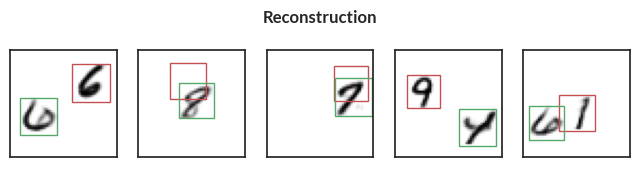

Epoch=175, total_epoch_step_time=717.76, loss=641.81
accuracy=0.7713000178337097, counts=[[19438   510     0     0]
 [    4  7042 12974     0]
 [    3   229 19798     2]]


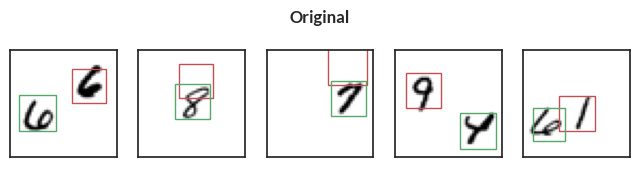

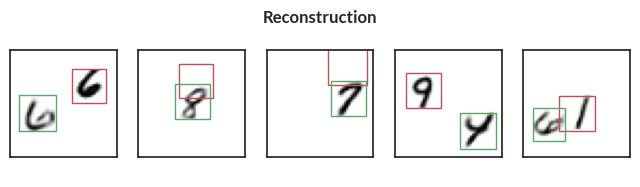

Epoch=176, total_epoch_step_time=721.84, loss=642.33
accuracy=0.7673333287239075, counts=[[19305   642     1     0]
 [    3  6927 13089     1]
 [    1   221 19808     2]]


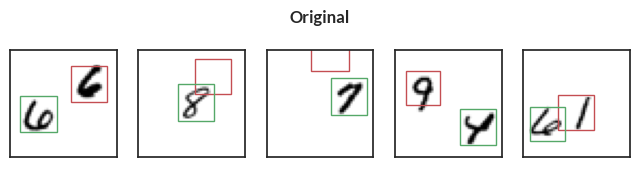

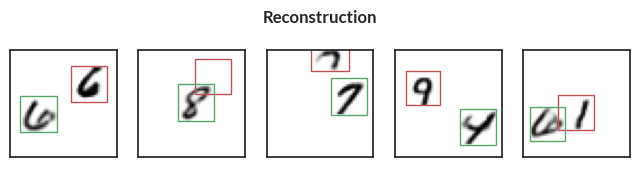

Epoch=177, total_epoch_step_time=725.92, loss=642.40
accuracy=0.7669000029563904, counts=[[19246   702     0     0]
 [    3  6959 13056     2]
 [    1   221 19809     1]]


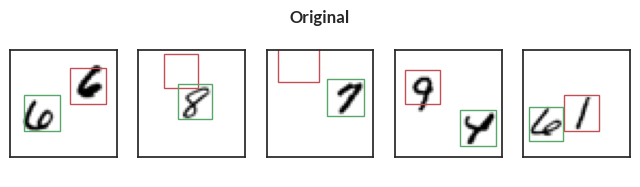

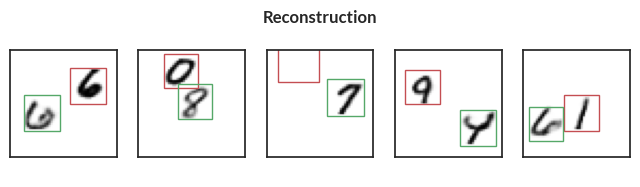

Epoch=178, total_epoch_step_time=730.00, loss=642.39
accuracy=0.7669333219528198, counts=[[19056   891     1     0]
 [    3  7166 12850     1]
 [    0   236 19794     2]]


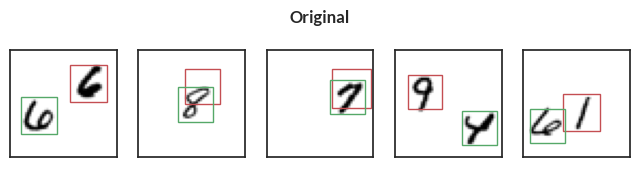

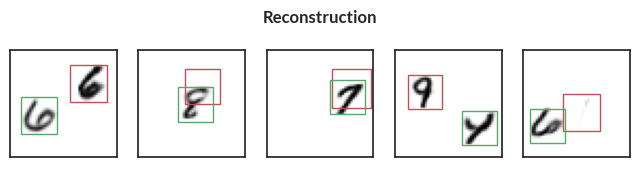

Epoch=179, total_epoch_step_time=734.08, loss=642.46
accuracy=0.7684666514396667, counts=[[19223   725     0     0]
 [    3  7080 12934     3]
 [    0   223 19805     4]]


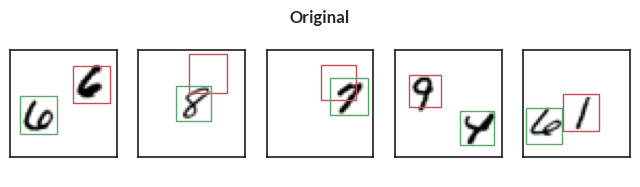

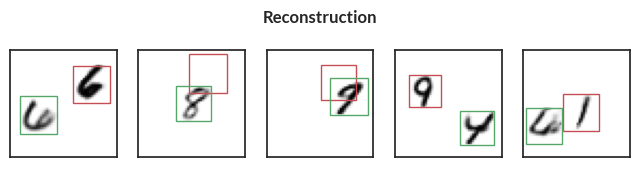

Epoch=180, total_epoch_step_time=738.16, loss=642.16
accuracy=0.7646833658218384, counts=[[18970   978     0     0]
 [    1  7106 12913     0]
 [    1   224 19805     2]]


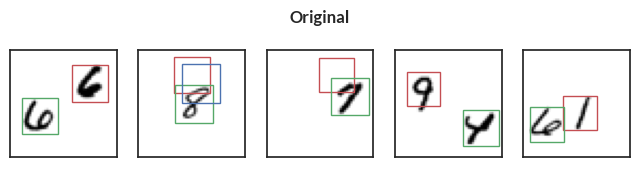

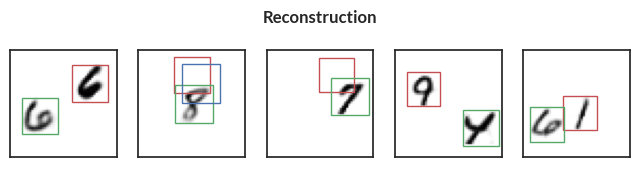

Epoch=181, total_epoch_step_time=742.24, loss=641.97
accuracy=0.7674833536148071, counts=[[19064   884     0     0]
 [    3  7185 12830     2]
 [    1   229 19800     2]]


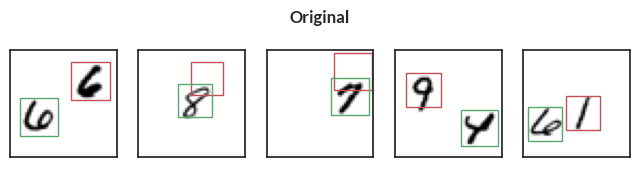

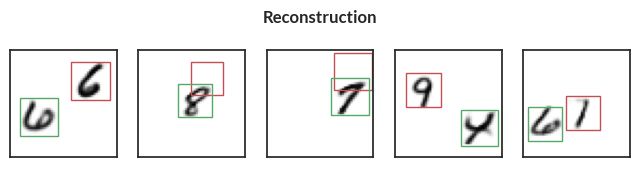

Epoch=182, total_epoch_step_time=746.32, loss=642.55
accuracy=0.7662166953086853, counts=[[18940  1008     0     0]
 [    2  7231 12786     1]
 [    1   225 19802     4]]


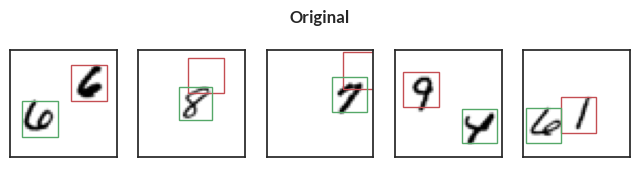

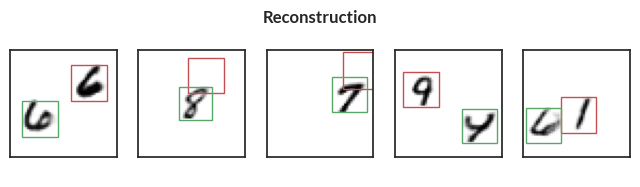

Epoch=183, total_epoch_step_time=750.39, loss=642.35
accuracy=0.7691333293914795, counts=[[19143   805     0     0]
 [    4  7208 12808     0]
 [    3   227 19797     5]]


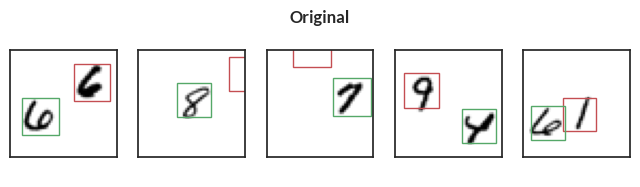

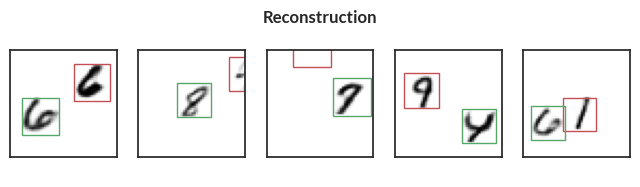

Epoch=184, total_epoch_step_time=754.48, loss=642.74
accuracy=0.7701833248138428, counts=[[19146   802     0     0]
 [    2  7275 12742     1]
 [    3   237 19790     2]]


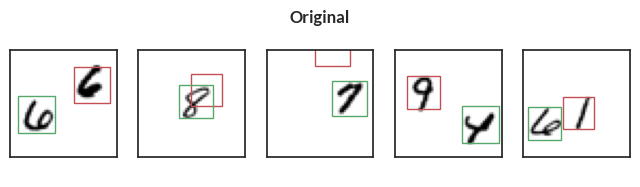

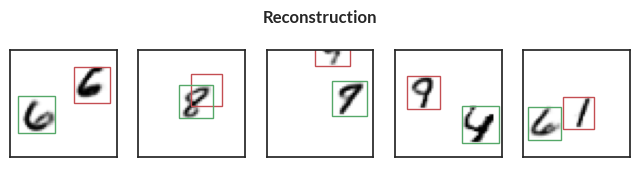

Epoch=185, total_epoch_step_time=758.56, loss=642.49
accuracy=0.774066686630249, counts=[[19472   476     0     0]
 [    2  7176 12838     4]
 [    1   232 19796     3]]


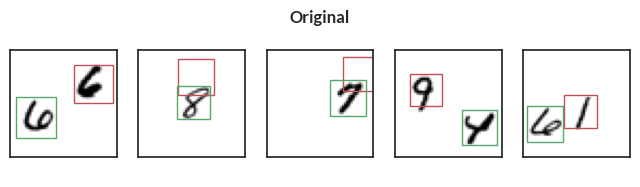

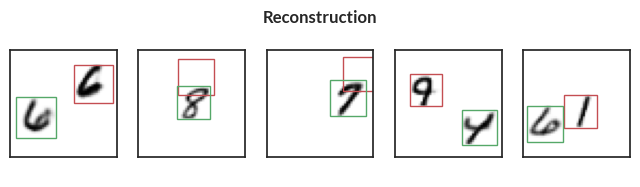

Epoch=186, total_epoch_step_time=762.64, loss=642.23
accuracy=0.770716667175293, counts=[[19335   613     0     0]
 [    2  7109 12909     0]
 [    3   227 19799     3]]


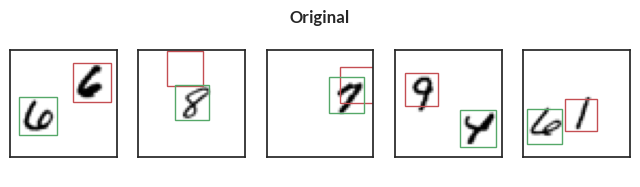

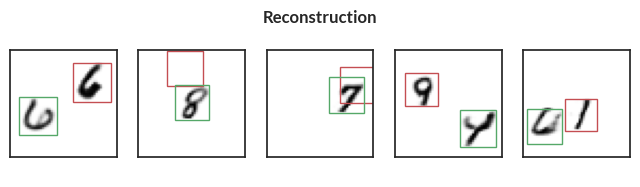

Epoch=187, total_epoch_step_time=766.71, loss=642.82
accuracy=0.7723166942596436, counts=[[19306   642     0     0]
 [    4  7238 12777     1]
 [    3   231 19795     3]]


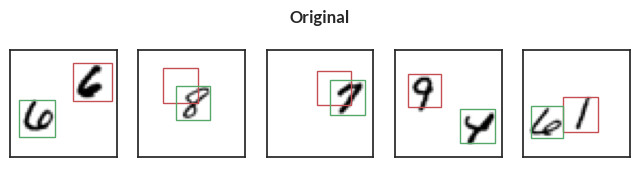

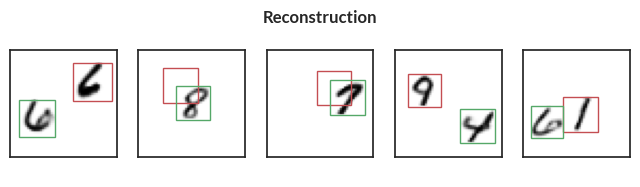

Epoch=188, total_epoch_step_time=770.79, loss=642.64
accuracy=0.7661333680152893, counts=[[18973   975     0     0]
 [    1  7202 12816     1]
 [    1   234 19793     4]]


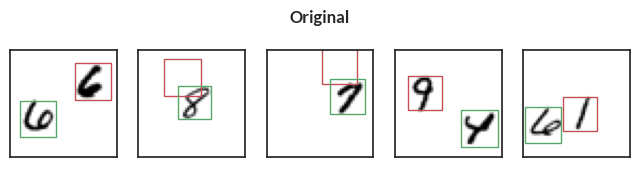

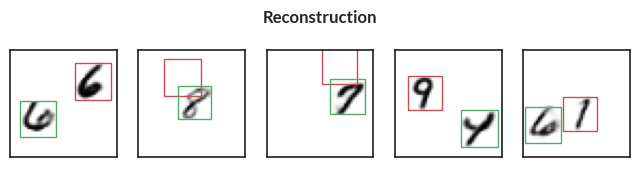

Epoch=189, total_epoch_step_time=774.87, loss=642.13
accuracy=0.7695000171661377, counts=[[19208   740     0     0]
 [    2  7160 12857     1]
 [    3   223 19802     4]]


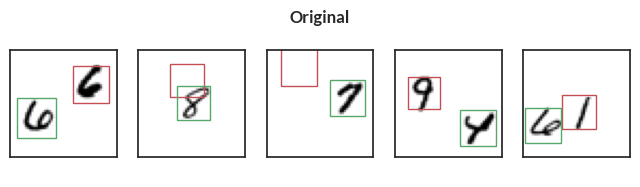

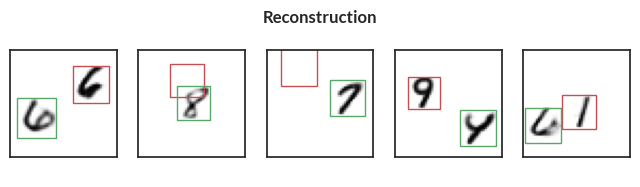

Epoch=190, total_epoch_step_time=778.94, loss=642.51
accuracy=0.7732000350952148, counts=[[19336   612     0     0]
 [    2  7266 12750     2]
 [    1   237 19790     4]]


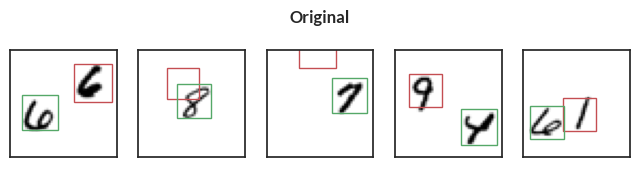

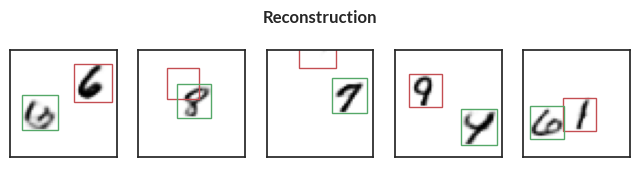

Epoch=191, total_epoch_step_time=783.02, loss=642.35
accuracy=0.7706666588783264, counts=[[19202   745     1     0]
 [    2  7249 12767     2]
 [    3   239 19789     1]]


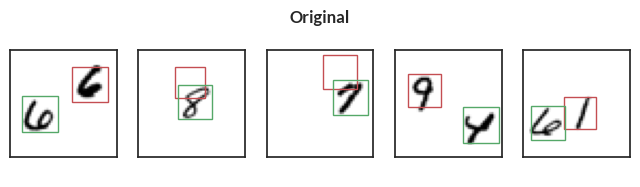

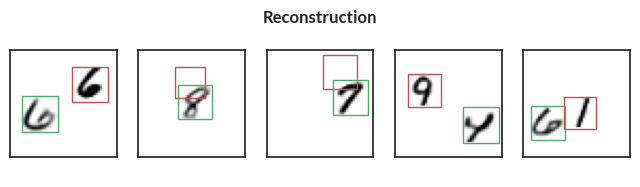

Epoch=192, total_epoch_step_time=787.10, loss=642.59
accuracy=0.7746500372886658, counts=[[19361   587     0     0]
 [    2  7326 12692     0]
 [    1   238 19792     1]]


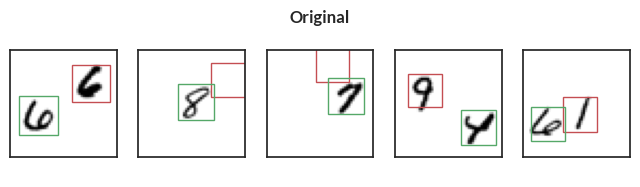

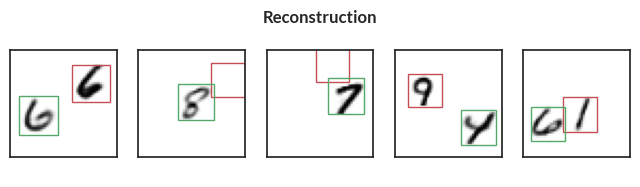

Epoch=193, total_epoch_step_time=791.18, loss=642.02
accuracy=0.7778000235557556, counts=[[19482   466     0     0]
 [    2  7411 12607     0]
 [    0   254 19775     3]]


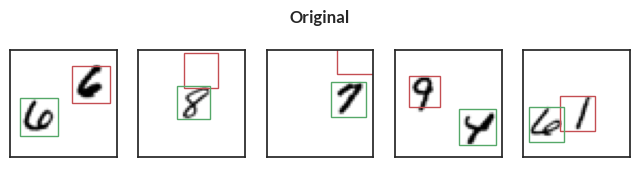

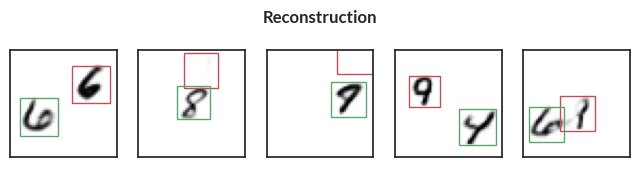

Epoch=194, total_epoch_step_time=795.25, loss=642.75
accuracy=0.7787333130836487, counts=[[19453   495     0     0]
 [    2  7488 12530     0]
 [    3   245 19783     1]]


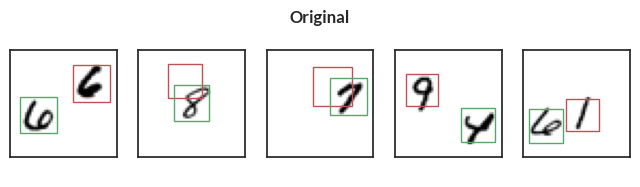

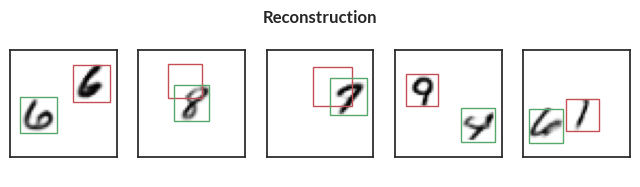

Epoch=195, total_epoch_step_time=799.33, loss=642.53
accuracy=0.7645666599273682, counts=[[18836  1112     0     0]
 [    0  7239 12778     3]
 [    1   230 19799     2]]


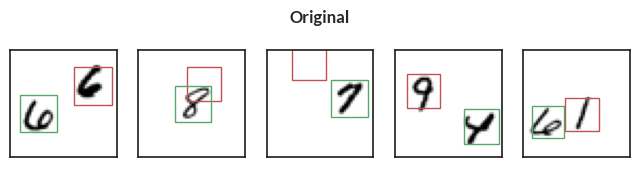

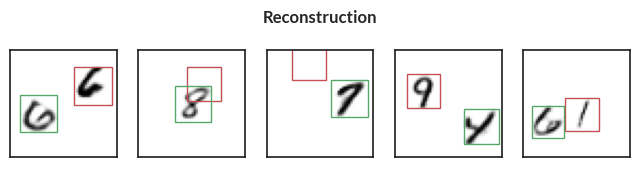

Epoch=196, total_epoch_step_time=803.41, loss=642.82
accuracy=0.7707333564758301, counts=[[19276   672     0     0]
 [    1  7170 12845     4]
 [    1   228 19798     5]]


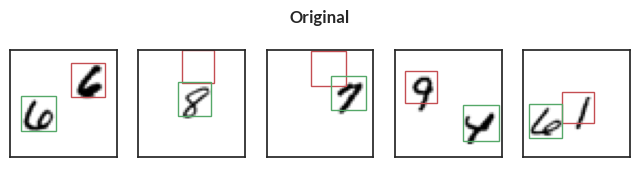

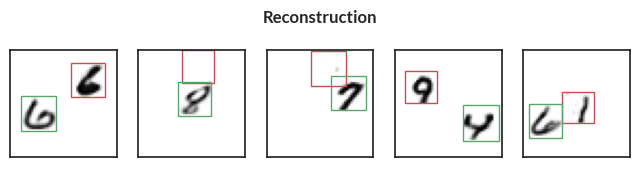

Epoch=197, total_epoch_step_time=807.48, loss=642.50
accuracy=0.7711666822433472, counts=[[19108   840     0     0]
 [    4  7361 12654     1]
 [    2   228 19801     1]]


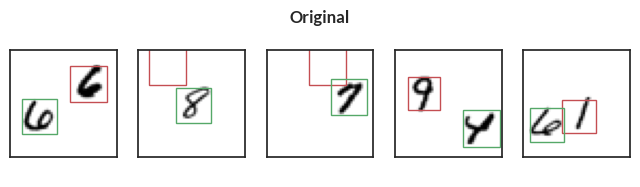

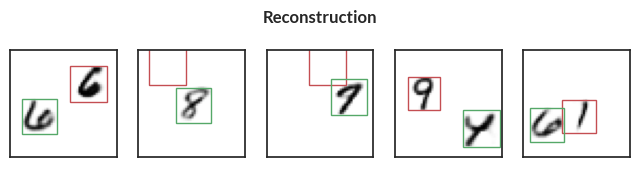

Epoch=198, total_epoch_step_time=811.56, loss=642.36
accuracy=0.7770500183105469, counts=[[19423   525     0     0]
 [    2  7423 12592     3]
 [    3   249 19777     3]]


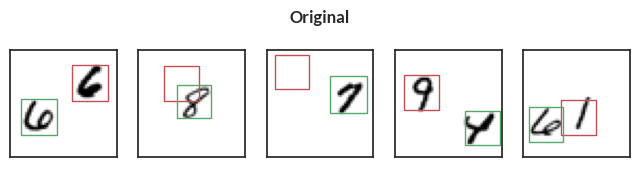

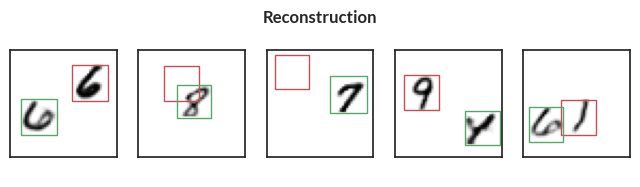

Epoch=199, total_epoch_step_time=815.63, loss=642.12
accuracy=0.7733666896820068, counts=[[19202   746     0     0]
 [    4  7412 12602     2]
 [    2   240 19788     2]]


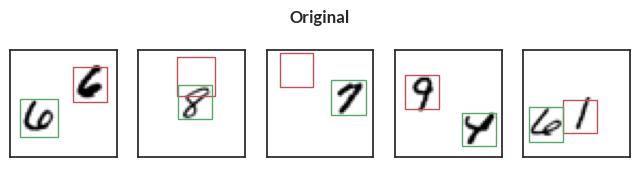

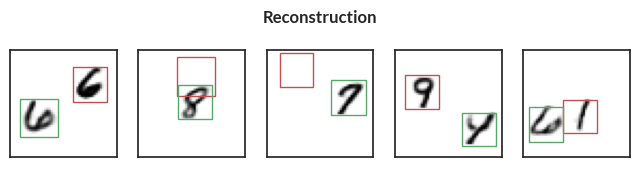

Epoch=200, total_epoch_step_time=819.70, loss=642.81
accuracy=0.7750666737556458, counts=[[19183   765     0     0]
 [    3  7545 12471     1]
 [    4   250 19776     2]]


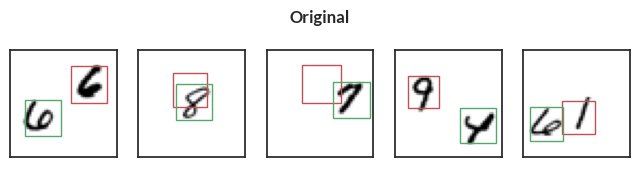

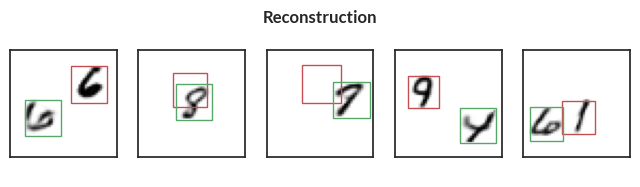

In [17]:
key, sub_key = jax.random.split(key)
losses, accuracy, wall_clock_times, params = train(
    sub_key, learning_rate=1.0e-3, n=2, batch_size=32, num_epochs=200
)

In [18]:
import pandas as pd

arr = np.array([losses, accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv("./training_runs/grasp_pure_mvd_epochs_201_mccoy_prior.csv", index=False)